In this section we will try to reproduct the SPT detectors for spin-1 Haldane model.
To justify the code we designed is good enough...

Though I really wanted to reuse the interfaces provided in TeNPy, it turns out that it will be much easier to just reuse our own Kitaev ladder code. (2020/12/12)

Well after checking the spin-1 model Hamiltonian again, which is 
$$ H = J\sum_{i}S_i\cdot S_{i+1} + B \sum_{i} S^x_i + D\sum_{i} [S^z_i]^2 $$
I believe it will be better to make use of their TFI model. (2020/12/12)

In [6]:
import numpy as np
import itertools
import warnings
import matplotlib.pyplot as plt
from random import choice
import scipy.sparse as sparse

import tenpy
from tenpy.networks.site import Site, SpinHalfFermionSite, SpinHalfSite, GroupedSite, SpinSite
from tenpy.tools.misc import to_iterable, to_iterable_of_len, inverse_permutation
from tenpy.networks.mps import MPS  # only to check boundary conditions

from tenpy.models.lattice import Lattice, _parse_sites
from tenpy.models.model import CouplingMPOModel, NearestNeighborModel
from tenpy.tools.params import get_parameter

from tenpy.algorithms import dmrg
# from tenpy.networks import SpinHalfSite

# some api for the file operation
import h5py
from tenpy.tools import hdf5_io
import os.path

# functools
from functools import wraps

# path
from pathlib import Path


from tenpy.linalg.np_conserved import tensordot

from utility import linspace

In [7]:
import numpy as np

from tenpy.models.model import CouplingMPOModel, NearestNeighborModel
from tenpy.tools.params import asConfig
from tenpy.networks.site import SpinSite


class Spin1HaldaneModel(CouplingMPOModel):
    r"""Transverse field Ising model on a general lattice.
    The Hamiltonian reads:
    .. math ::
        H = - \sum_{\langle i,j\rangle, i < j} \mathtt{J} \sigma^x_i \sigma^x_{j}
            - \sum_{i} \mathtt{g} \sigma^z_i
    Here, :math:`\langle i,j \rangle, i< j` denotes nearest neighbor pairs, each pair appearing
    exactly once.
    All parameters are collected in a single dictionary `model_params`, which
    is turned into a :class:`~tenpy.tools.params.Config` object.
    Parameters
    ----------
    model_params : :class:`~tenpy.tools.params.Config`
        Parameters for the model. See :cfg:config:`TFIModel` below.
    Options
    -------
    .. cfg:config :: TFIModel
        :include: CouplingMPOModel
        conserve : None | 'parity'
            What should be conserved. See :class:`~tenpy.networks.Site.SpinHalfSite`.
        J, g : float | array
            Coupling as defined for the Hamiltonian above.
    """
    def init_sites(self, model_params):
        conserve = model_params.get('conserve', 'parity')
        assert conserve != 'Sz'
        if conserve == 'best':
            conserve = 'parity'
            if self.verbose >= 1.:
                print(self.name + ": set conserve to", conserve)
        site = SpinSite(S=1, conserve=conserve)
        site.add_op(name='Szsq', op=tensordot(site.get_op('Sz'), site.get_op('Sz'), axes=1))
#         print(site.get_op('Szsq'))
        return site

    def init_terms(self, model_params):
        J = np.asarray(model_params.get('J', 1.)) # param for the Heisenbery term
        B = np.asarray(model_params.get('B', 0.)) # for the magnetic field
        D = np.asarray(model_params.get('D', 0.)) # for the Square term
        for u in range(len(self.lat.unit_cell)):
            self.add_onsite(B, u, 'Sx')
            self.add_onsite(D, u, 'Szsq')
        for u1, u2, dx in self.lat.pairs['nearest_neighbors']:
            self.add_coupling(J, u1, 'Sx', u2, 'Sx', dx)
            self.add_coupling(J, u1, 'Sy', u2, 'Sy', dx)
            self.add_coupling(J, u1, 'Sz', u2, 'Sz', dx)
        # done

In [30]:
# for testing
model_params = {'J': 1, 'B': 0.0, 'D': -1.0}
Spin1HaldaneModel(model_params)

<npc.Array shape=(3, 3) charge=ChargeInfo([2], ['parity']) labels=['p', 'p*']
 +1    | -1    
0 [[0] |0 [[0] 
1  [1] |1  [1] 
2  [0]]|2  [0]]
3      |3      
[[1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]]
>
Reading 'J'=1 for config Spin1HaldaneModel
Reading 'B'=0.0 for config Spin1HaldaneModel
Reading 'D'=-1.0 for config Spin1HaldaneModel


In [8]:
def run_atomic(
    # model parameters
    chi=30, 
    J=1., 
    B=0., 
    D=-1.0,
    
    L=2,     
#     S=.5, 
    bc='periodic', 
    bc_MPS='infinite', 
    # dmrg parametersc
    initial_psi=None, # input psi
    initial='random', 
    max_E_err=1.e-6, 
    max_S_err=1.e-4, 
    max_sweeps=200, 
    N_sweeps_check=10, 
    canonicalized=True, 
    # control for the verbose output
    verbose=1, 
):
    """ 
        The fundamental function for running DMRG
    """

    #######################
    # set the paramters for model initialization
    model_params = dict(
        conserve=None, 
        J=J, 
        B=B, 
        D=D, 
        L=L, 
#         S=S,
        verbose=verbose,
        bc=bc,
        bc_MPS=bc_MPS,
        )
    # initialize the model
    M = Spin1HaldaneModel(model_params)
    # providing a product state as the initial state
    # prod_state = ["up", "up"] * (2 * model_params['L'])
    # random generated initial state
    if initial_psi==None:
        prod_state = [ choice(["up", "down"]) for i in range(L)]
        if initial == 'up':
            prod_state = ["up" for i in range(L)]
        if initial == 'down':
            prod_state = ["down" for i in range(L)]
        psi = MPS.from_product_state(
            M.lat.mps_sites(), 
            prod_state, 
            bc=M.lat.bc_MPS,
        )
    else:
        psi = initial_psi.copy()
    #######################

    
    #######################
    # set the parameters for the dmrg routine
    dmrg_params = {
        'start_env': 10,
#         'mixer': False,  # setting this to True helps to escape local minima
        'mixer': True,
        'mixer_params': {
            'amplitude': 1.e-4,
            'decay': 1.2,
            'disable_after': 50
        },
        'trunc_params': {
            'chi_max': 4,
            'svd_min': 1.e-10,
        },
        'max_E_err': max_E_err,
        'max_S_err': max_S_err,
        'max_sweeps': max_sweeps,
        'N_sweeps_check': N_sweeps_check,
        'verbose': verbose,
    }
    #######################
    
    if verbose:
        print("\n")
        print("=" * 80)
        print("="*30 + "START" + "="*30)
        print("=" * 80)
        print("Chi = ", chi, '\n')

    eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
    eng.reset_stats()
    eng.trunc_params['chi_max'] = chi
    info = eng.run()

    if canonicalized:
        psi.canonical_form()
        if verbose:
            print("Before the canonicalization:")
            print("Bond dim = ", psi.chi)

            print("Canonicalizing...")
            psi_before = psi.copy()


        if verbose:
            ov = psi.overlap(psi_before, charge_sector=0)
            print("The norm is: ",psi.norm)
            print("The overlap is: ", ov)
            print("After the canonicalization:")
            print("Bond dim = ", psi.chi)

        print("Computing properties")

    energy=info[0]

    if verbose:
        print("Optimizing")

    tenpy.tools.optimization.optimize(3)

    if verbose:
        print("Loop for chi=%d done." % chi)
        print("=" * 80)
        print("="*30 + " END " + "="*30)
        print("=" * 80)
        
    # the wave function, the ground-state energy, and the DMRG engine are all that we need
    result = dict(
        psi=psi.copy(),
        energy=energy,
        sweeps_stat=eng.sweep_stats.copy(),
        parameters=dict(
            # model parameters
            chi=chi,
            J=J, 
            B=B, 
            D=D, 
            L=L, 
            # dmrg parameters
            initial_psi=initial_psi,
            initial=initial,
            max_E_err=max_E_err,
            max_S_err=max_S_err,
            max_sweeps=max_sweeps,
        )
    )
    return result

# Generate the data

In [6]:
psi_list = []
result_list = []

In [10]:
J = 1.0
B = 0.0
D_list = linspace(-1.0, 2.0, 301)

In [7]:
chi = 128
chi_list = [4, 8, 16, 32, 64, 128]

# preparation part: we prepare the initial iMPS from the point (J, B, D) = (1, 0, -1)
initial_psi = None
D = -1.0
for chi in chi_list:
    result = run_atomic(J=J, B=B, D=D, chi=chi, initial_psi=initial_psi)
    psi = result['psi']
    initial_psi = psi.copy()
    
# real simulation part: here we start to sweep from D=-1 to D=2
for D in D_list:
    result = run_atomic(J=J, B=B, D=D, chi=chi, initial_psi=initial_psi)
    psi = result['psi']
    psi_list.append(psi.copy())
    result_list.append(result.copy())
    initial_psi = psi.copy()

Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.0 for config Spin1HaldaneModel
Reading 'D'=-1.0 for config Spin1HaldaneModel


==============================START==============================
Chi =  4 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Updating environment
.....
sweep 10, age = 200
Energy = -2.2042535053083654, S = nan, norm_err = 2.2e-02
Current memory usage 135.7 MB, time elapsed: 0.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.0348e-03, max_E_trunc = 1.1135e-02
MPS bond dimensions: [4, 4]
Updating environment
.....
sweep 20, age = 320
Energy = -2.2043335342974615, S = nan, norm_err = 1.2e-02
Current memory usage 135.7 MB, time elapsed: 1.7 s
Delta E = -8.0029e-06, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.6604e-03, max_E_trunc = 1.0481e-02
MPS bond dimensions: [4, 4]
Updating environment
.....
sweep 30, age = 440
Energy = -2.2043422922171771, S = nan, norm_err = 1.0e-02
Current memory usage 135.7 MB, time elapsed: 2.6 s
Delta E = -8.7579e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.5962e-03, max_E_trunc = 1.0370e-02
MPS bond dimensions: [4, 4]
Convergence criterium reached with enabled mixer.
disable mixer and continue
Updating environment
.....
sweep 40, age = 560
Energ

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


...
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 4.52e-03
Call psi.canonical_form()
DMRG finished after 50 sweeps.
total size = 880, maximum chi = 4
Before the canonicalization:
Bond dim =  [4, 4]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000018+0j)
After the canonicalization:
Bond dim =  [4, 4]
Computing properties
Optimizing
Loop for chi=4 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.0 for config Spin1HaldaneModel
Reading 'D'=-1.0 for config Spin1HaldaneModel


==============================START==============================
Chi =  8 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial s

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['P_tol'] for config lanczos_params

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Updating environment
.....
sweep 10, age = 200
Energy = -2.2149297709644173, S = nan, norm_err = 1.0e-14
Current memory usage 137.4 MB, time elapsed: 1.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0042e-06, max_E_trunc = 3.6483e-06
MPS bond dimensions: [8, 8]
Updating environment
.....
sweep 20, age = 320
Energy = -2.2149297683839819, S = nan, norm_err = 1.6e-14
Current memory usage 137.4 MB, time elapsed: 2.8 s
Delta E = 2.5804e-10, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.9619e-07, max_E_trunc = 3.6414e-06
MPS bond dimensions: [8, 8]
Convergence criterium reached with enabled mixer.
disable mixer and continue
Updating environment
.....
sweep 30, age = 440
Energy = -2.2149297683837972, S = 0.2336401910446578, norm_err = 1.9e-14
Current memory usage 137.4 MB, time elapsed: 3.3 s
Delta E = 1.8474e-14, Delta S = nan (per sweep)
max_trunc_err = 4.9809e-07, max_E_trunc = 3.6414e-06
MPS bond dimensions: [8, 8]
Updating environment
.....
sweep 40, age = 560

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.2149337274460592, S = nan, norm_err = 3.7e-14
Current memory usage 137.5 MB, time elapsed: 1.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4274e-08, max_E_trunc = 5.8526e-08
MPS bond dimensions: [16, 16]
Updating environment
.....
sweep 20, age = 320
Energy = -2.2149337274617835, S = nan, norm_err = 3.1e-14
Current memory usage 137.5 MB, time elapsed: 3.1 s
Delta E = -1.5724e-12, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4170e-08, max_E_trunc = 5.8375e-08
MPS bond dimensions: [16, 16]
Convergence criterium reached with enabled mixer.
disabl

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Updating environment
.....
sweep 10, age = 200
Energy = -2.2149337873128232, S = nan, norm_err = 2.5e-15
Current memory usage 141.6 MB, time elapsed: 1.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3874e-11, max_E_trunc = 6.2244e-11
MPS bond dimensions: [32, 32]
Updating environment
.....
sweep 20, age = 320
Energy = -2.2149337873131856, S = nan, norm_err = 2.2e-15
Current memory usage 141.6 MB, time elapsed: 3.6 s
Delta E = -3.6238e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3760e-11, max_E_trunc = 6.3778e-11
MPS bond dimensions: [32, 32]
Convergence criterium reached with enabled mixer.
disable mixer and continue
Updating environment
.....
sweep 30, age = 440
Energy = -2.2149337873129298, S = 0.2337927531098318, norm_err = 1.5e-15
Current memory usage 141.6 MB, time elapsed: 4.4 s
Delta E = 2.5580e-14, Delta S = nan (per sweep)
max_trunc_err = 6.8802e-12, max_E_trunc = 6.2187e-11
MPS bond dimensions: [32, 32]
Updating environment
.....
sweep 40, ag

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.2149337873771699, S = nan, norm_err = 3.2e-15
Current memory usage 159.7 MB, time elapsed: 3.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.3829e-14, max_E_trunc = 7.3896e-13
MPS bond dimensions: [64, 64]
Updating environment
.....
sweep 20, age = 320
Energy = -2.2149337873768644, S = nan, norm_err = 2.7e-15
Current memory usage 159.8 MB, time elapsed: 6.8 s
Delta E = 3.0553e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.3499e-14, max_E_trunc = 9.0949e-13
MPS bond dimensions: [64, 64]
Convergence criterium reached with enabled mixer.
disa

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.2149337873771344, S = nan, norm_err = 2.3e-15
Current memory usage 226.1 MB, time elapsed: 11.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.2645e-18, max_E_trunc = 3.4106e-13
MPS bond dimensions: [84, 84]
Updating environment
.....
sweep 20, age = 320
Energy = -2.2149337873769639, S = nan, norm_err = 4.0e-15
Current memory usage 228.9 MB, time elapsed: 27.6 s
Delta E = 1.7053e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0006e-17, max_E_trunc = 1.2506e-12
MPS bond dimensions: [82, 83]
Convergence criterium reached with enabled mixer.
di

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.2149337873771273, S = nan, norm_err = 3.1e-15
Current memory usage 233.4 MB, time elapsed: 11.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.9401e-18, max_E_trunc = 1.7053e-13
MPS bond dimensions: [83, 85]
Updating environment
.....
sweep 20, age = 320
Energy = -2.2149337873771344, S = nan, norm_err = 2.0e-15
Current memory usage 233.8 MB, time elapsed: 28.2 s
Delta E = -7.1054e-16, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0370e-17, max_E_trunc = 1.1369e-12
MPS bond dimensions: [83, 84]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.2058819930236666, S = nan, norm_err = 2.7e-15
Current memory usage 234.9 MB, time elapsed: 10.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.8661e-18, max_E_trunc = 2.8422e-13
MPS bond dimensions: [82, 83]
Updating environment
.....
sweep 20, age = 320
Energy = -2.2058819930236382, S = nan, norm_err = 3.8e-15
Current memory usage 234.9 MB, time elapsed: 26.8 s
Delta E = 2.8422e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1496e-17, max_E_trunc = 0.0000e+00
MPS bond dimensions: [85, 85]
Convergence criterium reached with enabled mixer

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.1968389355842248, S = nan, norm_err = 3.6e-15
Current memory usage 236.7 MB, time elapsed: 10.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.8582e-18, max_E_trunc = -4.5475e-13
MPS bond dimensions: [84, 86]
Updating environment
.....
sweep 20, age = 320
Energy = -2.1968389355846227, S = nan, norm_err = 4.8e-15
Current memory usage 236.7 MB, time elapsed: 27.0 s
Delta E = -3.9790e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3072e-17, max_E_trunc = 1.0232e-12
MPS bond dimensions: [85, 84]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.1878047453653551, S = nan, norm_err = 3.6e-15
Current memory usage 240.6 MB, time elapsed: 10.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0746e-17, max_E_trunc = 0.0000e+00
MPS bond dimensions: [84, 86]
Updating environment
.....
sweep 20, age = 320
Energy = -2.1878047453652982, S = nan, norm_err = 2.4e-15
Current memory usage 240.6 MB, time elapsed: 27.0 s
Delta E = 5.6843e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5201e-17, max_E_trunc = 4.5475e-13
MPS bond dimensions: [84, 85]
Convergence criterium reached with enabled mixer

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.1787795555833043, S = nan, norm_err = 4.5e-15
Current memory usage 240.6 MB, time elapsed: 11.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3753e-17, max_E_trunc = -5.6843e-14
MPS bond dimensions: [86, 88]
Updating environment
.....
sweep 20, age = 320
Energy = -2.1787795555831764, S = nan, norm_err = 3.8e-15
Current memory usage 242.6 MB, time elapsed: 29.1 s
Delta E = 1.2790e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5892e-17, max_E_trunc = -5.6843e-13
MPS bond dimensions: [87, 86]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.1697635024600430, S = nan, norm_err = 6.3e-15
Current memory usage 244.0 MB, time elapsed: 11.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4295e-17, max_E_trunc = 3.9790e-13
MPS bond dimensions: [86, 89]
Updating environment
.....
sweep 20, age = 320
Energy = -2.1697635024602562, S = nan, norm_err = 3.6e-15
Current memory usage 244.0 MB, time elapsed: 27.7 s
Delta E = -2.1316e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7739e-17, max_E_trunc = 1.1369e-13
MPS bond dimensions: [84, 88]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.1607567253225852, S = nan, norm_err = 7.0e-15
Current memory usage 245.2 MB, time elapsed: 11.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.6558e-17, max_E_trunc = 3.9790e-13
MPS bond dimensions: [89, 88]
Updating environment
.....
sweep 20, age = 320
Energy = -2.1607567253229121, S = nan, norm_err = 3.0e-15
Current memory usage 245.2 MB, time elapsed: 27.9 s
Delta E = -3.2685e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.1914e-17, max_E_trunc = 9.0949e-13
MPS bond dimensions: [90, 89]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.1517593667031463, S = nan, norm_err = 8.8e-15
Current memory usage 247.5 MB, time elapsed: 11.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.0007e-17, max_E_trunc = 4.5475e-13
MPS bond dimensions: [88, 88]
Updating environment
.....
sweep 20, age = 320
Energy = -2.1517593667032884, S = nan, norm_err = 2.1e-15
Current memory usage 247.5 MB, time elapsed: 28.1 s
Delta E = -1.4211e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.5326e-17, max_E_trunc = 1.4779e-12
MPS bond dimensions: [90, 89]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.1427715724498171, S = nan, norm_err = 1.0e-14
Current memory usage 250.4 MB, time elapsed: 11.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.3199e-17, max_E_trunc = 5.6843e-14
MPS bond dimensions: [89, 89]
Updating environment
.....
sweep 20, age = 320
Energy = -2.1427715724501581, S = nan, norm_err = 4.6e-15
Current memory usage 250.4 MB, time elapsed: 28.1 s
Delta E = -3.4106e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.8024e-17, max_E_trunc = -4.5475e-13
MPS bond dimensions: [91, 90]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.1337934918375936, S = nan, norm_err = 1.0e-14
Current memory usage 252.6 MB, time elapsed: 11.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.7140e-17, max_E_trunc = 5.1159e-13
MPS bond dimensions: [90, 91]
Updating environment
.....
sweep 20, age = 320
Energy = -2.1337934918373520, S = nan, norm_err = 2.7e-15
Current memory usage 252.6 MB, time elapsed: 32.0 s
Delta E = 2.4158e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.9810e-17, max_E_trunc = 1.2506e-12
MPS bond dimensions: [93, 92]
Convergence criterium reached with enabled mixer

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.1248252776868668, S = nan, norm_err = 1.4e-14
Current memory usage 253.9 MB, time elapsed: 11.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.9209e-17, max_E_trunc = 0.0000e+00
MPS bond dimensions: [93, 94]
Updating environment
.....
sweep 20, age = 320
Energy = -2.1248252776870942, S = nan, norm_err = 2.3e-15
Current memory usage 254.5 MB, time elapsed: 29.3 s
Delta E = -2.2737e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.6188e-17, max_E_trunc = 0.0000e+00
MPS bond dimensions: [94, 90]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.1158670864887981, S = nan, norm_err = 2.0e-14
Current memory usage 255.4 MB, time elapsed: 12.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.3934e-17, max_E_trunc = 8.5265e-13
MPS bond dimensions: [94, 95]
Updating environment
.....
sweep 20, age = 320
Energy = -2.1158670864891747, S = nan, norm_err = 3.2e-15
Current memory usage 255.5 MB, time elapsed: 30.4 s
Delta E = -3.7659e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.0951e-17, max_E_trunc = 3.4106e-13
MPS bond dimensions: [92, 92]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.1069190785329468, S = nan, norm_err = 2.9e-14
Current memory usage 257.2 MB, time elapsed: 12.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.1007e-17, max_E_trunc = 2.2737e-13
MPS bond dimensions: [94, 97]
Updating environment
.....
sweep 20, age = 320
Energy = -2.1069190785328118, S = nan, norm_err = 3.0e-15
Current memory usage 259.2 MB, time elapsed: 29.5 s
Delta E = 1.3500e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.6529e-17, max_E_trunc = 5.6843e-13
MPS bond dimensions: [93, 96]
Convergence criterium reached with enabled mixer

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.0979814180462313, S = nan, norm_err = 4.0e-14
Current memory usage 260.7 MB, time elapsed: 12.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.8483e-17, max_E_trunc = 2.2737e-13
MPS bond dimensions: [97, 97]
Updating environment
.....
sweep 20, age = 320
Energy = -2.0979814180464587, S = nan, norm_err = 5.4e-15
Current memory usage 261.5 MB, time elapsed: 29.3 s
Delta E = -2.2737e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.1821e-17, max_E_trunc = 1.1369e-12
MPS bond dimensions: [96, 96]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.0890542733359609, S = nan, norm_err = 8.3e-15
Current memory usage 262.1 MB, time elapsed: 12.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.1630e-17, max_E_trunc = 7.9581e-13
MPS bond dimensions: [95, 97]
Updating environment
.....
sweep 20, age = 320
Energy = -2.0890542733362167, S = nan, norm_err = 3.1e-15
Current memory usage 262.1 MB, time elapsed: 28.6 s
Delta E = -2.5580e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.8964e-17, max_E_trunc = 5.6843e-13
MPS bond dimensions: [97, 97]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.0801378169406490, S = nan, norm_err = 2.2e-15
Current memory usage 265.9 MB, time elapsed: 12.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.0482e-17, max_E_trunc = 5.1159e-13
MPS bond dimensions: [97, 98]
Updating environment
.....
sweep 20, age = 320
Energy = -2.0801378169406632, S = nan, norm_err = 3.7e-15
Current memory usage 265.9 MB, time elapsed: 28.6 s
Delta E = -1.4211e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.2267e-17, max_E_trunc = 0.0000e+00
MPS bond dimensions: [98, 98]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.0712322257896432, S = nan, norm_err = 2.7e-15
Current memory usage 266.9 MB, time elapsed: 12.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.2987e-17, max_E_trunc = -1.7053e-13
MPS bond dimensions: [97, 101]
Updating environment
.....
sweep 20, age = 320
Energy = -2.0712322257896858, S = nan, norm_err = 4.2e-15
Current memory usage 268.3 MB, time elapsed: 28.8 s
Delta E = -4.2633e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.8587e-17, max_E_trunc = 0.0000e+00
MPS bond dimensions: [103, 96]
Convergence criterium reached with enabled

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.0623376813697618, S = nan, norm_err = 1.4e-14
Current memory usage 270.0 MB, time elapsed: 12.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.3657e-17, max_E_trunc = 2.8422e-13
MPS bond dimensions: [100, 100]
Updating environment
.....
sweep 20, age = 320
Energy = -2.0623376813698258, S = nan, norm_err = 3.0e-15
Current memory usage 270.8 MB, time elapsed: 28.4 s
Delta E = -6.3949e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.0247e-17, max_E_trunc = 1.1369e-13
MPS bond dimensions: [101, 102]
Convergence criterium reached with enabled 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.0534543699045003, S = nan, norm_err = 4.9e-14
Current memory usage 273.0 MB, time elapsed: 12.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.6294e-17, max_E_trunc = 3.4106e-13
MPS bond dimensions: [101, 103]
Updating environment
.....
sweep 20, age = 320
Energy = -2.0534543699044150, S = nan, norm_err = 3.6e-15
Current memory usage 273.5 MB, time elapsed: 28.2 s
Delta E = 8.5265e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0906e-16, max_E_trunc = 4.5475e-13
MPS bond dimensions: [103, 103]
Convergence criterium reached with enabled

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.0445824825380754, S = nan, norm_err = 6.9e-14
Current memory usage 273.9 MB, time elapsed: 12.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1076e-16, max_E_trunc = 6.8212e-13
MPS bond dimensions: [102, 104]
Updating environment
.....
sweep 20, age = 320
Energy = -2.0445824825380754, S = nan, norm_err = 3.5e-15
Current memory usage 274.4 MB, time elapsed: 28.3 s
Delta E = 0.0000e+00, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2616e-16, max_E_trunc = 5.6843e-13
MPS bond dimensions: [102, 101]
Convergence criterium reached with enable

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.0357222155357277, S = nan, norm_err = 7.7e-14
Current memory usage 278.3 MB, time elapsed: 12.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2414e-16, max_E_trunc = 1.1369e-13
MPS bond dimensions: [103, 102]
Updating environment
.....
sweep 20, age = 320
Energy = -2.0357222155356709, S = nan, norm_err = 2.8e-15
Current memory usage 278.3 MB, time elapsed: 28.2 s
Delta E = 5.6843e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3667e-16, max_E_trunc = 2.2737e-13
MPS bond dimensions: [105, 105]
Convergence criterium reached with enabled

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.0268737704900559, S = nan, norm_err = 1.3e-13
Current memory usage 279.2 MB, time elapsed: 12.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4874e-16, max_E_trunc = 1.7053e-13
MPS bond dimensions: [104, 103]
Updating environment
.....
sweep 20, age = 320
Energy = -2.0268737704899280, S = nan, norm_err = 4.8e-15
Current memory usage 279.5 MB, time elapsed: 28.2 s
Delta E = 1.2790e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.6241e-16, max_E_trunc = 1.0232e-12
MPS bond dimensions: [106, 104]
Convergence criterium reached with enable

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.0180373545441768, S = nan, norm_err = 2.4e-13
Current memory usage 281.2 MB, time elapsed: 13.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.8055e-16, max_E_trunc = 6.2528e-13
MPS bond dimensions: [106, 106]
Updating environment
.....
sweep 20, age = 320
Energy = -2.0180373545444468, S = nan, norm_err = 4.8e-15
Current memory usage 281.7 MB, time elapsed: 28.3 s
Delta E = -2.7001e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.8534e-16, max_E_trunc = 7.9581e-13
MPS bond dimensions: [105, 107]
Convergence criterium reached with enabl

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.0092131806252311, S = nan, norm_err = 8.3e-13
Current memory usage 283.8 MB, time elapsed: 13.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9655e-16, max_E_trunc = -1.1369e-13
MPS bond dimensions: [106, 107]
Updating environment
.....
sweep 20, age = 320
Energy = -2.0092131806254088, S = nan, norm_err = 3.9e-15
Current memory usage 285.4 MB, time elapsed: 29.5 s
Delta E = -1.7764e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.1677e-16, max_E_trunc = -4.5475e-13
MPS bond dimensions: [106, 105]
Convergence criterium reached with ena

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.0004014676946440, S = nan, norm_err = 1.0e-12
Current memory usage 288.3 MB, time elapsed: 12.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.1504e-16, max_E_trunc = 4.5475e-13
MPS bond dimensions: [110, 107]
Updating environment
.....
sweep 20, age = 320
Energy = -2.0004014676945729, S = nan, norm_err = 4.9e-15
Current memory usage 291.1 MB, time elapsed: 26.5 s
Delta E = 7.1054e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.6780e-16, max_E_trunc = -2.2737e-13
MPS bond dimensions: [108, 106]
Convergence criterium reached with enable

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.9916024410115227, S = nan, norm_err = 1.5e-12
Current memory usage 291.4 MB, time elapsed: 12.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.5124e-16, max_E_trunc = 6.8212e-13
MPS bond dimensions: [111, 111]
Updating environment
.....
sweep 20, age = 320
Energy = -1.9916024410116222, S = nan, norm_err = 6.4e-15
Current memory usage 292.0 MB, time elapsed: 28.0 s
Delta E = -9.9476e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.9045e-16, max_E_trunc = 2.2737e-13
MPS bond dimensions: [111, 110]
Convergence criterium reached with enable

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.9828163324156307, S = nan, norm_err = 2.1e-12
Current memory usage 295.0 MB, time elapsed: 12.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.2949e-16, max_E_trunc = 3.9790e-13
MPS bond dimensions: [109, 111]
Updating environment
.....
sweep 20, age = 320
Energy = -1.9828163324155526, S = nan, norm_err = 2.8e-15
Current memory usage 295.4 MB, time elapsed: 27.7 s
Delta E = 7.8160e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.2936e-16, max_E_trunc = 7.9581e-13
MPS bond dimensions: [113, 111]
Convergence criterium reached with enabled

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.9740433806274709, S = nan, norm_err = 1.9e-12
Current memory usage 298.3 MB, time elapsed: 12.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.7107e-16, max_E_trunc = 5.6843e-13
MPS bond dimensions: [112, 111]
Updating environment
.....
sweep 20, age = 320
Energy = -1.9740433806278332, S = nan, norm_err = 3.5e-15
Current memory usage 299.0 MB, time elapsed: 26.9 s
Delta E = -3.6238e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.1527e-16, max_E_trunc = 1.8190e-12
MPS bond dimensions: [115, 113]
Convergence criterium reached with enable

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.9652838315691312, S = nan, norm_err = 2.7e-12
Current memory usage 303.1 MB, time elapsed: 12.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.1372e-16, max_E_trunc = 9.0949e-13
MPS bond dimensions: [112, 113]
Updating environment
.....
sweep 20, age = 320
Energy = -1.9652838315690246, S = nan, norm_err = 2.8e-15
Current memory usage 305.1 MB, time elapsed: 27.5 s
Delta E = 1.0658e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.8954e-16, max_E_trunc = 6.8212e-13
MPS bond dimensions: [114, 113]
Convergence criterium reached with enabled

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.9565379387058357, S = nan, norm_err = 3.3e-12
Current memory usage 306.3 MB, time elapsed: 12.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.1260e-16, max_E_trunc = 5.6843e-13
MPS bond dimensions: [113, 113]
Updating environment
.....
sweep 20, age = 320
Energy = -1.9565379387059636, S = nan, norm_err = 5.4e-15
Current memory usage 306.3 MB, time elapsed: 26.4 s
Delta E = -1.2790e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.6617e-16, max_E_trunc = 6.8212e-13
MPS bond dimensions: [118, 114]
Convergence criterium reached with enable

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.9478059634147655, S = nan, norm_err = 4.4e-12
Current memory usage 310.7 MB, time elapsed: 12.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.3654e-16, max_E_trunc = 2.8422e-13
MPS bond dimensions: [115, 116]
Updating environment
.....
sweep 20, age = 320
Energy = -1.9478059634150355, S = nan, norm_err = 4.8e-15
Current memory usage 311.3 MB, time elapsed: 26.2 s
Delta E = -2.7001e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.7878e-16, max_E_trunc = 6.8212e-13
MPS bond dimensions: [116, 114]
Convergence criterium reached with enable

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.9390881753773002, S = nan, norm_err = 5.9e-12
Current memory usage 314.6 MB, time elapsed: 12.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.7512e-16, max_E_trunc = 2.2737e-13
MPS bond dimensions: [118, 117]
Updating environment
.....
sweep 20, age = 320
Energy = -1.9390881753774778, S = nan, norm_err = 6.4e-15
Current memory usage 314.6 MB, time elapsed: 26.4 s
Delta E = -1.7764e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.9024e-16, max_E_trunc = 4.5475e-13
MPS bond dimensions: [118, 117]
Convergence criterium reached with enable

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.9303848530016197, S = nan, norm_err = 1.0e-12
Current memory usage 318.8 MB, time elapsed: 13.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.0317e-16, max_E_trunc = 7.3896e-13
MPS bond dimensions: [119, 117]
Updating environment
.....
sweep 20, age = 320
Energy = -1.9303848530017262, S = nan, norm_err = 9.7e-15
Current memory usage 320.3 MB, time elapsed: 26.3 s
Delta E = -1.0658e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.5102e-16, max_E_trunc = 1.1369e-13
MPS bond dimensions: [116, 117]
Convergence criterium reached with enable

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.9216962838787310, S = nan, norm_err = 3.2e-12
Current memory usage 323.7 MB, time elapsed: 13.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0698e-15, max_E_trunc = 1.1369e-13
MPS bond dimensions: [120, 120]
Updating environment
.....
sweep 20, age = 320
Energy = -1.9216962838789868, S = nan, norm_err = 1.2e-14
Current memory usage 324.0 MB, time elapsed: 28.3 s
Delta E = -2.5580e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1004e-15, max_E_trunc = 4.5475e-13
MPS bond dimensions: [121, 120]
Convergence criterium reached with enable

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.9130227652721317, S = nan, norm_err = 2.5e-12
Current memory usage 329.4 MB, time elapsed: 13.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3263e-15, max_E_trunc = 6.2528e-13
MPS bond dimensions: [125, 120]
Updating environment
.....
sweep 20, age = 320
Energy = -1.9130227652722169, S = nan, norm_err = 9.4e-15
Current memory usage 329.4 MB, time elapsed: 27.5 s
Delta E = -8.5265e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3767e-15, max_E_trunc = 1.4779e-12
MPS bond dimensions: [122, 122]
Convergence criterium reached with enabl

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.9043646046476752, S = nan, norm_err = 2.2e-11
Current memory usage 332.9 MB, time elapsed: 14.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5593e-15, max_E_trunc = 3.9790e-13
MPS bond dimensions: [122, 121]
Updating environment
.....
sweep 20, age = 320
Energy = -1.9043646046479523, S = nan, norm_err = 4.6e-15
Current memory usage 334.0 MB, time elapsed: 28.0 s
Delta E = -2.7711e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5944e-15, max_E_trunc = -6.8212e-13
MPS bond dimensions: [124, 120]
Convergence criterium reached with enab

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.8957221202490899, S = nan, norm_err = 2.8e-11
Current memory usage 349.0 MB, time elapsed: 13.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7760e-15, max_E_trunc = 5.6843e-14
MPS bond dimensions: [126, 123]
Updating environment
.....
sweep 20, age = 320
Energy = -1.8957221202491752, S = nan, norm_err = 9.9e-15
Current memory usage 349.0 MB, time elapsed: 27.9 s
Delta E = -8.5265e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9978e-15, max_E_trunc = 5.6843e-13
MPS bond dimensions: [124, 125]
Convergence criterium reached with enabl

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.8870956417200802, S = nan, norm_err = 4.1e-11
Current memory usage 349.0 MB, time elapsed: 13.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.2835e-15, max_E_trunc = 2.2737e-13
MPS bond dimensions: [128, 124]
Updating environment
.....
sweep 20, age = 320
Energy = -1.8870956417199665, S = nan, norm_err = 5.9e-15
Current memory usage 349.0 MB, time elapsed: 27.9 s
Delta E = 1.1369e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.6110e-15, max_E_trunc = 9.0949e-13
MPS bond dimensions: [128, 127]
Convergence criterium reached with enable

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.8784855107818785, S = nan, norm_err = 5.8e-11
Current memory usage 349.0 MB, time elapsed: 13.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.8248e-15, max_E_trunc = 6.8212e-13
MPS bond dimensions: [127, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.8784855107815872, S = nan, norm_err = 9.2e-15
Current memory usage 349.0 MB, time elapsed: 28.1 s
Delta E = 2.9132e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.9234e-15, max_E_trunc = 3.4106e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enable

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.8698920819743137, S = nan, norm_err = 8.1e-11
Current memory usage 349.3 MB, time elapsed: 13.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.3918e-15, max_E_trunc = 7.3896e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.8698920819743563, S = nan, norm_err = 1.1e-14
Current memory usage 351.1 MB, time elapsed: 28.1 s
Delta E = -4.2633e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.5447e-15, max_E_trunc = -4.5475e-13
MPS bond dimensions: [127, 128]
Convergence criterium reached with enab

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.8613157234647346, S = nan, norm_err = 6.3e-11
Current memory usage 364.6 MB, time elapsed: 14.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.1294e-15, max_E_trunc = 7.3896e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.8613157234646849, S = nan, norm_err = 8.9e-14
Current memory usage 364.6 MB, time elapsed: 28.3 s
Delta E = 4.9738e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.2806e-15, max_E_trunc = 1.2506e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enable

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Before the canonicalization:
Bond dim =  [118, 118]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.999999999999996+5.051840022696208e-16j)
After the canonicalization:
Bond dim =  [118, 118]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.0 for config Spin1HaldaneModel
Reading 'D'=-0.59 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Readin

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Before the canonicalization:
Bond dim =  [120, 120]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000022+8.458690007348617e-17j)
After the canonicalization:
Bond dim =  [120, 120]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.0 for config Spin1HaldaneModel
Reading 'D'=-0.58 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Readi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.8356929750941617, S = nan, norm_err = 2.7e-10
Current memory usage 369.5 MB, time elapsed: 14.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.2154e-15, max_E_trunc = 2.8422e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.8356929750945596, S = nan, norm_err = 2.0e-13
Current memory usage 369.5 MB, time elapsed: 28.6 s
Delta E = -3.9790e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.2564e-15, max_E_trunc = 3.9790e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabl

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Before the canonicalization:
Bond dim =  [127, 124]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999986+3.0175460775276305e-16j)
After the canonicalization:
Bond dim =  [127, 124]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.0 for config Spin1HaldaneModel
Reading 'D'=-0.56 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Read

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Before the canonicalization:
Bond dim =  [128, 126]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000024-4.982804298050502e-16j)
After the canonicalization:
Bond dim =  [128, 126]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.0 for config Spin1HaldaneModel
Reading 'D'=-0.55 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Readi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.8102386273249209, S = nan, norm_err = 1.0e-09
Current memory usage 392.5 MB, time elapsed: 15.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5361e-14, max_E_trunc = 7.3896e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.8102386273250488, S = nan, norm_err = 7.0e-13
Current memory usage 392.5 MB, time elapsed: 29.8 s
Delta E = -1.2790e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.6072e-14, max_E_trunc = 2.2737e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Before the canonicalization:
Bond dim =  [128, 127]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000053+8.63122187126934e-17j)
After the canonicalization:
Bond dim =  [128, 127]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.0 for config Spin1HaldaneModel
Reading 'D'=-0.53 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Readin

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.7933688607642324, S = nan, norm_err = 3.5e-09
Current memory usage 397.1 MB, time elapsed: 16.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.3314e-14, max_E_trunc = 2.2737e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.7933688607643035, S = nan, norm_err = 4.3e-13
Current memory usage 397.7 MB, time elapsed: 30.4 s
Delta E = -7.1054e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.5783e-14, max_E_trunc = 7.9581e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.7849654755292903, S = nan, norm_err = 5.0e-09
Current memory usage 412.6 MB, time elapsed: 17.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.0712e-14, max_E_trunc = 4.5475e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.7849654755292477, S = nan, norm_err = 3.6e-12
Current memory usage 412.6 MB, time elapsed: 32.0 s
Delta E = 4.2633e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.2119e-14, max_E_trunc = 2.2737e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.7765838443490054, S = nan, norm_err = 1.3e-08
Current memory usage 412.6 MB, time elapsed: 16.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.9771e-14, max_E_trunc = 1.7053e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.7765838443491191, S = nan, norm_err = 3.7e-12
Current memory usage 412.6 MB, time elapsed: 31.2 s
Delta E = -1.1369e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.1086e-14, max_E_trunc = 3.4106e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.7682245725101353, S = nan, norm_err = 2.4e-08
Current memory usage 412.6 MB, time elapsed: 17.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.6558e-14, max_E_trunc = 2.2737e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.7682245725105759, S = nan, norm_err = 3.3e-13
Current memory usage 415.7 MB, time elapsed: 32.2 s
Delta E = -4.4054e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.2926e-14, max_E_trunc = 5.6843e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.7598883001465566, S = nan, norm_err = 3.7e-08
Current memory usage 415.7 MB, time elapsed: 17.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.7878e-14, max_E_trunc = 2.2737e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.7598883001467414, S = nan, norm_err = 1.5e-12
Current memory usage 420.4 MB, time elapsed: 31.7 s
Delta E = -1.8474e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.8394e-14, max_E_trunc = 3.4106e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.7515757060578565, S = nan, norm_err = 6.8e-08
Current memory usage 421.2 MB, time elapsed: 18.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.5677e-14, max_E_trunc = 7.9581e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.7515757060580626, S = nan, norm_err = 3.3e-12
Current memory usage 428.6 MB, time elapsed: 32.5 s
Delta E = -2.0606e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.0791e-14, max_E_trunc = 1.2506e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.7432875122169449, S = nan, norm_err = 1.3e-07
Current memory usage 428.6 MB, time elapsed: 19.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0366e-13, max_E_trunc = 4.5475e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.7432875122182736, S = nan, norm_err = 8.2e-12
Current memory usage 435.3 MB, time elapsed: 33.8 s
Delta E = -1.3287e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2122e-13, max_E_trunc = 1.3074e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.7350244891393487, S = nan, norm_err = 2.4e-07
Current memory usage 435.3 MB, time elapsed: 19.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3260e-13, max_E_trunc = 9.0949e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.7350244891419777, S = nan, norm_err = 1.4e-11
Current memory usage 440.5 MB, time elapsed: 34.7 s
Delta E = -2.6290e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.6562e-13, max_E_trunc = 5.6843e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.7267874623580894, S = nan, norm_err = 4.3e-07
Current memory usage 440.5 MB, time elapsed: 20.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7001e-13, max_E_trunc = 1.3074e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.7267874623663602, S = nan, norm_err = 5.9e-11
Current memory usage 447.3 MB, time elapsed: 34.7 s
Delta E = -8.2707e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.2820e-13, max_E_trunc = 2.0464e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.7185773203466752, S = nan, norm_err = 8.3e-07
Current memory usage 447.3 MB, time elapsed: 20.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.2240e-13, max_E_trunc = 1.3642e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.7185773203700023, S = nan, norm_err = 3.0e-10
Current memory usage 452.1 MB, time elapsed: 35.9 s
Delta E = -2.3327e-12, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.1825e-13, max_E_trunc = 2.2737e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.7103950243411248, S = nan, norm_err = 1.5e-06
Current memory usage 452.1 MB, time elapsed: 21.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.9333e-13, max_E_trunc = 1.3642e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.7103950244120654, S = nan, norm_err = 1.1e-09
Current memory usage 456.4 MB, time elapsed: 36.8 s
Delta E = -7.0941e-12, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.5135e-13, max_E_trunc = 3.0127e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.7022416207690014, S = nan, norm_err = 2.9e-06
Current memory usage 456.4 MB, time elapsed: 22.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.8737e-13, max_E_trunc = 1.5348e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.7022416209770199, S = nan, norm_err = 4.7e-09
Current memory usage 460.2 MB, time elapsed: 37.3 s
Delta E = -2.0802e-11, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.5423e-13, max_E_trunc = 3.3538e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.6941182572238489, S = nan, norm_err = 5.4e-06
Current memory usage 460.8 MB, time elapsed: 24.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.1020e-13, max_E_trunc = 1.8190e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.6941182578637211, S = nan, norm_err = 1.6e-08
Current memory usage 466.6 MB, time elapsed: 39.1 s
Delta E = -6.3987e-11, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.6986e-13, max_E_trunc = 4.0927e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.6860262035804467, S = nan, norm_err = 1.0e-05
Current memory usage 467.9 MB, time elapsed: 25.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.7939e-13, max_E_trunc = 2.6716e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.6860262055229214, S = nan, norm_err = 5.4e-08
Current memory usage 470.1 MB, time elapsed: 41.4 s
Delta E = -1.9425e-10, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4615e-12, max_E_trunc = 6.1959e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.6779668802744965, S = nan, norm_err = 1.9e-05
Current memory usage 472.6 MB, time elapsed: 27.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.1054e-13, max_E_trunc = 3.2401e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.6779668862742767, S = nan, norm_err = 1.8e-07
Current memory usage 474.6 MB, time elapsed: 42.8 s
Delta E = -5.9998e-10, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.2606e-12, max_E_trunc = 9.4929e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.6699418974096361, S = nan, norm_err = 3.6e-05
Current memory usage 479.5 MB, time elapsed: 27.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2158e-12, max_E_trunc = 4.6612e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.6699419159127444, S = nan, norm_err = 6.1e-07
Current memory usage 479.5 MB, time elapsed: 43.8 s
Delta E = -1.8503e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.6517e-12, max_E_trunc = 1.4893e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.6619531089109572, S = nan, norm_err = 6.9e-05
Current memory usage 489.2 MB, time elapsed: 27.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.6314e-12, max_E_trunc = 5.9686e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.6619531660313100, S = nan, norm_err = 2.2e-06
Current memory usage 490.6 MB, time elapsed: 47.8 s
Delta E = -5.7120e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.9183e-12, max_E_trunc = 2.4329e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.6540026872813343, S = nan, norm_err = 1.3e-04
Current memory usage 495.6 MB, time elapsed: 27.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.1973e-12, max_E_trunc = 8.9813e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.6540028636285058, S = nan, norm_err = 7.7e-06
Current memory usage 495.6 MB, time elapsed: 49.8 s
Delta E = -1.7635e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.7439e-12, max_E_trunc = 3.8085e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.6460932211757324, S = nan, norm_err = 2.4e-04
Current memory usage 498.6 MB, time elapsed: 27.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.9187e-12, max_E_trunc = 1.1539e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.6460937635589872, S = nan, norm_err = 2.8e-05
Current memory usage 498.6 MB, time elapsed: 50.1 s
Delta E = -5.4238e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5805e-11, max_E_trunc = 6.2471e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.6382278230603902, S = nan, norm_err = 4.4e-04
Current memory usage 503.3 MB, time elapsed: 27.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.8756e-12, max_E_trunc = 1.4495e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.6382294689733641, S = nan, norm_err = 9.9e-05
Current memory usage 503.3 MB, time elapsed: 51.3 s
Delta E = -1.6459e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.5342e-11, max_E_trunc = 1.0073e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.6304101916292382, S = nan, norm_err = 7.8e-04
Current memory usage 507.5 MB, time elapsed: 27.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.1017e-12, max_E_trunc = 1.9497e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.6304150003298332, S = nan, norm_err = 3.3e-04
Current memory usage 507.8 MB, time elapsed: 52.9 s
Delta E = -4.8087e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.0204e-11, max_E_trunc = 1.6115e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.6226482068309522, S = nan, norm_err = 1.3e-03
Current memory usage 513.0 MB, time elapsed: 28.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2911e-11, max_E_trunc = 5.0591e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.6226579966707817, S = nan, norm_err = 9.1e-04
Current memory usage 513.0 MB, time elapsed: 52.6 s
Delta E = -9.7898e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.3837e-11, max_E_trunc = 2.8831e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

norm_tol=1.00e-05 not reached, norm_err=2.11e-04
Updating environment
.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.58e-04
Call psi.canonical_form()
DMRG finished after 200 sweeps.
total size = 2680, maximum chi = 128
Before the canonicalization:
Bond dim =  [128, 128]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000115+3.823506723905912e-17j)
After the canonicalization:
Bond dim =  [128, 128]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.0 for config Spin1HaldaneModel
Reading 'D'=-0.3 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.6149805138748405, S = nan, norm_err = 4.9e-04
Current memory usage 517.9 MB, time elapsed: 28.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.5311e-10, max_E_trunc = 9.3885e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.6149807625481785, S = nan, norm_err = 3.5e-04
Current memory usage 517.9 MB, time elapsed: 53.3 s
Delta E = -2.4867e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.5983e-10, max_E_trunc = 2.0025e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 7.23e-05
Call psi.canonical_form()
DMRG finished after 40 sweeps.
total size = 760, maximum chi = 128
Before the canonicalization:
Bond dim =  [128, 128]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999882-1.5429388054550804e-16j)
After the canonicalization:
Bond dim =  [128, 128]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.0 for config Spin1HaldaneModel
Reading 'D'=-0.29 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.6073485616762042, S = nan, norm_err = 4.7e-05
Current memory usage 517.9 MB, time elapsed: 28.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4587e-10, max_E_trunc = 5.6571e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.6073486008101057, S = nan, norm_err = 2.2e-05
Current memory usage 517.9 MB, time elapsed: 50.5 s
Delta E = -3.9134e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.9038e-10, max_E_trunc = 1.0666e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.5997635170857407, S = nan, norm_err = 2.2e-05
Current memory usage 527.2 MB, time elapsed: 30.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0449e-10, max_E_trunc = 4.0839e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.5997635325956665, S = nan, norm_err = 1.2e-06
Current memory usage 527.2 MB, time elapsed: 51.8 s
Delta E = -1.5510e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7949e-10, max_E_trunc = 6.7632e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.5922225286408178, S = nan, norm_err = 1.2e-05
Current memory usage 532.0 MB, time elapsed: 28.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.0327e-11, max_E_trunc = 3.1898e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.5922225336508333, S = nan, norm_err = 1.3e-06
Current memory usage 532.0 MB, time elapsed: 50.3 s
Delta E = -5.0100e-10, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2512e-10, max_E_trunc = 4.8067e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.5847233237390270, S = nan, norm_err = 6.3e-06
Current memory usage 537.8 MB, time elapsed: 28.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.5995e-11, max_E_trunc = 2.6620e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.5847233253276585, S = nan, norm_err = 1.6e-07
Current memory usage 537.8 MB, time elapsed: 43.1 s
Delta E = -1.5886e-10, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.0807e-11, max_E_trunc = 3.5641e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.5772641350645813, S = nan, norm_err = 3.1e-06
Current memory usage 541.6 MB, time elapsed: 28.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.4275e-11, max_E_trunc = 2.1032e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.5772641355292052, S = nan, norm_err = 4.8e-08
Current memory usage 541.6 MB, time elapsed: 43.2 s
Delta E = -4.6462e-11, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.0783e-11, max_E_trunc = 2.7904e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.5698435227680605, S = nan, norm_err = 1.5e-06
Current memory usage 545.6 MB, time elapsed: 28.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.5071e-11, max_E_trunc = 1.7693e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.5698435229081369, S = nan, norm_err = 1.3e-08
Current memory usage 545.6 MB, time elapsed: 42.8 s
Delta E = -1.4008e-11, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.4930e-11, max_E_trunc = 2.1163e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.5624602777202270, S = nan, norm_err = 7.0e-07
Current memory usage 549.4 MB, time elapsed: 27.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.7292e-11, max_E_trunc = 1.4046e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.5624602777549583, S = nan, norm_err = 3.2e-09
Current memory usage 549.4 MB, time elapsed: 41.8 s
Delta E = -3.4731e-12, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.3145e-11, max_E_trunc = 1.6877e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.5551133619197088, S = nan, norm_err = 3.3e-07
Current memory usage 553.3 MB, time elapsed: 26.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.1175e-11, max_E_trunc = 1.1551e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.5551133619311628, S = nan, norm_err = 5.0e-10
Current memory usage 553.3 MB, time elapsed: 40.6 s
Delta E = -1.1454e-12, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.4437e-11, max_E_trunc = 1.2710e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.5478018691717494, S = nan, norm_err = 1.5e-07
Current memory usage 555.9 MB, time elapsed: 25.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.6322e-11, max_E_trunc = 9.6634e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.5478018691751672, S = nan, norm_err = 4.3e-10
Current memory usage 555.9 MB, time elapsed: 39.2 s
Delta E = -3.4177e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.8188e-11, max_E_trunc = 1.0374e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.5405249977600519, S = nan, norm_err = 7.0e-08
Current memory usage 559.6 MB, time elapsed: 24.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.2082e-11, max_E_trunc = 8.0604e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.5405249977611248, S = nan, norm_err = 3.1e-10
Current memory usage 559.6 MB, time elapsed: 37.7 s
Delta E = -1.0729e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.3129e-11, max_E_trunc = 8.4924e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.5332820307133801, S = nan, norm_err = 3.1e-08
Current memory usage 563.6 MB, time elapsed: 22.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9150e-11, max_E_trunc = 6.9349e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.5332820307137851, S = nan, norm_err = 1.4e-10
Current memory usage 563.6 MB, time elapsed: 36.6 s
Delta E = -4.0501e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9675e-11, max_E_trunc = 7.1623e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.5260723211373133, S = nan, norm_err = 1.4e-08
Current memory usage 566.7 MB, time elapsed: 22.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7052e-11, max_E_trunc = 6.0879e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.5260723211377041, S = nan, norm_err = 1.6e-10
Current memory usage 566.7 MB, time elapsed: 36.0 s
Delta E = -3.9080e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7301e-11, max_E_trunc = 6.3210e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.5188952809998497, S = nan, norm_err = 5.8e-09
Current memory usage 570.4 MB, time elapsed: 21.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5517e-11, max_E_trunc = 5.5195e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.5188952809997005, S = nan, norm_err = 1.0e-10
Current memory usage 570.4 MB, time elapsed: 35.4 s
Delta E = 1.4921e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5613e-11, max_E_trunc = 5.5195e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixer

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.5117503723785006, S = nan, norm_err = 2.3e-09
Current memory usage 574.8 MB, time elapsed: 20.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4323e-11, max_E_trunc = 5.1159e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.5117503723784225, S = nan, norm_err = 5.1e-11
Current memory usage 574.8 MB, time elapsed: 34.8 s
Delta E = 7.8160e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4373e-11, max_E_trunc = 5.2296e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixer

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.5046371005053913, S = nan, norm_err = 8.2e-10
Current memory usage 577.4 MB, time elapsed: 20.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2822e-11, max_E_trunc = 4.6469e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.5046371005057679, S = nan, norm_err = 1.6e-11
Current memory usage 577.4 MB, time elapsed: 34.4 s
Delta E = -3.7659e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2767e-11, max_E_trunc = 4.6782e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.4975550081398694, S = nan, norm_err = 2.4e-10
Current memory usage 581.9 MB, time elapsed: 20.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1756e-11, max_E_trunc = 4.2633e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.4975550081399476, S = nan, norm_err = 1.1e-11
Current memory usage 581.9 MB, time elapsed: 33.9 s
Delta E = -7.8160e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1672e-11, max_E_trunc = 4.3258e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.4905036709684083, S = nan, norm_err = 2.9e-11
Current memory usage 586.6 MB, time elapsed: 19.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0860e-11, max_E_trunc = 4.0046e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.4905036709686215, S = nan, norm_err = 8.5e-12
Current memory usage 586.6 MB, time elapsed: 33.6 s
Delta E = -2.1316e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0758e-11, max_E_trunc = 3.9790e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.4834826937872663, S = nan, norm_err = 3.7e-11
Current memory usage 590.5 MB, time elapsed: 19.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0060e-11, max_E_trunc = 3.7716e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.4834826937876073, S = nan, norm_err = 6.1e-12
Current memory usage 590.5 MB, time elapsed: 33.0 s
Delta E = -3.4106e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.9586e-12, max_E_trunc = 3.7119e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.4764917073037580, S = nan, norm_err = 4.5e-11
Current memory usage 595.0 MB, time elapsed: 18.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.3279e-12, max_E_trunc = 3.5413e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.4764917073038788, S = nan, norm_err = 4.1e-12
Current memory usage 595.0 MB, time elapsed: 32.5 s
Delta E = -1.2079e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.2250e-12, max_E_trunc = 3.5584e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.4695303654309271, S = nan, norm_err = 3.7e-11
Current memory usage 599.6 MB, time elapsed: 18.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.6369e-12, max_E_trunc = 3.3822e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.4695303654307352, S = nan, norm_err = 2.5e-12
Current memory usage 599.6 MB, time elapsed: 32.2 s
Delta E = 1.9185e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.5399e-12, max_E_trunc = 3.3424e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.4625983429784952, S = nan, norm_err = 2.6e-11
Current memory usage 602.2 MB, time elapsed: 19.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.0207e-12, max_E_trunc = 3.1548e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.4625983429786729, S = nan, norm_err = 1.4e-12
Current memory usage 602.2 MB, time elapsed: 34.1 s
Delta E = -1.7764e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.9333e-12, max_E_trunc = 3.2060e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.4556953336697944, S = nan, norm_err = 1.7e-11
Current memory usage 606.7 MB, time elapsed: 18.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.5469e-12, max_E_trunc = 2.9814e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.4556953336699294, S = nan, norm_err = 1.5e-12
Current memory usage 606.7 MB, time elapsed: 31.9 s
Delta E = -1.3500e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.4717e-12, max_E_trunc = 2.9956e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.4488210484221753, S = nan, norm_err = 1.1e-11
Current memory usage 609.3 MB, time elapsed: 17.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.1622e-12, max_E_trunc = 2.8479e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.4488210484222321, S = nan, norm_err = 9.2e-13
Current memory usage 609.3 MB, time elapsed: 31.4 s
Delta E = -5.6843e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.0923e-12, max_E_trunc = 2.8422e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.4419752138530910, S = nan, norm_err = 6.5e-12
Current memory usage 615.7 MB, time elapsed: 17.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.9053e-12, max_E_trunc = 2.7796e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.4419752138532402, S = nan, norm_err = 9.3e-13
Current memory usage 615.7 MB, time elapsed: 31.1 s
Delta E = -1.4921e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.8352e-12, max_E_trunc = 2.7512e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.4351575709622182, S = nan, norm_err = 1.5e-11
Current memory usage 620.1 MB, time elapsed: 17.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.7206e-12, max_E_trunc = 2.8535e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.4351575709658775, S = nan, norm_err = 7.5e-12
Current memory usage 620.1 MB, time elapsed: 31.2 s
Delta E = -3.6593e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.6711e-12, max_E_trunc = 2.6716e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.4283678739978569, S = nan, norm_err = 2.5e-12
Current memory usage 624.5 MB, time elapsed: 17.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.6037e-12, max_E_trunc = 2.7001e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.4283678739980488, S = nan, norm_err = 3.6e-13
Current memory usage 624.5 MB, time elapsed: 31.1 s
Delta E = -1.9185e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.5487e-12, max_E_trunc = 2.6546e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.4216058893944847, S = nan, norm_err = 1.5e-12
Current memory usage 629.1 MB, time elapsed: 17.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.5320e-12, max_E_trunc = 2.6461e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.4216058893946624, S = nan, norm_err = 3.9e-13
Current memory usage 629.1 MB, time elapsed: 31.3 s
Delta E = -1.7764e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.4691e-12, max_E_trunc = 2.6489e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.4148713949010556, S = nan, norm_err = 1.2e-12
Current memory usage 633.2 MB, time elapsed: 17.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.5671e-12, max_E_trunc = 2.6546e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.4148713949009206, S = nan, norm_err = 4.1e-13
Current memory usage 633.2 MB, time elapsed: 31.1 s
Delta E = 1.3500e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.5003e-12, max_E_trunc = 2.6660e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixer

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.4081641787520596, S = nan, norm_err = 1.1e-12
Current memory usage 637.8 MB, time elapsed: 18.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.6342e-12, max_E_trunc = 2.6859e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.4081641787521022, S = nan, norm_err = 2.8e-13
Current memory usage 637.8 MB, time elapsed: 31.9 s
Delta E = -4.2633e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.5779e-12, max_E_trunc = 2.7057e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.4014840389433942, S = nan, norm_err = 9.7e-13
Current memory usage 642.5 MB, time elapsed: 17.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.6531e-12, max_E_trunc = 2.7057e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.4014840389437140, S = nan, norm_err = 4.0e-13
Current memory usage 642.5 MB, time elapsed: 30.7 s
Delta E = -3.1974e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.5986e-12, max_E_trunc = 2.7342e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.3948307825754256, S = nan, norm_err = 4.4e-07
Current memory usage 656.8 MB, time elapsed: 20.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.6370e-12, max_E_trunc = 2.6859e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.3948307825760224, S = nan, norm_err = 1.8e-10
Current memory usage 656.8 MB, time elapsed: 34.1 s
Delta E = -5.9686e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.5864e-12, max_E_trunc = 2.6944e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.3882042252655538, S = nan, norm_err = 8.2e-13
Current memory usage 656.8 MB, time elapsed: 17.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.6045e-12, max_E_trunc = 2.6887e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.3882042252656390, S = nan, norm_err = 3.2e-13
Current memory usage 656.8 MB, time elapsed: 30.9 s
Delta E = -8.5265e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.5550e-12, max_E_trunc = 2.7057e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.3816041906090533, S = nan, norm_err = 1.3e-12
Current memory usage 656.8 MB, time elapsed: 17.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.5998e-12, max_E_trunc = 2.6802e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.3816041906092238, S = nan, norm_err = 2.6e-13
Current memory usage 656.8 MB, time elapsed: 31.1 s
Delta E = -1.7053e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.5480e-12, max_E_trunc = 2.7057e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.3750305096971900, S = nan, norm_err = 3.6e-12
Current memory usage 657.1 MB, time elapsed: 17.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.6148e-12, max_E_trunc = 2.6830e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.3750305096971616, S = nan, norm_err = 3.0e-13
Current memory usage 657.1 MB, time elapsed: 31.9 s
Delta E = 2.8422e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.5996e-12, max_E_trunc = 2.7228e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixer

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.3684830206726701, S = nan, norm_err = 3.5e-12
Current memory usage 661.9 MB, time elapsed: 17.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.6376e-12, max_E_trunc = 2.6915e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.3684830206729615, S = nan, norm_err = 6.6e-13
Current memory usage 661.9 MB, time elapsed: 32.0 s
Delta E = -2.9132e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.5653e-12, max_E_trunc = 2.7171e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.3619615683258814, S = nan, norm_err = 4.1e-12
Current memory usage 677.7 MB, time elapsed: 18.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.7623e-12, max_E_trunc = 2.7114e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.3619615683257962, S = nan, norm_err = 7.4e-13
Current memory usage 677.7 MB, time elapsed: 32.6 s
Delta E = 8.5265e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.6882e-12, max_E_trunc = 2.6489e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.3554660037259580, S = nan, norm_err = 5.5e-12
Current memory usage 677.7 MB, time elapsed: 17.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.9500e-12, max_E_trunc = 2.7967e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.3554660037260220, S = nan, norm_err = 8.1e-13
Current memory usage 677.7 MB, time elapsed: 31.2 s
Delta E = -6.3949e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.8749e-12, max_E_trunc = 2.8592e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.3489961838816669, S = nan, norm_err = 7.2e-12
Current memory usage 677.7 MB, time elapsed: 17.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.2283e-12, max_E_trunc = 2.9331e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.3489961838817806, S = nan, norm_err = 7.0e-13
Current memory usage 677.7 MB, time elapsed: 31.5 s
Delta E = -1.1369e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.1521e-12, max_E_trunc = 2.8535e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.3425519714280014, S = nan, norm_err = 9.5e-12
Current memory usage 679.3 MB, time elapsed: 17.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.4163e-12, max_E_trunc = 2.9246e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.3425519714280156, S = nan, norm_err = 7.6e-13
Current memory usage 679.3 MB, time elapsed: 31.3 s
Delta E = -1.4211e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.3383e-12, max_E_trunc = 2.9615e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.3361332343410126, S = nan, norm_err = 1.3e-11
Current memory usage 684.4 MB, time elapsed: 17.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.6367e-12, max_E_trunc = 3.0468e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.3361332343410055, S = nan, norm_err = 8.2e-13
Current memory usage 684.4 MB, time elapsed: 31.7 s
Delta E = 7.1054e-16, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.5579e-12, max_E_trunc = 3.0241e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.3297398456722291, S = nan, norm_err = 1.8e-11
Current memory usage 688.9 MB, time elapsed: 17.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.8937e-12, max_E_trunc = 3.1065e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.3297398456721865, S = nan, norm_err = 8.6e-13
Current memory usage 688.9 MB, time elapsed: 31.7 s
Delta E = 4.2633e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.8143e-12, max_E_trunc = 3.0695e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.3233716833028950, S = nan, norm_err = 2.4e-11
Current memory usage 692.7 MB, time elapsed: 17.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.1944e-12, max_E_trunc = 3.1832e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.3233716833028879, S = nan, norm_err = 9.4e-13
Current memory usage 692.7 MB, time elapsed: 31.5 s
Delta E = 7.1054e-16, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.1129e-12, max_E_trunc = 3.2003e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.3170286297180773, S = nan, norm_err = 3.3e-11
Current memory usage 697.5 MB, time elapsed: 17.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.5476e-12, max_E_trunc = 3.3680e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.3170286297181093, S = nan, norm_err = 1.1e-12
Current memory usage 697.5 MB, time elapsed: 31.7 s
Delta E = -3.1974e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.4648e-12, max_E_trunc = 3.3822e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.3107105717949850, S = nan, norm_err = 4.4e-11
Current memory usage 702.7 MB, time elapsed: 18.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.9682e-12, max_E_trunc = 3.4959e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.3107105717950844, S = nan, norm_err = 1.2e-12
Current memory usage 702.7 MB, time elapsed: 31.8 s
Delta E = -9.9476e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.8824e-12, max_E_trunc = 3.5129e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.3044174006085569, S = nan, norm_err = 6.0e-11
Current memory usage 706.3 MB, time elapsed: 18.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.4652e-12, max_E_trunc = 3.6948e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.3044174006085001, S = nan, norm_err = 1.3e-12
Current memory usage 706.3 MB, time elapsed: 31.9 s
Delta E = 5.6843e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.3794e-12, max_E_trunc = 3.7517e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.2981490112511302, S = nan, norm_err = 8.1e-11
Current memory usage 711.0 MB, time elapsed: 18.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.9072e-12, max_E_trunc = 3.6664e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.2981490112509562, S = nan, norm_err = 7.2e-14
Current memory usage 711.0 MB, time elapsed: 32.0 s
Delta E = 1.7408e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.8375e-12, max_E_trunc = 3.6607e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.2919053026540084, S = nan, norm_err = 1.1e-10
Current memory usage 715.6 MB, time elapsed: 18.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0377e-11, max_E_trunc = 3.8597e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.2919053026541576, S = nan, norm_err = 9.8e-14
Current memory usage 715.6 MB, time elapsed: 32.0 s
Delta E = -1.4921e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0308e-11, max_E_trunc = 3.8426e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.2856861774415442, S = nan, norm_err = 1.5e-10
Current memory usage 719.7 MB, time elapsed: 18.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0907e-11, max_E_trunc = 4.0586e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.2856861774416615, S = nan, norm_err = 1.9e-13
Current memory usage 719.7 MB, time elapsed: 32.4 s
Delta E = -1.1724e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0837e-11, max_E_trunc = 4.0814e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.2794915417759043, S = nan, norm_err = 2.0e-10
Current memory usage 737.2 MB, time elapsed: 19.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1495e-11, max_E_trunc = 4.3087e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.2794915417759114, S = nan, norm_err = 6.1e-13
Current memory usage 737.2 MB, time elapsed: 32.9 s
Delta E = -7.1054e-16, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1425e-11, max_E_trunc = 4.3485e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.2733213052204704, S = nan, norm_err = 2.8e-10
Current memory usage 737.2 MB, time elapsed: 19.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2131e-11, max_E_trunc = 4.5645e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.2733213052205414, S = nan, norm_err = 1.9e-12
Current memory usage 737.2 MB, time elapsed: 33.1 s
Delta E = -7.1054e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2054e-11, max_E_trunc = 4.5418e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.2671753806106452, S = nan, norm_err = 3.7e-10
Current memory usage 737.2 MB, time elapsed: 19.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2770e-11, max_E_trunc = 4.8857e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.2671753806107944, S = nan, norm_err = 3.4e-12
Current memory usage 737.2 MB, time elapsed: 33.1 s
Delta E = -1.4921e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2698e-11, max_E_trunc = 4.8658e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.2610536839317099, S = nan, norm_err = 5.0e-10
Current memory usage 739.5 MB, time elapsed: 19.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3480e-11, max_E_trunc = 5.1841e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.2610536839317419, S = nan, norm_err = 3.1e-12
Current memory usage 739.5 MB, time elapsed: 33.3 s
Delta E = -3.1974e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3419e-11, max_E_trunc = 5.2125e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.2549561342078093, S = nan, norm_err = 6.7e-10
Current memory usage 750.6 MB, time elapsed: 19.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4094e-11, max_E_trunc = 5.4285e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.2549561342079727, S = nan, norm_err = 3.5e-12
Current memory usage 750.6 MB, time elapsed: 33.7 s
Delta E = -1.6342e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4043e-11, max_E_trunc = 5.4456e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.2488826533899271, S = nan, norm_err = 8.9e-10
Current memory usage 750.6 MB, time elapsed: 19.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4801e-11, max_E_trunc = 5.6502e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.2488826533900976, S = nan, norm_err = 4.0e-12
Current memory usage 750.6 MB, time elapsed: 33.4 s
Delta E = -1.7053e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4767e-11, max_E_trunc = 5.7639e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.2428331662598211, S = nan, norm_err = 1.2e-09
Current memory usage 752.9 MB, time elapsed: 19.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5617e-11, max_E_trunc = 5.9686e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.2428331662598708, S = nan, norm_err = 4.5e-12
Current memory usage 752.9 MB, time elapsed: 33.5 s
Delta E = -4.9738e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5605e-11, max_E_trunc = 5.9686e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.2368076003345898, S = nan, norm_err = 1.6e-09
Current memory usage 757.3 MB, time elapsed: 19.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.6546e-11, max_E_trunc = 6.2840e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.2368076003349842, S = nan, norm_err = 4.8e-12
Current memory usage 757.3 MB, time elapsed: 33.6 s
Delta E = -3.9435e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.6565e-11, max_E_trunc = 6.3494e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.2308058857775350, S = nan, norm_err = 2.1e-09
Current memory usage 761.9 MB, time elapsed: 19.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7555e-11, max_E_trunc = 6.6677e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.2308058857777411, S = nan, norm_err = 5.3e-12
Current memory usage 761.9 MB, time elapsed: 33.6 s
Delta E = -2.0606e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7641e-11, max_E_trunc = 6.7473e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.2248279553145593, S = nan, norm_err = 2.8e-09
Current memory usage 767.1 MB, time elapsed: 20.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.8618e-11, max_E_trunc = 7.1140e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.2248279553144954, S = nan, norm_err = 1.1e-11
Current memory usage 767.1 MB, time elapsed: 33.9 s
Delta E = 6.3949e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.8750e-11, max_E_trunc = 7.2930e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.2188737441560136, S = nan, norm_err = 3.6e-09
Current memory usage 771.7 MB, time elapsed: 20.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9727e-11, max_E_trunc = 7.5318e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.2188737441541448, S = nan, norm_err = 1.2e-10
Current memory usage 771.7 MB, time elapsed: 34.3 s
Delta E = 1.8687e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.0042e-11, max_E_trunc = 7.8842e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.2129431899201357, S = nan, norm_err = 4.8e-09
Current memory usage 779.7 MB, time elapsed: 21.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.0933e-11, max_E_trunc = 7.9297e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.2129431899190166, S = nan, norm_err = 2.2e-11
Current memory usage 779.7 MB, time elapsed: 35.2 s
Delta E = 1.1191e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.1271e-11, max_E_trunc = 8.2366e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.2070362325652084, S = nan, norm_err = 6.2e-09
Current memory usage 781.6 MB, time elapsed: 21.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.2273e-11, max_E_trunc = 8.3901e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.2070362325646826, S = nan, norm_err = 6.0e-11
Current memory usage 781.6 MB, time elapsed: 34.9 s
Delta E = 5.2580e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.2690e-11, max_E_trunc = 8.6800e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.2011528143222954, S = nan, norm_err = 8.1e-09
Current memory usage 786.4 MB, time elapsed: 21.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.3762e-11, max_E_trunc = 8.9386e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.2011528143222563, S = nan, norm_err = 2.4e-11
Current memory usage 786.4 MB, time elapsed: 34.9 s
Delta E = 3.9080e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.4275e-11, max_E_trunc = 9.1291e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.1952928796329374, S = nan, norm_err = 1.1e-08
Current memory usage 795.7 MB, time elapsed: 21.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.5391e-11, max_E_trunc = 9.5582e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.1952928796328948, S = nan, norm_err = 2.2e-11
Current memory usage 795.7 MB, time elapsed: 35.2 s
Delta E = 4.2633e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.6059e-11, max_E_trunc = 9.8169e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.1894563750903622, S = nan, norm_err = 1.4e-08
Current memory usage 805.8 MB, time elapsed: 21.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.7141e-11, max_E_trunc = 1.0181e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.1894563750901881, S = nan, norm_err = 1.8e-11
Current memory usage 805.8 MB, time elapsed: 35.2 s
Delta E = 1.7408e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.7994e-11, max_E_trunc = 1.0579e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.1836432493837421, S = nan, norm_err = 1.8e-08
Current memory usage 805.8 MB, time elapsed: 21.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.8996e-11, max_E_trunc = 1.0914e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.1836432493835645, S = nan, norm_err = 6.8e-12
Current memory usage 805.8 MB, time elapsed: 35.6 s
Delta E = 1.7764e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.0069e-11, max_E_trunc = 1.1408e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.1778534532453548, S = nan, norm_err = 2.3e-08
Current memory usage 805.8 MB, time elapsed: 22.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.0970e-11, max_E_trunc = 1.1730e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.1778534532450422, S = nan, norm_err = 1.3e-11
Current memory usage 805.8 MB, time elapsed: 36.0 s
Delta E = 3.1264e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.2312e-11, max_E_trunc = 1.2250e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.1720869394004154, S = nan, norm_err = 3.0e-08
Current memory usage 819.0 MB, time elapsed: 22.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.3110e-11, max_E_trunc = 1.2594e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.1720869394002378, S = nan, norm_err = 4.3e-11
Current memory usage 819.0 MB, time elapsed: 36.2 s
Delta E = 1.7764e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.4775e-11, max_E_trunc = 1.3222e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.1663436625209158, S = nan, norm_err = 3.8e-08
Current memory usage 822.8 MB, time elapsed: 23.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.5465e-11, max_E_trunc = 1.3378e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.1663436625209158, S = nan, norm_err = 9.5e-11
Current memory usage 822.8 MB, time elapsed: 36.9 s
Delta E = 0.0000e+00, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.7525e-11, max_E_trunc = 1.4143e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.1606235791801076, S = nan, norm_err = 4.9e-08
Current memory usage 828.5 MB, time elapsed: 28.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.8089e-11, max_E_trunc = 1.4347e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.1606235791804238, S = nan, norm_err = 2.2e-10
Current memory usage 828.5 MB, time elapsed: 45.9 s
Delta E = -3.1619e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.0627e-11, max_E_trunc = 1.5308e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.1549266478113438, S = nan, norm_err = 6.3e-08
Current memory usage 832.8 MB, time elapsed: 25.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.1022e-11, max_E_trunc = 1.5476e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.1549266478120757, S = nan, norm_err = 3.8e-10
Current memory usage 832.8 MB, time elapsed: 40.6 s
Delta E = -7.3186e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.4146e-11, max_E_trunc = 1.6581e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.1492528286688142, S = nan, norm_err = 8.1e-08
Current memory usage 836.9 MB, time elapsed: 25.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.4323e-11, max_E_trunc = 1.6681e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.1492528286700008, S = nan, norm_err = 7.0e-12
Current memory usage 836.9 MB, time elapsed: 40.6 s
Delta E = -1.1866e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.8157e-11, max_E_trunc = 1.8065e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.1436020837890908, S = nan, norm_err = 1.0e-07
Current memory usage 841.0 MB, time elapsed: 26.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.8048e-11, max_E_trunc = 1.8065e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.1436020837912224, S = nan, norm_err = 6.1e-11
Current memory usage 841.0 MB, time elapsed: 43.5 s
Delta E = -2.1316e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.2739e-11, max_E_trunc = 1.9770e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.1379743769560449, S = nan, norm_err = 1.3e-07
Current memory usage 841.1 MB, time elapsed: 27.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.2246e-11, max_E_trunc = 1.9583e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.1379743769597610, S = nan, norm_err = 8.7e-11
Current memory usage 841.1 MB, time elapsed: 42.7 s
Delta E = -3.7161e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.7981e-11, max_E_trunc = 2.1583e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.1323696736689008, S = nan, norm_err = 1.7e-07
Current memory usage 850.4 MB, time elapsed: 26.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.6982e-11, max_E_trunc = 2.1359e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.1323696736741979, S = nan, norm_err = 1.4e-10
Current memory usage 850.4 MB, time elapsed: 40.9 s
Delta E = -5.2971e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.3983e-11, max_E_trunc = 2.3789e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.1267879411089083, S = nan, norm_err = 2.1e-07
Current memory usage 855.0 MB, time elapsed: 26.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.2325e-11, max_E_trunc = 2.3340e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.1267879411172075, S = nan, norm_err = 1.8e-10
Current memory usage 855.0 MB, time elapsed: 41.7 s
Delta E = -8.2991e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.0857e-11, max_E_trunc = 2.6341e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.1212291481108778, S = nan, norm_err = 2.7e-07
Current memory usage 858.8 MB, time elapsed: 27.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.8344e-11, max_E_trunc = 2.5574e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.1212291481235610, S = nan, norm_err = 2.3e-10
Current memory usage 858.8 MB, time elapsed: 41.6 s
Delta E = -1.2683e-12, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.8728e-11, max_E_trunc = 2.9189e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.1156932651357181, S = nan, norm_err = 3.4e-07
Current memory usage 863.3 MB, time elapsed: 25.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.5113e-11, max_E_trunc = 2.8058e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.1156932651544906, S = nan, norm_err = 2.7e-10
Current memory usage 863.3 MB, time elapsed: 40.1 s
Delta E = -1.8773e-12, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.7735e-11, max_E_trunc = 3.2452e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.1101802642432546, S = nan, norm_err = 4.3e-07
Current memory usage 868.5 MB, time elapsed: 26.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.2714e-11, max_E_trunc = 3.0866e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.1101802642710012, S = nan, norm_err = 3.2e-10
Current memory usage 868.5 MB, time elapsed: 40.5 s
Delta E = -2.7747e-12, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.8024e-11, max_E_trunc = 3.6198e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.1046901190680103, S = nan, norm_err = 5.4e-07
Current memory usage 872.4 MB, time elapsed: 26.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.1217e-11, max_E_trunc = 3.4021e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.1046901191087670, S = nan, norm_err = 3.4e-10
Current memory usage 872.4 MB, time elapsed: 40.9 s
Delta E = -4.0757e-12, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0975e-10, max_E_trunc = 4.0478e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.0992228047971437, S = nan, norm_err = 6.7e-07
Current memory usage 877.3 MB, time elapsed: 27.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0068e-10, max_E_trunc = 3.7460e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.0992228048566446, S = nan, norm_err = 3.1e-10
Current memory usage 877.3 MB, time elapsed: 43.0 s
Delta E = -5.9501e-12, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2309e-10, max_E_trunc = 4.5281e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.0937782981471749, S = nan, norm_err = 8.4e-07
Current memory usage 882.1 MB, time elapsed: 26.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1118e-10, max_E_trunc = 4.1231e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.0937782982335023, S = nan, norm_err = 2.4e-10
Current memory usage 882.1 MB, time elapsed: 41.5 s
Delta E = -8.6327e-12, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3825e-10, max_E_trunc = 5.0727e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.0883565773449888, S = nan, norm_err = 1.1e-06
Current memory usage 887.3 MB, time elapsed: 27.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2278e-10, max_E_trunc = 4.5512e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.0883565774700443, S = nan, norm_err = 8.7e-11
Current memory usage 887.3 MB, time elapsed: 41.8 s
Delta E = -1.2506e-11, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5555e-10, max_E_trunc = 5.6900e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.0829576220926569, S = nan, norm_err = 1.3e-06
Current memory usage 891.2 MB, time elapsed: 27.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3632e-10, max_E_trunc = 5.0815e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.0829576222887880, S = nan, norm_err = 3.7e-10
Current memory usage 891.2 MB, time elapsed: 42.3 s
Delta E = -1.9613e-11, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7538e-10, max_E_trunc = 6.3949e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.0775814136156150, S = nan, norm_err = 1.6e-06
Current memory usage 895.8 MB, time elapsed: 27.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4995e-10, max_E_trunc = 5.5854e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.0775814138876285, S = nan, norm_err = 7.9e-10
Current memory usage 895.8 MB, time elapsed: 42.0 s
Delta E = -2.7201e-11, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9825e-10, max_E_trunc = 7.2095e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.0722279345441095, S = nan, norm_err = 2.0e-06
Current memory usage 900.8 MB, time elapsed: 27.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.6522e-10, max_E_trunc = 6.1493e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.0722279349246051, S = nan, norm_err = 1.7e-09
Current memory usage 900.8 MB, time elapsed: 42.3 s
Delta E = -3.8050e-11, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.2463e-10, max_E_trunc = 8.1519e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.0668971689688469, S = nan, norm_err = 2.5e-06
Current memory usage 905.4 MB, time elapsed: 27.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.8236e-10, max_E_trunc = 6.7678e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.0668971694923854, S = nan, norm_err = 2.8e-09
Current memory usage 905.4 MB, time elapsed: 42.5 s
Delta E = -5.2354e-11, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.5387e-10, max_E_trunc = 9.2740e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.0615891024062023, S = nan, norm_err = 3.1e-06
Current memory usage 910.3 MB, time elapsed: 28.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.0150e-10, max_E_trunc = 7.4596e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.0615891031492168, S = nan, norm_err = 4.6e-09
Current memory usage 910.3 MB, time elapsed: 42.8 s
Delta E = -7.4301e-11, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.8846e-10, max_E_trunc = 1.0506e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.0563037217875753, S = nan, norm_err = 3.8e-06
Current memory usage 914.0 MB, time elapsed: 28.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.2284e-10, max_E_trunc = 8.2221e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.0563037228385923, S = nan, norm_err = 7.3e-09
Current memory usage 914.0 MB, time elapsed: 42.7 s
Delta E = -1.0510e-10, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.2867e-10, max_E_trunc = 1.1914e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.0510410154428627, S = nan, norm_err = 4.6e-06
Current memory usage 919.0 MB, time elapsed: 28.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.4638e-10, max_E_trunc = 9.0563e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.0510410169263480, S = nan, norm_err = 1.2e-08
Current memory usage 919.0 MB, time elapsed: 42.9 s
Delta E = -1.4835e-10, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.7537e-10, max_E_trunc = 1.3542e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.0458009730906710, S = nan, norm_err = 5.7e-06
Current memory usage 924.0 MB, time elapsed: 28.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.7205e-10, max_E_trunc = 9.9431e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.0458009751784303, S = nan, norm_err = 1.8e-08
Current memory usage 924.0 MB, time elapsed: 43.2 s
Delta E = -2.0878e-10, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.2945e-10, max_E_trunc = 1.5403e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.0405835858237040, S = nan, norm_err = 6.9e-06
Current memory usage 928.0 MB, time elapsed: 28.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.9984e-10, max_E_trunc = 1.0922e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.0405835887525541, S = nan, norm_err = 2.8e-08
Current memory usage 928.0 MB, time elapsed: 42.9 s
Delta E = -2.9289e-10, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.9187e-10, max_E_trunc = 1.7527e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.0353888460987015, S = nan, norm_err = 8.5e-06
Current memory usage 932.1 MB, time elapsed: 28.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.3011e-10, max_E_trunc = 1.1990e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.0353888501897117, S = nan, norm_err = 4.2e-08
Current memory usage 932.1 MB, time elapsed: 42.9 s
Delta E = -4.0910e-10, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.6384e-10, max_E_trunc = 1.9954e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.0302167477200257, S = nan, norm_err = 1.0e-05
Current memory usage 936.9 MB, time elapsed: 28.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.6340e-10, max_E_trunc = 1.3181e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.0302167534067692, S = nan, norm_err = 6.4e-08
Current memory usage 936.9 MB, time elapsed: 42.7 s
Delta E = -5.6867e-10, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.4705e-10, max_E_trunc = 2.2777e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.0250672858267365, S = nan, norm_err = 1.2e-05
Current memory usage 941.8 MB, time elapsed: 28.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.0031e-10, max_E_trunc = 1.4520e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.0250672936944838, S = nan, norm_err = 9.7e-08
Current memory usage 941.8 MB, time elapsed: 42.8 s
Delta E = -7.8677e-10, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.4380e-10, max_E_trunc = 2.6079e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.0199404568764123, S = nan, norm_err = 1.5e-05
Current memory usage 946.0 MB, time elapsed: 28.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.4141e-10, max_E_trunc = 1.6015e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.0199404677143775, S = nan, norm_err = 1.4e-07
Current memory usage 946.0 MB, time elapsed: 42.7 s
Delta E = -1.0838e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.5691e-10, max_E_trunc = 2.9955e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.0148362586273620, S = nan, norm_err = 1.8e-05
Current memory usage 950.8 MB, time elapsed: 28.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.8726e-10, max_E_trunc = 1.7690e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.0148362734953409, S = nan, norm_err = 2.1e-07
Current memory usage 950.8 MB, time elapsed: 43.6 s
Delta E = -1.4868e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.8970e-10, max_E_trunc = 3.4525e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.0097546901190526, S = nan, norm_err = 2.2e-05
Current memory usage 955.2 MB, time elapsed: 28.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.3848e-10, max_E_trunc = 1.9562e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.0097547104298812, S = nan, norm_err = 3.1e-07
Current memory usage 955.2 MB, time elapsed: 42.9 s
Delta E = -2.0311e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1458e-09, max_E_trunc = 3.9942e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.0046957516457908, S = nan, norm_err = 2.6e-05
Current memory usage 959.2 MB, time elapsed: 28.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.9571e-10, max_E_trunc = 2.1664e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.0046957792757922, S = nan, norm_err = 4.5e-07
Current memory usage 959.2 MB, time elapsed: 42.8 s
Delta E = -2.7630e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3284e-09, max_E_trunc = 4.6361e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.9996594447279286, S = nan, norm_err = 3.1e-05
Current memory usage 963.8 MB, time elapsed: 29.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.5966e-10, max_E_trunc = 2.4007e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.9996594821606237, S = nan, norm_err = 6.5e-07
Current memory usage 963.8 MB, time elapsed: 43.6 s
Delta E = -3.7433e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5412e-09, max_E_trunc = 5.3871e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.9946457721662370, S = nan, norm_err = 3.7e-05
Current memory usage 968.5 MB, time elapsed: 28.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.3421e-10, max_E_trunc = 2.6689e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.9946458225775956, S = nan, norm_err = 9.2e-07
Current memory usage 968.5 MB, time elapsed: 42.9 s
Delta E = -5.0411e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7887e-09, max_E_trunc = 6.2592e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.9896547377107581, S = nan, norm_err = 4.4e-05
Current memory usage 973.3 MB, time elapsed: 28.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.1197e-10, max_E_trunc = 2.9446e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.9896548053947214, S = nan, norm_err = 1.3e-06
Current memory usage 973.3 MB, time elapsed: 42.7 s
Delta E = -6.7684e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.0817e-09, max_E_trunc = 7.2829e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.9846863463055442, S = nan, norm_err = 5.2e-05
Current memory usage 977.1 MB, time elapsed: 28.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.9427e-10, max_E_trunc = 3.2419e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.9846864368410593, S = nan, norm_err = 1.8e-06
Current memory usage 977.1 MB, time elapsed: 42.7 s
Delta E = -9.0536e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.4246e-09, max_E_trunc = 8.4739e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.9797406040466434, S = nan, norm_err = 6.1e-05
Current memory usage 981.7 MB, time elapsed: 28.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.8445e-10, max_E_trunc = 3.5702e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.9797407246224950, S = nan, norm_err = 2.5e-06
Current memory usage 981.7 MB, time elapsed: 43.4 s
Delta E = -1.2058e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.7842e-09, max_E_trunc = 9.7124e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.9748175176750813, S = nan, norm_err = 7.2e-05
Current memory usage 986.6 MB, time elapsed: 28.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0635e-09, max_E_trunc = 3.8980e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.9748176775313908, S = nan, norm_err = 3.4e-06
Current memory usage 986.6 MB, time elapsed: 43.0 s
Delta E = -1.5986e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.2211e-09, max_E_trunc = 1.1264e-08
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.9699170956506187, S = nan, norm_err = 8.4e-05
Current memory usage 990.7 MB, time elapsed: 28.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1603e-09, max_E_trunc = 4.2564e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.9699173060435982, S = nan, norm_err = 4.6e-06
Current memory usage 990.7 MB, time elapsed: 43.0 s
Delta E = -2.1039e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.7516e-09, max_E_trunc = 1.3154e-08
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.9650393464438594, S = nan, norm_err = 9.8e-05
Current memory usage 996.5 MB, time elapsed: 28.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2659e-09, max_E_trunc = 4.6469e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.9650396218760804, S = nan, norm_err = 6.2e-06
Current memory usage 996.5 MB, time elapsed: 43.8 s
Delta E = -2.7543e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.3802e-09, max_E_trunc = 1.5372e-08
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.9601842794887148, S = nan, norm_err = 1.1e-04
Current memory usage 1000.3 MB, time elapsed: 28.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3808e-09, max_E_trunc = 5.0729e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.9601846382193031, S = nan, norm_err = 8.3e-06
Current memory usage 1000.3 MB, time elapsed: 44.0 s
Delta E = -3.5873e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.0774e-09, max_E_trunc = 1.7758e-08
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.9553519048084951, S = nan, norm_err = 1.3e-04
Current memory usage 1005.0 MB, time elapsed: 28.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5056e-09, max_E_trunc = 5.5368e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.9553523693460448, S = nan, norm_err = 1.1e-05
Current memory usage 1005.0 MB, time elapsed: 43.9 s
Delta E = -4.6454e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.8904e-09, max_E_trunc = 2.0546e-08
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.9505422329479529, S = nan, norm_err = 1.5e-04
Current memory usage 1009.4 MB, time elapsed: 28.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.6409e-09, max_E_trunc = 6.0403e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.9505428309585184, S = nan, norm_err = 1.5e-05
Current memory usage 1009.4 MB, time elapsed: 43.9 s
Delta E = -5.9801e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.8377e-09, max_E_trunc = 2.3802e-08
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.9457552747975910, S = nan, norm_err = 1.7e-04
Current memory usage 1013.4 MB, time elapsed: 28.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7873e-09, max_E_trunc = 6.5848e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.9457560399873088, S = nan, norm_err = 2.0e-05
Current memory usage 1013.4 MB, time elapsed: 44.1 s
Delta E = -7.6519e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.9398e-09, max_E_trunc = 2.7590e-08
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.9409910415491538, S = nan, norm_err = 2.0e-04
Current memory usage 1018.4 MB, time elapsed: 28.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9452e-09, max_E_trunc = 7.1734e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.9409920144882591, S = nan, norm_err = 2.6e-05
Current memory usage 1018.4 MB, time elapsed: 44.4 s
Delta E = -9.7294e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.2158e-09, max_E_trunc = 3.1988e-08
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.9362495445236583, S = nan, norm_err = 2.3e-04
Current memory usage 1022.4 MB, time elapsed: 28.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.1149e-09, max_E_trunc = 7.8070e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.9362507735120289, S = nan, norm_err = 3.4e-05
Current memory usage 1022.4 MB, time elapsed: 44.5 s
Delta E = -1.2290e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0684e-08, max_E_trunc = 3.7083e-08
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.9315307951155205, S = nan, norm_err = 2.6e-04
Current memory usage 1026.9 MB, time elapsed: 28.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.2967e-09, max_E_trunc = 8.4857e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.9315323381660505, S = nan, norm_err = 4.9e-05
Current memory usage 1026.9 MB, time elapsed: 49.6 s
Delta E = -1.5431e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2496e-08, max_E_trunc = 4.3339e-08
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.9268348047261341, S = nan, norm_err = 2.9e-04
Current memory usage 1031.8 MB, time elapsed: 28.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.4903e-09, max_E_trunc = 9.2083e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.9268367210836956, S = nan, norm_err = 4.9e-05
Current memory usage 1032.8 MB, time elapsed: 50.4 s
Delta E = -1.9164e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4386e-08, max_E_trunc = 4.9973e-08
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.9221615847304143, S = nan, norm_err = 3.3e-04
Current memory usage 1037.5 MB, time elapsed: 28.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.6948e-09, max_E_trunc = 9.9700e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.9221639546038460, S = nan, norm_err = 6.7e-05
Current memory usage 1037.5 MB, time elapsed: 50.2 s
Delta E = -2.3699e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.6560e-08, max_E_trunc = 5.7510e-08
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.9175111365653663, S = nan, norm_err = 3.6e-04
Current memory usage 1041.3 MB, time elapsed: 28.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.8606e-09, max_E_trunc = 1.0537e-08
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.9175140640271167, S = nan, norm_err = 8.7e-05
Current memory usage 1041.3 MB, time elapsed: 49.0 s
Delta E = -2.9275e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.8507e-08, max_E_trunc = 6.4306e-08
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.9128834839443449, S = nan, norm_err = 4.0e-04
Current memory usage 1045.7 MB, time elapsed: 29.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.0489e-09, max_E_trunc = 1.1228e-08
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.9128870572964161, S = nan, norm_err = 1.2e-04
Current memory usage 1045.7 MB, time elapsed: 52.0 s
Delta E = -3.5734e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.1002e-08, max_E_trunc = 7.2928e-08
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
DMRG finished after 60 sweeps.
total size = 840, maximum chi = 128
Before the canonicalization:
Bond dim =  [128, 128]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999958-1.1188966420050406e-16j)
After the canonicalization:
Bond dim =  [128, 128]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.0 for config Spin1HaldaneModel
Reading 'D'=0.88 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
......

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.9082786154690083, S = nan, norm_err = 4.5e-04
Current memory usage 1050.6 MB, time elapsed: 28.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.2391e-09, max_E_trunc = 1.1925e-08
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.9082829384620368, S = nan, norm_err = 1.7e-04
Current memory usage 1050.6 MB, time elapsed: 50.9 s
Delta E = -4.3230e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.3571e-08, max_E_trunc = 8.1754e-08
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 2.53e-05
Call psi.canonical_form()
DMRG finished after 60 sweeps.
total size = 1000, maximum chi = 128
Before the canonicalization:
Bond dim =  [128, 128]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000003+2.5000125325832084e-16j)
After the canonicalization:
Bond dim =  [128, 128]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.0 for config Spin1HaldaneModel
Reading 'D'=0.89 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.9036964694250216, S = nan, norm_err = 4.9e-04
Current memory usage 1058.2 MB, time elapsed: 28.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.3582e-09, max_E_trunc = 1.2358e-08
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.9037014961293082, S = nan, norm_err = 3.2e-04
Current memory usage 1058.2 MB, time elapsed: 51.5 s
Delta E = -5.0267e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.5730e-08, max_E_trunc = 8.9063e-08
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 6.56e-05
Call psi.canonical_form()
DMRG finished after 80 sweeps.
total size = 1240, maximum chi = 128
Before the canonicalization:
Bond dim =  [128, 128]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999997-3.6160047669062133e-16j)
After the canonicalization:
Bond dim =  [128, 128]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.0 for config Spin1HaldaneModel
Reading 'D'=0.9 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8991355682183411, S = nan, norm_err = 4.2e-04
Current memory usage 1065.7 MB, time elapsed: 28.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.3785e-09, max_E_trunc = 8.7909e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8991400237624987, S = nan, norm_err = 8.0e-04
Current memory usage 1065.7 MB, time elapsed: 52.4 s
Delta E = -4.4555e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7943e-08, max_E_trunc = 6.2081e-08
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 4.93e-05
Call psi.canonical_form()
DMRG finished after 170 sweeps.
total size = 2320, maximum chi = 128
Before the canonicalization:
Bond dim =  [128, 128]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999998-3.0890316437458336e-17j)
After the canonicalization:
Bond dim =  [128, 128]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.0 for config Spin1HaldaneModel
Reading 'D'=0.91 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconf

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8945953751893754, S = nan, norm_err = 1.0e-03
Current memory usage 1070.3 MB, time elapsed: 28.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2902e-09, max_E_trunc = 4.8103e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8946023331483133, S = nan, norm_err = 9.1e-04
Current memory usage 1070.3 MB, time elapsed: 52.0 s
Delta E = -6.9580e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0321e-08, max_E_trunc = 3.5726e-08
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

norm_tol=1.00e-05 not reached, norm_err=1.52e-04
Updating environment
.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 8.88e-05
Call psi.canonical_form()
DMRG finished after 200 sweeps.
total size = 2680, maximum chi = 128
Before the canonicalization:
Bond dim =  [128, 128]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000004-6.387569454217604e-17j)
After the canonicalization:
Bond dim =  [128, 128]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.0 for config Spin1HaldaneModel
Reading 'D'=0.92 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8900770164623957, S = nan, norm_err = 1.4e-03
Current memory usage 1070.3 MB, time elapsed: 29.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.5967e-10, max_E_trunc = 2.1170e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8900892843244606, S = nan, norm_err = 9.4e-04
Current memory usage 1070.3 MB, time elapsed: 53.4 s
Delta E = -1.2268e-06, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.2481e-09, max_E_trunc = 2.1987e-08
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 30, age = 4

norm_tol=1.00e-05 not reached, norm_err=9.72e-05
Updating environment
.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 5.78e-05
Call psi.canonical_form()
DMRG finished after 200 sweeps.
total size = 2680, maximum chi = 128
Before the canonicalization:
Bond dim =  [128, 128]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000053+5.1000815401777205e-17j)
After the canonicalization:
Bond dim =  [128, 128]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.0 for config Spin1HaldaneModel
Reading 'D'=0.93 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconf

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8855834050567637, S = nan, norm_err = 1.5e-03
Current memory usage 1079.6 MB, time elapsed: 28.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.3336e-10, max_E_trunc = 9.0100e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8856007070718093, S = nan, norm_err = 9.2e-04
Current memory usage 1079.6 MB, time elapsed: 53.7 s
Delta E = -1.7302e-06, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.6515e-09, max_E_trunc = 1.6463e-08
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 30, age = 44

norm_tol=1.00e-05 not reached, norm_err=8.35e-05
Updating environment
.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 4.84e-05
Call psi.canonical_form()
DMRG finished after 200 sweeps.
total size = 2680, maximum chi = 128
Before the canonicalization:
Bond dim =  [128, 128]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000002+1.1701692280088953e-16j)
After the canonicalization:
Bond dim =  [128, 128]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.0 for config Spin1HaldaneModel
Reading 'D'=0.94 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconf

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8811197999799205, S = nan, norm_err = 1.4e-03
Current memory usage 1079.6 MB, time elapsed: 29.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.2673e-10, max_E_trunc = 8.7874e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8811364283447887, S = nan, norm_err = 8.6e-04
Current memory usage 1079.6 MB, time elapsed: 53.5 s
Delta E = -1.6628e-06, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.5955e-09, max_E_trunc = 1.6278e-08
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 30, age = 4

norm_tol=1.00e-05 not reached, norm_err=8.98e-05
Updating environment
.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 5.50e-05
Call psi.canonical_form()
DMRG finished after 200 sweeps.
total size = 2680, maximum chi = 128
Before the canonicalization:
Bond dim =  [128, 128]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000004-2.9138115086025474e-16j)
After the canonicalization:
Bond dim =  [128, 128]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.0 for config Spin1HaldaneModel
Reading 'D'=0.95 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8766795156665097, S = nan, norm_err = 1.4e-03
Current memory usage 1080.5 MB, time elapsed: 28.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.4048e-10, max_E_trunc = 9.3411e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8766951541429790, S = nan, norm_err = 8.3e-04
Current memory usage 1080.5 MB, time elapsed: 53.1 s
Delta E = -1.5638e-06, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.6436e-09, max_E_trunc = 1.6469e-08
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 30, age = 4

norm_tol=1.00e-05 not reached, norm_err=2.81e-05
Updating environment
.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.41e-05
Call psi.canonical_form()
DMRG finished after 200 sweeps.
total size = 2680, maximum chi = 128
Before the canonicalization:
Bond dim =  [128, 128]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.999999999999998+7.776406788132625e-17j)
After the canonicalization:
Bond dim =  [128, 128]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.0 for config Spin1HaldaneModel
Reading 'D'=0.96 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8722621257893834, S = nan, norm_err = 1.4e-03
Current memory usage 1096.1 MB, time elapsed: 29.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.6332e-10, max_E_trunc = 1.0240e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8722768158579939, S = nan, norm_err = 8.0e-04
Current memory usage 1096.1 MB, time elapsed: 53.5 s
Delta E = -1.4690e-06, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.6929e-09, max_E_trunc = 1.6727e-08
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 30, age = 4

norm_tol=1.00e-05 not reached, norm_err=2.38e-05
Updating environment
.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG finished after 200 sweeps.
total size = 2680, maximum chi = 128
Before the canonicalization:
Bond dim =  [128, 128]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999909+2.8607056475888095e-16j)
After the canonicalization:
Bond dim =  [128, 128]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.0 for config Spin1HaldaneModel
Reading 'D'=0.97 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8678694806830229, S = nan, norm_err = 1.3e-03
Current memory usage 1096.1 MB, time elapsed: 29.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.8418e-10, max_E_trunc = 1.4815e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8678816821633291, S = nan, norm_err = 7.6e-04
Current memory usage 1096.1 MB, time elapsed: 53.0 s
Delta E = -1.2201e-06, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.2518e-09, max_E_trunc = 1.8712e-08
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 30, age = 4

norm_tol=1.00e-05 not reached, norm_err=3.19e-05
Updating environment
.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.19e-05
Call psi.canonical_form()
DMRG finished after 200 sweeps.
total size = 2680, maximum chi = 128
Before the canonicalization:
Bond dim =  [128, 128]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000036+7.424179593468408e-17j)
After the canonicalization:
Bond dim =  [128, 128]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.0 for config Spin1HaldaneModel
Reading 'D'=0.98 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8635040466882309, S = nan, norm_err = 9.3e-04
Current memory usage 1096.1 MB, time elapsed: 30.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0291e-09, max_E_trunc = 3.8612e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8635104462543666, S = nan, norm_err = 6.6e-04
Current memory usage 1096.1 MB, time elapsed: 54.4 s
Delta E = -6.3996e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.0504e-09, max_E_trunc = 2.8454e-08
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled 

norm_tol=1.00e-05 not reached, norm_err=2.18e-05
Updating environment
.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG finished after 200 sweeps.
total size = 2680, maximum chi = 128
Before the canonicalization:
Bond dim =  [128, 128]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999986+1.1520595700768225e-16j)
After the canonicalization:
Bond dim =  [128, 128]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.0 for config Spin1HaldaneModel
Reading 'D'=0.99 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8591480519982397, S = nan, norm_err = 1.3e-03
Current memory usage 1106.6 MB, time elapsed: 28.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.4671e-10, max_E_trunc = 1.7219e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8591596896010714, S = nan, norm_err = 7.9e-04
Current memory usage 1106.6 MB, time elapsed: 52.6 s
Delta E = -1.1638e-06, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.4550e-09, max_E_trunc = 1.9507e-08
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 30, age = 44

norm_tol=1.00e-05 not reached, norm_err=6.21e-05
Updating environment
.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 2.35e-05
Call psi.canonical_form()
DMRG finished after 200 sweeps.
total size = 2680, maximum chi = 128
Before the canonicalization:
Bond dim =  [128, 128]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000004+7.805382139168776e-17j)
After the canonicalization:
Bond dim =  [128, 128]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.0 for config Spin1HaldaneModel
Reading 'D'=1.0 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8548200804967507, S = nan, norm_err = 1.4e-03
Current memory usage 1117.3 MB, time elapsed: 28.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.9159e-10, max_E_trunc = 1.5167e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8548330015160417, S = nan, norm_err = 8.5e-04
Current memory usage 1117.3 MB, time elapsed: 52.8 s
Delta E = -1.2921e-06, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.1830e-09, max_E_trunc = 1.8590e-08
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 30, age = 44

KeyboardInterrupt: 

## Store it in pickle

In [11]:
result_dict = {}
psi_dict = {}
for i in range(len(psi_list)):
    result_dict[(J, B, D_list[i])] = result_list[i]
    psi_dict[(J, B, D_list[i])] = psi_list[i]

# Resume data

In [12]:
import pickle
pickle.dump( psi_dict, open( "Haldane_J_1_B_0_waves.pkl", "wb" ) )
pickle.dump( result_dict, open( "Haldane_J_1_B_0_results.pkl", "wb" ) )

# Resume data

In [5]:
import pickle
psi_dict = pickle.load(open("Haldane_J_1_B_0_waves.pkl", "rb"))
# result_dict = pickle.load(open( "Haldane_J_1_B_0_results.pkl", "rb"))

In [15]:
psi_list = list(psi_dict.values())

In [18]:
initial_psi = psi_list[-1].copy()

chi=128

D_list_rest = D_list[len(psi_list):]
for D in D_list_rest:
    result = run_atomic(J=J, B=B, D=D, chi=chi, initial_psi=initial_psi)
    psi = result['psi']
    psi_list.append(psi.copy())
#     result_list.append(result.copy())
    initial_psi = psi.copy()

Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.0 for config Spin1HaldaneModel
Reading 'D'=1.01 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8505163984560582, S = nan, norm_err = 1.4e-03
Current memory usage 716.1 MB, time elapsed: 21.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.1320e-10, max_E_trunc = 1.5954e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8505296930527777, S = nan, norm_err = 9.1e-04
Current memory usage 716.1 MB, time elapsed: 40.9 s
Delta E = -1.3295e-06, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.2544e-09, max_E_trunc = 1.8796e-08
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 30, age = 440
Ene

norm_tol=1.00e-05 not reached, norm_err=1.29e-04
Updating environment
.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 7.24e-05
Call psi.canonical_form()
DMRG finished after 200 sweeps.
total size = 2680, maximum chi = 128
Before the canonicalization:
Bond dim =  [128, 128]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000009-1.3723850157562828e-16j)
After the canonicalization:
Bond dim =  [128, 128]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.0 for config Spin1HaldaneModel
Reading 'D'=1.02 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconf

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8462388828696312, S = nan, norm_err = 1.4e-03
Current memory usage 716.1 MB, time elapsed: 23.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.1451e-10, max_E_trunc = 2.3407e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8462503585752827, S = nan, norm_err = 9.7e-04
Current memory usage 716.1 MB, time elapsed: 42.2 s
Delta E = -1.1476e-06, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.0488e-09, max_E_trunc = 2.1654e-08
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 30, age = 440


norm_tol=1.00e-05 not reached, norm_err=1.36e-04
Updating environment
.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 8.26e-05
Call psi.canonical_form()
DMRG finished after 200 sweeps.
total size = 2680, maximum chi = 128
Before the canonicalization:
Bond dim =  [128, 128]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000022-4.112610549403267e-17j)
After the canonicalization:
Bond dim =  [128, 128]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.0 for config Spin1HaldaneModel
Reading 'D'=1.03 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8419927084857406, S = nan, norm_err = 7.8e-04
Current memory usage 716.1 MB, time elapsed: 23.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.6827e-09, max_E_trunc = 6.3098e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8419978379023476, S = nan, norm_err = 9.1e-04
Current memory usage 716.1 MB, time elapsed: 42.3 s
Delta E = -5.1294e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1826e-08, max_E_trunc = 4.1800e-08
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 7.54e-05
Call psi.canonical_form()
DMRG finished after 190 sweeps.
total size = 2560, maximum chi = 128
Before the canonicalization:
Bond dim =  [128, 128]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999958-3.116747064928354e-18j)
After the canonicalization:
Bond dim =  [128, 128]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.0 for config Spin1HaldaneModel
Reading 'D'=1.04 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8377664824826034, S = nan, norm_err = 5.2e-04
Current memory usage 716.1 MB, time elapsed: 22.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.0835e-09, max_E_trunc = 1.1494e-08
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8377709986194439, S = nan, norm_err = 4.5e-04
Current memory usage 716.1 MB, time elapsed: 41.6 s
Delta E = -4.5161e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.1947e-08, max_E_trunc = 7.7318e-08
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.52e-04
Call psi.canonical_form()
DMRG finished after 80 sweeps.
total size = 1240, maximum chi = 128
Before the canonicalization:
Bond dim =  [128, 128]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000044+1.7499023063916042e-16j)
After the canonicalization:
Bond dim =  [128, 128]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.0 for config Spin1HaldaneModel
Reading 'D'=1.05 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8335594825637784, S = nan, norm_err = 4.9e-04
Current memory usage 716.1 MB, time elapsed: 22.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.9243e-09, max_E_trunc = 1.0934e-08
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8335635028644468, S = nan, norm_err = 3.4e-04
Current memory usage 716.1 MB, time elapsed: 41.4 s
Delta E = -4.0203e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.0154e-08, max_E_trunc = 7.1309e-08
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 6.06e-05
Call psi.canonical_form()
DMRG finished after 70 sweeps.
total size = 1120, maximum chi = 128
Before the canonicalization:
Bond dim =  [128, 128]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999978-9.803484905945658e-17j)
After the canonicalization:
Bond dim =  [128, 128]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.0 for config Spin1HaldaneModel
Reading 'D'=1.06 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8293757602002323, S = nan, norm_err = 4.5e-04
Current memory usage 716.1 MB, time elapsed: 22.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.6591e-09, max_E_trunc = 9.9476e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8293790750359662, S = nan, norm_err = 2.6e-04
Current memory usage 716.1 MB, time elapsed: 41.5 s
Delta E = -3.3148e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7404e-08, max_E_trunc = 6.1899e-08
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 3.79e-05
Call psi.canonical_form()
DMRG finished after 70 sweeps.
total size = 1120, maximum chi = 128
Before the canonicalization:
Bond dim =  [128, 128]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000093-2.5600161379620923e-17j)
After the canonicalization:
Bond dim =  [128, 128]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.0 for config Spin1HaldaneModel
Reading 'D'=1.07 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8252154074496119, S = nan, norm_err = 4.0e-04
Current memory usage 716.1 MB, time elapsed: 22.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.3980e-09, max_E_trunc = 8.9966e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8252180548962329, S = nan, norm_err = 1.0e-04
Current memory usage 716.1 MB, time elapsed: 39.6 s
Delta E = -2.6474e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4910e-08, max_E_trunc = 5.3339e-08
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8210782520137627, S = nan, norm_err = 3.5e-04
Current memory usage 716.1 MB, time elapsed: 22.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.1444e-09, max_E_trunc = 8.0684e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8210803607973816, S = nan, norm_err = 6.9e-05
Current memory usage 716.1 MB, time elapsed: 41.4 s
Delta E = -2.1088e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2713e-08, max_E_trunc = 4.5599e-08
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8169644354961783, S = nan, norm_err = 3.1e-04
Current memory usage 716.1 MB, time elapsed: 22.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9135e-09, max_E_trunc = 7.2241e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8169660940781469, S = nan, norm_err = 6.1e-05
Current memory usage 716.1 MB, time elapsed: 39.0 s
Delta E = -1.6586e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0699e-08, max_E_trunc = 3.8476e-08
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8128739661474569, S = nan, norm_err = 2.7e-04
Current memory usage 716.1 MB, time elapsed: 22.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7029e-09, max_E_trunc = 6.4566e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8128752518266325, S = nan, norm_err = 4.0e-05
Current memory usage 716.1 MB, time elapsed: 40.4 s
Delta E = -1.2857e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.0382e-09, max_E_trunc = 3.2545e-08
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8088068430070656, S = nan, norm_err = 2.4e-04
Current memory usage 716.1 MB, time elapsed: 23.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5169e-09, max_E_trunc = 5.7754e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8088078356979338, S = nan, norm_err = 3.3e-05
Current memory usage 716.1 MB, time elapsed: 36.9 s
Delta E = -9.9269e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.4313e-09, max_E_trunc = 2.6884e-08
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8047630601379865, S = nan, norm_err = 2.0e-04
Current memory usage 716.1 MB, time elapsed: 22.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3467e-09, max_E_trunc = 5.1587e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8047638168630655, S = nan, norm_err = 2.5e-05
Current memory usage 716.1 MB, time elapsed: 36.6 s
Delta E = -7.5673e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.2483e-09, max_E_trunc = 2.2611e-08
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8007426111427023, S = nan, norm_err = 1.8e-04
Current memory usage 716.1 MB, time elapsed: 23.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1921e-09, max_E_trunc = 4.5831e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8007431792249591, S = nan, norm_err = 1.8e-05
Current memory usage 716.1 MB, time elapsed: 36.7 s
Delta E = -5.6808e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.1629e-09, max_E_trunc = 1.8787e-08
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7967454749019502, S = nan, norm_err = 1.5e-04
Current memory usage 716.1 MB, time elapsed: 23.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0483e-09, max_E_trunc = 4.0486e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7967458988385552, S = nan, norm_err = 1.3e-05
Current memory usage 716.1 MB, time elapsed: 36.5 s
Delta E = -4.2394e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.2255e-09, max_E_trunc = 1.5476e-08
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7927716343380631, S = nan, norm_err = 1.3e-04
Current memory usage 716.1 MB, time elapsed: 22.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.1710e-10, max_E_trunc = 3.5576e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7927719482169451, S = nan, norm_err = 9.5e-06
Current memory usage 716.1 MB, time elapsed: 36.3 s
Delta E = -3.1388e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.4457e-09, max_E_trunc = 1.2705e-08
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7888210658682375, S = nan, norm_err = 1.1e-04
Current memory usage 716.1 MB, time elapsed: 22.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.9963e-10, max_E_trunc = 3.1157e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7888212963919798, S = nan, norm_err = 6.7e-06
Current memory usage 716.1 MB, time elapsed: 36.2 s
Delta E = -2.3052e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.8060e-09, max_E_trunc = 1.0417e-08
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7848937411902419, S = nan, norm_err = 9.1e-05
Current memory usage 716.1 MB, time elapsed: 22.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.9537e-10, max_E_trunc = 2.7220e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7848939091484866, S = nan, norm_err = 4.7e-06
Current memory usage 716.1 MB, time elapsed: 36.1 s
Delta E = -1.6796e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.2829e-09, max_E_trunc = 8.5334e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7809896277968242, S = nan, norm_err = 7.6e-05
Current memory usage 716.1 MB, time elapsed: 22.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.0339e-10, max_E_trunc = 2.3724e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7809897492199092, S = nan, norm_err = 3.2e-06
Current memory usage 716.1 MB, time elapsed: 35.5 s
Delta E = -1.2142e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.8563e-09, max_E_trunc = 6.9862e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7771086893034145, S = nan, norm_err = 6.3e-05
Current memory usage 716.1 MB, time elapsed: 22.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.2265e-10, max_E_trunc = 2.0644e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7771087764304418, S = nan, norm_err = 2.2e-06
Current memory usage 716.1 MB, time elapsed: 35.5 s
Delta E = -8.7127e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5001e-09, max_E_trunc = 5.6844e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7732508856848028, S = nan, norm_err = 5.2e-05
Current memory usage 716.1 MB, time elapsed: 22.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.5193e-10, max_E_trunc = 1.7937e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7732509477257885, S = nan, norm_err = 1.6e-06
Current memory usage 716.1 MB, time elapsed: 35.2 s
Delta E = -6.2041e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2237e-09, max_E_trunc = 4.6676e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7694161735360083, S = nan, norm_err = 4.3e-05
Current memory usage 716.1 MB, time elapsed: 22.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.9020e-10, max_E_trunc = 1.5558e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7694162174162074, S = nan, norm_err = 1.1e-06
Current memory usage 716.1 MB, time elapsed: 35.5 s
Delta E = -4.3880e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.8657e-10, max_E_trunc = 3.7898e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7656045062577945, S = nan, norm_err = 3.5e-05
Current memory usage 716.1 MB, time elapsed: 22.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.3643e-10, max_E_trunc = 1.3480e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7656045370731235, S = nan, norm_err = 7.4e-07
Current memory usage 716.1 MB, time elapsed: 34.9 s
Delta E = -3.0815e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.0340e-10, max_E_trunc = 3.1072e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7618158342436629, S = nan, norm_err = 2.9e-05
Current memory usage 716.1 MB, time elapsed: 22.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.8971e-10, max_E_trunc = 1.1667e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7618158557390231, S = nan, norm_err = 5.0e-07
Current memory usage 716.1 MB, time elapsed: 34.9 s
Delta E = -2.1495e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.5480e-10, max_E_trunc = 2.5491e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7580501050377286, S = nan, norm_err = 2.3e-05
Current memory usage 716.1 MB, time elapsed: 22.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.4917e-10, max_E_trunc = 1.0080e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7580501199360050, S = nan, norm_err = 3.4e-07
Current memory usage 716.1 MB, time elapsed: 35.2 s
Delta E = -1.4898e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.3424e-10, max_E_trunc = 2.0935e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7543072634816994, S = nan, norm_err = 1.9e-05
Current memory usage 716.1 MB, time elapsed: 22.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.1409e-10, max_E_trunc = 8.7074e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7543072737432297, S = nan, norm_err = 2.3e-07
Current memory usage 716.1 MB, time elapsed: 34.9 s
Delta E = -1.0262e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.3640e-10, max_E_trunc = 1.7210e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7505872518377039, S = nan, norm_err = 1.5e-05
Current memory usage 716.1 MB, time elapsed: 22.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.8376e-10, max_E_trunc = 7.5070e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7505872588631206, S = nan, norm_err = 1.5e-07
Current memory usage 716.1 MB, time elapsed: 34.8 s
Delta E = -7.0254e-10, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.5695e-10, max_E_trunc = 1.4169e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7468900099021667, S = nan, norm_err = 1.2e-05
Current memory usage 716.1 MB, time elapsed: 22.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5759e-10, max_E_trunc = 6.4747e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7468900146840767, S = nan, norm_err = 9.8e-08
Current memory usage 716.1 MB, time elapsed: 35.1 s
Delta E = -4.7819e-10, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.9238e-10, max_E_trunc = 1.1684e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7432154751059130, S = nan, norm_err = 9.8e-06
Current memory usage 716.1 MB, time elapsed: 22.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3505e-10, max_E_trunc = 5.5728e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7432154783426981, S = nan, norm_err = 6.4e-08
Current memory usage 716.1 MB, time elapsed: 34.9 s
Delta E = -3.2368e-10, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.3985e-10, max_E_trunc = 9.6441e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7395635826060811, S = nan, norm_err = 7.8e-06
Current memory usage 716.1 MB, time elapsed: 22.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1564e-10, max_E_trunc = 4.7933e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7395635847853157, S = nan, norm_err = 4.2e-08
Current memory usage 716.1 MB, time elapsed: 35.2 s
Delta E = -2.1792e-10, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9707e-10, max_E_trunc = 7.9814e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7359342653687335, S = nan, norm_err = 6.2e-06
Current memory usage 716.1 MB, time elapsed: 22.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.8965e-11, max_E_trunc = 4.1257e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7359342668282416, S = nan, norm_err = 2.7e-08
Current memory usage 716.1 MB, time elapsed: 34.8 s
Delta E = -1.4595e-10, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.6218e-10, max_E_trunc = 6.6095e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7323274542463594, S = nan, norm_err = 4.9e-06
Current memory usage 716.1 MB, time elapsed: 22.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.4649e-11, max_E_trunc = 3.5503e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7323274552191066, S = nan, norm_err = 1.7e-08
Current memory usage 716.1 MB, time elapsed: 35.0 s
Delta E = -9.7275e-11, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3370e-10, max_E_trunc = 5.4831e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7287430780489856, S = nan, norm_err = 3.9e-06
Current memory usage 716.1 MB, time elapsed: 22.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.2368e-11, max_E_trunc = 3.0471e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7287430786942970, S = nan, norm_err = 1.1e-08
Current memory usage 716.1 MB, time elapsed: 35.0 s
Delta E = -6.4531e-11, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1040e-10, max_E_trunc = 4.5571e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7251810636127658, S = nan, norm_err = 3.0e-06
Current memory usage 716.1 MB, time elapsed: 22.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.1847e-11, max_E_trunc = 2.6182e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7251810640388143, S = nan, norm_err = 6.7e-09
Current memory usage 716.1 MB, time elapsed: 34.5 s
Delta E = -4.2605e-11, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.1310e-11, max_E_trunc = 3.7886e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7216413358640814, S = nan, norm_err = 2.4e-06
Current memory usage 716.1 MB, time elapsed: 22.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.2837e-11, max_E_trunc = 2.2467e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7216413361443230, S = nan, norm_err = 4.1e-09
Current memory usage 716.1 MB, time elapsed: 35.0 s
Delta E = -2.8024e-11, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.5652e-11, max_E_trunc = 3.1611e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7181238178822547, S = nan, norm_err = 1.9e-06
Current memory usage 716.1 MB, time elapsed: 21.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.5129e-11, max_E_trunc = 1.9288e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7181238180656209, S = nan, norm_err = 2.5e-09
Current memory usage 716.1 MB, time elapsed: 34.4 s
Delta E = -1.8337e-11, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.2782e-11, max_E_trunc = 2.6398e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7146284309587863, S = nan, norm_err = 1.5e-06
Current memory usage 716.1 MB, time elapsed: 21.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.8538e-11, max_E_trunc = 1.6558e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7146284310783884, S = nan, norm_err = 1.5e-09
Current memory usage 716.1 MB, time elapsed: 34.1 s
Delta E = -1.1960e-11, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.2189e-11, max_E_trunc = 2.2069e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7111550946563625, S = nan, norm_err = 1.1e-06
Current memory usage 716.1 MB, time elapsed: 21.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.2908e-11, max_E_trunc = 1.4192e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7111550947340675, S = nan, norm_err = 9.3e-10
Current memory usage 716.1 MB, time elapsed: 33.9 s
Delta E = -7.7705e-12, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.3453e-11, max_E_trunc = 1.8531e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7077037268656525, S = nan, norm_err = 8.8e-07
Current memory usage 716.1 MB, time elapsed: 21.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.8096e-11, max_E_trunc = 1.2167e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7077037269157884, S = nan, norm_err = 5.7e-10
Current memory usage 716.1 MB, time elapsed: 33.5 s
Delta E = -5.0136e-12, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.6238e-11, max_E_trunc = 1.5538e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7042742438605778, S = nan, norm_err = 6.8e-07
Current memory usage 716.1 MB, time elapsed: 20.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.3989e-11, max_E_trunc = 1.0459e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7042742438928862, S = nan, norm_err = 3.1e-10
Current memory usage 716.1 MB, time elapsed: 33.3 s
Delta E = -3.2308e-12, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.0268e-11, max_E_trunc = 1.3040e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7008665603535000, S = nan, norm_err = 5.2e-07
Current memory usage 716.1 MB, time elapsed: 20.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.0482e-11, max_E_trunc = 8.9500e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7008665603742870, S = nan, norm_err = 1.1e-10
Current memory usage 716.1 MB, time elapsed: 32.9 s
Delta E = -2.0787e-12, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.5321e-11, max_E_trunc = 1.0974e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6974805895486398, S = nan, norm_err = 4.0e-07
Current memory usage 716.1 MB, time elapsed: 20.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7491e-11, max_E_trunc = 7.6938e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6974805895619411, S = nan, norm_err = 4.8e-11
Current memory usage 716.1 MB, time elapsed: 32.6 s
Delta E = -1.3301e-12, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.1214e-11, max_E_trunc = 9.2513e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6941162431941734, S = nan, norm_err = 3.1e-07
Current memory usage 716.1 MB, time elapsed: 20.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4938e-11, max_E_trunc = 6.5782e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6941162432029593, S = nan, norm_err = 8.6e-11
Current memory usage 716.1 MB, time elapsed: 32.4 s
Delta E = -8.7859e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7800e-11, max_E_trunc = 7.8387e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6907734316364262, S = nan, norm_err = 2.4e-07
Current memory usage 716.1 MB, time elapsed: 19.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2760e-11, max_E_trunc = 5.6630e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6907734316414249, S = nan, norm_err = 1.4e-10
Current memory usage 716.1 MB, time elapsed: 32.0 s
Delta E = -4.9987e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4957e-11, max_E_trunc = 6.5910e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6874520638657273, S = nan, norm_err = 1.8e-07
Current memory usage 716.1 MB, time elapsed: 19.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0900e-11, max_E_trunc = 4.8672e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6874520638690740, S = nan, norm_err = 1.2e-10
Current memory usage 716.1 MB, time elapsed: 31.5 s
Delta E = -3.3467e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2585e-11, max_E_trunc = 5.5906e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6841520475729546, S = nan, norm_err = 1.4e-07
Current memory usage 716.1 MB, time elapsed: 19.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.3108e-12, max_E_trunc = 4.1780e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6841520475752390, S = nan, norm_err = 1.3e-10
Current memory usage 716.1 MB, time elapsed: 31.4 s
Delta E = -2.2844e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0604e-11, max_E_trunc = 4.7152e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6808732891951408, S = nan, norm_err = 1.1e-07
Current memory usage 716.1 MB, time elapsed: 18.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.9501e-12, max_E_trunc = 3.5541e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6808732891963984, S = nan, norm_err = 1.6e-10
Current memory usage 716.1 MB, time elapsed: 30.9 s
Delta E = -1.2577e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.9469e-12, max_E_trunc = 4.0359e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6776156939637765, S = nan, norm_err = 8.0e-08
Current memory usage 716.1 MB, time elapsed: 18.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.8042e-12, max_E_trunc = 3.0738e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6776156939648033, S = nan, norm_err = 1.2e-10
Current memory usage 716.1 MB, time elapsed: 31.1 s
Delta E = -1.0267e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.5588e-12, max_E_trunc = 3.4049e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6743791659545657, S = nan, norm_err = 6.1e-08
Current memory usage 716.1 MB, time elapsed: 18.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.8234e-12, max_E_trunc = 2.6503e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6743791659551341, S = nan, norm_err = 1.3e-10
Current memory usage 716.1 MB, time elapsed: 30.3 s
Delta E = -5.6843e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.3938e-12, max_E_trunc = 2.9132e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6711636081330408, S = nan, norm_err = 4.6e-08
Current memory usage 716.1 MB, time elapsed: 18.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.9758e-12, max_E_trunc = 2.2638e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6711636081333197, S = nan, norm_err = 1.6e-10
Current memory usage 716.1 MB, time elapsed: 30.4 s
Delta E = -2.7889e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.4150e-12, max_E_trunc = 2.4812e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6679689224009344, S = nan, norm_err = 3.5e-08
Current memory usage 716.1 MB, time elapsed: 17.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.2579e-12, max_E_trunc = 1.9313e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6679689224011724, S = nan, norm_err = 1.3e-10
Current memory usage 716.1 MB, time elapsed: 30.0 s
Delta E = -2.3803e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.5924e-12, max_E_trunc = 2.1117e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6647950096424573, S = nan, norm_err = 2.6e-08
Current memory usage 716.1 MB, time elapsed: 17.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.6464e-12, max_E_trunc = 1.6882e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6647950096426030, S = nan, norm_err = 8.0e-11
Current memory usage 716.1 MB, time elapsed: 29.2 s
Delta E = -1.4566e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.8983e-12, max_E_trunc = 1.7934e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6616417697674599, S = nan, norm_err = 2.0e-08
Current memory usage 716.1 MB, time elapsed: 16.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.1240e-12, max_E_trunc = 1.4396e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6616417697676376, S = nan, norm_err = 1.1e-10
Current memory usage 716.1 MB, time elapsed: 28.7 s
Delta E = -1.7764e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.3135e-12, max_E_trunc = 1.5518e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6585091017567066, S = nan, norm_err = 1.5e-08
Current memory usage 716.1 MB, time elapsed: 16.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.6781e-12, max_E_trunc = 1.2420e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6585091017566995, S = nan, norm_err = 2.4e-11
Current memory usage 716.1 MB, time elapsed: 28.6 s
Delta E = 7.1054e-16, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.8198e-12, max_E_trunc = 1.3046e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6553969037037923, S = nan, norm_err = 1.1e-08
Current memory usage 716.1 MB, time elapsed: 16.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.2884e-12, max_E_trunc = 1.0701e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6553969037037497, S = nan, norm_err = 1.5e-11
Current memory usage 716.1 MB, time elapsed: 28.4 s
Delta E = 4.2633e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.4019e-12, max_E_trunc = 1.1170e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6523050728581659, S = nan, norm_err = 8.3e-09
Current memory usage 716.1 MB, time elapsed: 16.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9608e-12, max_E_trunc = 9.2797e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6523050728581481, S = nan, norm_err = 2.3e-11
Current memory usage 716.1 MB, time elapsed: 28.1 s
Delta E = 1.7764e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.0480e-12, max_E_trunc = 9.8623e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6492335056660359, S = nan, norm_err = 6.2e-09
Current memory usage 716.1 MB, time elapsed: 15.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.6831e-12, max_E_trunc = 8.0576e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6492335056660714, S = nan, norm_err = 1.3e-11
Current memory usage 716.1 MB, time elapsed: 28.0 s
Delta E = -3.5527e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7895e-12, max_E_trunc = 8.6970e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6461820978118702, S = nan, norm_err = 4.7e-09
Current memory usage 716.1 MB, time elapsed: 15.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4455e-12, max_E_trunc = 6.6933e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6461820978117245, S = nan, norm_err = 1.9e-12
Current memory usage 716.1 MB, time elapsed: 27.6 s
Delta E = 1.4566e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5239e-12, max_E_trunc = 7.3612e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6431507442572890, S = nan, norm_err = 3.5e-09
Current memory usage 716.1 MB, time elapsed: 15.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2454e-12, max_E_trunc = 6.0680e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6431507442573547, S = nan, norm_err = 7.8e-12
Current memory usage 716.1 MB, time elapsed: 27.4 s
Delta E = -6.5725e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2987e-12, max_E_trunc = 6.3665e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6401393392812196, S = nan, norm_err = 2.5e-09
Current memory usage 716.1 MB, time elapsed: 15.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0764e-12, max_E_trunc = 5.3006e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6401393392812551, S = nan, norm_err = 1.3e-11
Current memory usage 716.1 MB, time elapsed: 27.4 s
Delta E = -3.5527e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1083e-12, max_E_trunc = 5.3433e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6371477765176543, S = nan, norm_err = 1.9e-09
Current memory usage 716.1 MB, time elapsed: 15.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.2589e-13, max_E_trunc = 4.5475e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6371477765175904, S = nan, norm_err = 6.2e-12
Current memory usage 716.1 MB, time elapsed: 26.8 s
Delta E = 6.3949e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.4708e-13, max_E_trunc = 4.9170e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6341759489934446, S = nan, norm_err = 1.4e-09
Current memory usage 716.1 MB, time elapsed: 14.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.9486e-13, max_E_trunc = 3.9506e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6341759489934340, S = nan, norm_err = 4.6e-12
Current memory usage 716.1 MB, time elapsed: 26.7 s
Delta E = 1.0658e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.0966e-13, max_E_trunc = 4.2348e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6312237491651249, S = nan, norm_err = 1.0e-09
Current memory usage 716.1 MB, time elapsed: 14.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.8289e-13, max_E_trunc = 3.4817e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6312237491651160, S = nan, norm_err = 2.4e-12
Current memory usage 716.1 MB, time elapsed: 26.8 s
Delta E = 8.8818e-16, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.9297e-13, max_E_trunc = 3.6096e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6282910689551144, S = nan, norm_err = 7.8e-10
Current memory usage 716.1 MB, time elapsed: 14.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.8588e-13, max_E_trunc = 2.9274e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6282910689551713, S = nan, norm_err = 2.6e-12
Current memory usage 716.1 MB, time elapsed: 26.3 s
Delta E = -5.6843e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.9405e-13, max_E_trunc = 3.1548e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6253777997875059, S = nan, norm_err = 5.7e-10
Current memory usage 716.1 MB, time elapsed: 14.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.9885e-13, max_E_trunc = 2.5295e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6253777997874366, S = nan, norm_err = 3.2e-12
Current memory usage 716.1 MB, time elapsed: 26.0 s
Delta E = 6.9278e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.0912e-13, max_E_trunc = 2.7853e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixer

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6224838326214908, S = nan, norm_err = 4.2e-10
Current memory usage 716.1 MB, time elapsed: 14.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.2850e-13, max_E_trunc = 2.2027e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6224838326216329, S = nan, norm_err = 2.0e-12
Current memory usage 716.1 MB, time elapsed: 25.9 s
Delta E = -1.4211e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.3719e-13, max_E_trunc = 2.6432e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6196090579868638, S = nan, norm_err = 3.0e-10
Current memory usage 716.1 MB, time elapsed: 14.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.6837e-13, max_E_trunc = 1.9043e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6196090579869633, S = nan, norm_err = 1.9e-12
Current memory usage 716.1 MB, time elapsed: 25.8 s
Delta E = -9.9476e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.7552e-13, max_E_trunc = 1.9611e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6167533660156703, S = nan, norm_err = 2.4e-10
Current memory usage 716.1 MB, time elapsed: 14.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.1808e-13, max_E_trunc = 1.6200e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6167533660157041, S = nan, norm_err = 1.1e-12
Current memory usage 716.1 MB, time elapsed: 26.2 s
Delta E = -3.3751e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.2273e-13, max_E_trunc = 1.8474e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6139166464755963, S = nan, norm_err = 1.6e-10
Current memory usage 716.1 MB, time elapsed: 13.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.7428e-13, max_E_trunc = 1.4779e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6139166464757295, S = nan, norm_err = 2.4e-12
Current memory usage 716.1 MB, time elapsed: 25.6 s
Delta E = -1.3323e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.7771e-13, max_E_trunc = 1.7337e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6110987888017227, S = nan, norm_err = 2.0e-10
Current memory usage 716.1 MB, time elapsed: 13.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.3598e-13, max_E_trunc = 1.2079e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6110987888017121, S = nan, norm_err = 2.3e-12
Current memory usage 716.1 MB, time elapsed: 25.6 s
Delta E = 1.0658e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.3946e-13, max_E_trunc = 1.3358e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6082996821263471, S = nan, norm_err = 9.2e-11
Current memory usage 716.1 MB, time elapsed: 13.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.0302e-13, max_E_trunc = 1.1937e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6082996821266136, S = nan, norm_err = 6.5e-12
Current memory usage 716.1 MB, time elapsed: 25.5 s
Delta E = -2.6645e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.0641e-13, max_E_trunc = 1.3358e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6055192153116913, S = nan, norm_err = 8.5e-11
Current memory usage 716.1 MB, time elapsed: 13.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7598e-13, max_E_trunc = 1.0374e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6055192153116273, S = nan, norm_err = 1.1e-11
Current memory usage 716.1 MB, time elapsed: 25.4 s
Delta E = 6.3949e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7812e-13, max_E_trunc = 1.3074e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6027572769760479, S = nan, norm_err = 5.4e-11
Current memory usage 716.1 MB, time elapsed: 13.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5218e-13, max_E_trunc = 9.9476e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6027572769761491, S = nan, norm_err = 4.6e-12
Current memory usage 716.1 MB, time elapsed: 25.6 s
Delta E = -1.0125e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5311e-13, max_E_trunc = 8.2423e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6000137555262341, S = nan, norm_err = 7.5e-11
Current memory usage 716.1 MB, time elapsed: 13.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3151e-13, max_E_trunc = 8.1002e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6000137555261809, S = nan, norm_err = 1.8e-11
Current memory usage 716.1 MB, time elapsed: 25.1 s
Delta E = 5.3291e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3312e-13, max_E_trunc = 1.0232e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.5972885391831824, S = nan, norm_err = 5.0e-11
Current memory usage 716.1 MB, time elapsed: 13.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1359e-13, max_E_trunc = 8.1002e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.5972885391831468, S = nan, norm_err = 1.1e-11
Current memory usage 716.1 MB, time elapsed: 25.0 s
Delta E = 3.5527e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1495e-13, max_E_trunc = 1.1084e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.5945815160114449, S = nan, norm_err = 3.9e-11
Current memory usage 716.1 MB, time elapsed: 13.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.8214e-14, max_E_trunc = 6.6791e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.5945815160115515, S = nan, norm_err = 5.1e-12
Current memory usage 716.1 MB, time elapsed: 25.1 s
Delta E = -1.0658e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.9142e-14, max_E_trunc = 5.9686e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.5918925739448291, S = nan, norm_err = 2.9e-11
Current memory usage 716.1 MB, time elapsed: 13.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.5449e-14, max_E_trunc = 5.6843e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.5918925739448255, S = nan, norm_err = 3.0e-12
Current memory usage 716.1 MB, time elapsed: 24.9 s
Delta E = 3.5527e-16, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.6135e-14, max_E_trunc = 5.1159e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.5892216008126177, S = nan, norm_err = 3.2e-11
Current memory usage 716.1 MB, time elapsed: 12.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.4038e-14, max_E_trunc = 5.9686e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.5892216008128202, S = nan, norm_err = 1.3e-11
Current memory usage 716.1 MB, time elapsed: 24.8 s
Delta E = -2.0250e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.5403e-14, max_E_trunc = 6.8212e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.5865684843664241, S = nan, norm_err = 7.8e-11
Current memory usage 716.1 MB, time elapsed: 13.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.3277e-14, max_E_trunc = 4.5475e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.5865684843664027, S = nan, norm_err = 2.3e-11
Current memory usage 716.1 MB, time elapsed: 25.1 s
Delta E = 2.1316e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.5379e-14, max_E_trunc = 3.6948e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.5839331123037859, S = nan, norm_err = 7.8e-11
Current memory usage 716.1 MB, time elapsed: 12.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.4730e-14, max_E_trunc = 6.1107e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.5839331123037574, S = nan, norm_err = 2.9e-11
Current memory usage 716.1 MB, time elapsed: 24.5 s
Delta E = 2.8422e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.6026e-14, max_E_trunc = 5.1159e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.5813153722928810, S = nan, norm_err = 1.7e-10
Current memory usage 716.1 MB, time elapsed: 12.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.4985e-14, max_E_trunc = 3.1264e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.5813153722929059, S = nan, norm_err = 8.8e-11
Current memory usage 716.1 MB, time elapsed: 24.5 s
Delta E = -2.4869e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.9602e-14, max_E_trunc = 3.9790e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.5787151519967360, S = nan, norm_err = 5.3e-11
Current memory usage 716.1 MB, time elapsed: 12.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.9810e-14, max_E_trunc = 2.8422e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.5787151519966578, S = nan, norm_err = 2.7e-11
Current memory usage 716.1 MB, time elapsed: 24.5 s
Delta E = 7.8160e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.2569e-14, max_E_trunc = 5.9686e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.5761323390957145, S = nan, norm_err = 6.7e-11
Current memory usage 716.1 MB, time elapsed: 12.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.5171e-14, max_E_trunc = 3.5527e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.5761323390954942, S = nan, norm_err = 1.1e-11
Current memory usage 716.1 MB, time elapsed: 24.2 s
Delta E = 2.2027e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.7528e-14, max_E_trunc = 2.5580e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.5735668213101022, S = nan, norm_err = 1.1e-10
Current memory usage 716.1 MB, time elapsed: 12.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.0104e-14, max_E_trunc = 2.9843e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.5735668213099245, S = nan, norm_err = 4.3e-11
Current memory usage 716.1 MB, time elapsed: 24.1 s
Delta E = 1.7764e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.2848e-14, max_E_trunc = 6.2528e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.5710184864222398, S = nan, norm_err = 3.6e-11
Current memory usage 716.1 MB, time elapsed: 12.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.6227e-14, max_E_trunc = 3.2685e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.5710184864221901, S = nan, norm_err = 9.5e-12
Current memory usage 716.1 MB, time elapsed: 24.2 s
Delta E = 4.9738e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.8651e-14, max_E_trunc = 8.8107e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.5684872222976942, S = nan, norm_err = 3.5e-11
Current memory usage 716.1 MB, time elapsed: 12.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.3056e-14, max_E_trunc = 4.1211e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.5684872222975343, S = nan, norm_err = 1.8e-11
Current memory usage 716.1 MB, time elapsed: 24.2 s
Delta E = 1.5987e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.4859e-14, max_E_trunc = 3.9790e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.5659729169057037, S = nan, norm_err = 1.6e-10
Current memory usage 716.1 MB, time elapsed: 12.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9800e-14, max_E_trunc = 1.9895e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.5659729169057428, S = nan, norm_err = 5.2e-11
Current memory usage 716.1 MB, time elapsed: 24.1 s
Delta E = -3.9080e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.2392e-14, max_E_trunc = 2.5580e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.5634754583397275, S = nan, norm_err = 4.6e-11
Current memory usage 716.1 MB, time elapsed: 12.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7799e-14, max_E_trunc = 1.7053e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.5634754583396671, S = nan, norm_err = 1.7e-11
Current memory usage 716.1 MB, time elapsed: 24.1 s
Delta E = 6.0396e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9363e-14, max_E_trunc = 3.9790e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.5609947348365782, S = nan, norm_err = 3.1e-11
Current memory usage 716.1 MB, time elapsed: 12.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5333e-14, max_E_trunc = 7.1054e-14
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.5609947348365374, S = nan, norm_err = 1.3e-11
Current memory usage 716.1 MB, time elapsed: 24.2 s
Delta E = 4.0856e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7159e-14, max_E_trunc = 4.2633e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.5585306347956376, S = nan, norm_err = 6.6e-11
Current memory usage 720.7 MB, time elapsed: 11.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3745e-14, max_E_trunc = 1.2790e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.5585306347957371, S = nan, norm_err = 1.7e-11
Current memory usage 720.7 MB, time elapsed: 24.1 s
Delta E = -9.9476e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4706e-14, max_E_trunc = 1.1369e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Before the canonicalization:
Bond dim =  [128, 127]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000089+1.0822656434098443e-16j)
After the canonicalization:
Bond dim =  [128, 127]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.0 for config Spin1HaldaneModel
Reading 'D'=1.9 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Readin

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Before the canonicalization:
Bond dim =  [128, 125]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000042+4.163336342344337e-17j)
After the canonicalization:
Bond dim =  [128, 125]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.0 for config Spin1HaldaneModel
Reading 'D'=1.91 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Readin

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Before the canonicalization:
Bond dim =  [128, 124]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000004+3.815429470660454e-17j)
After the canonicalization:
Bond dim =  [128, 124]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.0 for config Spin1HaldaneModel
Reading 'D'=1.92 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Readin

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Before the canonicalization:
Bond dim =  [127, 123]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999974+1.2894753132966638e-16j)
After the canonicalization:
Bond dim =  [127, 123]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.0 for config Spin1HaldaneModel
Reading 'D'=1.93 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
........

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.5488382439531527, S = nan, norm_err = 8.0e-11
Current memory usage 723.9 MB, time elapsed: 11.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.5053e-15, max_E_trunc = 1.1369e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.5488382439531989, S = nan, norm_err = 6.6e-12
Current memory usage 723.9 MB, time elapsed: 23.7 s
Delta E = -4.6185e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.7081e-15, max_E_trunc = 2.8422e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Before the canonicalization:
Bond dim =  [125, 124]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000007+2.472133088325211e-16j)
After the canonicalization:
Bond dim =  [125, 124]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.0 for config Spin1HaldaneModel
Reading 'D'=1.94 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Readin

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Before the canonicalization:
Bond dim =  [124, 120]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999976-3.2354757724066626e-17j)
After the canonicalization:
Bond dim =  [124, 120]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.0 for config Spin1HaldaneModel
Reading 'D'=1.95 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Readi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Before the canonicalization:
Bond dim =  [122, 116]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999998+1.4191664469097908e-16j)
After the canonicalization:
Bond dim =  [122, 116]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.0 for config Spin1HaldaneModel
Reading 'D'=1.96 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Readi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Before the canonicalization:
Bond dim =  [117, 115]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000018+1.5313142046963012e-16j)
After the canonicalization:
Bond dim =  [117, 115]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.0 for config Spin1HaldaneModel
Reading 'D'=1.97 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Readi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Before the canonicalization:
Bond dim =  [115, 114]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000007+8.579167540077985e-17j)
After the canonicalization:
Bond dim =  [115, 114]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.0 for config Spin1HaldaneModel
Reading 'D'=1.98 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Readin

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Before the canonicalization:
Bond dim =  [113, 113]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000033-8.902023370987792e-17j)
After the canonicalization:
Bond dim =  [113, 113]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.0 for config Spin1HaldaneModel
Reading 'D'=1.99 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Readin

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Before the canonicalization:
Bond dim =  [114, 112]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999982-7.453940952202122e-17j)
After the canonicalization:
Bond dim =  [114, 112]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.0 for config Spin1HaldaneModel
Reading 'D'=2.0 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Text(0, 0.5, 'S')

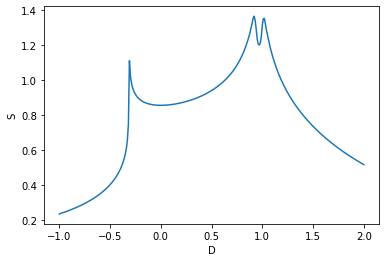

In [20]:
entanglement_list = [np.average(psi.entanglement_entropy()) for psi in psi_list]
n = len(psi_list)
plt.plot(D_list[:n], entanglement_list)
plt.xlabel('D')
plt.ylabel('S')

Text(0, 0.5, '$\\xi$')

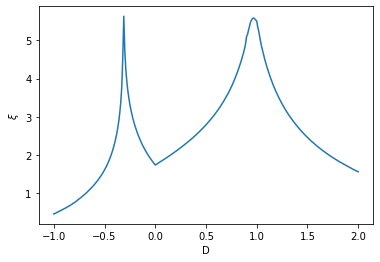

In [21]:
correlation_list = [np.log(psi.correlation_length()) for psi in psi_list]
n = len(psi_list)
plt.plot(D_list[:n], correlation_list)
plt.xlabel('D')
plt.ylabel(r'$\xi$')

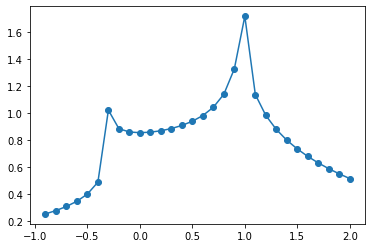

In [45]:
n = len(psi_list)
plt.plot(D_list[1:], entanglement_list, 'o-')

# Create the Unitary Transformation

In [24]:
import tenpy.linalg.np_conserved as npc

In [57]:
s = SpinSite(S=1, conserve=None)
Uz = npc.expm(1.j * np.pi * s.get_op('Sx'))
Uz.to_ndarray()

array([[ 2.76424704e-32+0.00000000e+00j,  0.00000000e+00+8.54725382e-17j,
        -1.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+1.66260249e-16j, -1.00000000e+00+0.00000000e+00j,
         0.00000000e+00+2.07825311e-16j],
       [-1.00000000e+00+0.00000000e+00j,  0.00000000e+00+2.47047960e-16j,
         3.08809950e-17+0.00000000e+00j]])

In [36]:
Uz

<npc.Array shape=(3, 3) charge=ChargeInfo([], []) labels=['p', 'p*']>

In [31]:
Uz.to_ndarray()

array([[-1.-1.2246468e-16j,  0.+0.0000000e+00j,  0.+0.0000000e+00j],
       [ 0.+0.0000000e+00j,  1.+0.0000000e+00j,  0.+0.0000000e+00j],
       [ 0.+0.0000000e+00j,  0.+0.0000000e+00j, -1.+1.2246468e-16j]])

In [52]:
Uz = npc.expm(1.j * (np.pi / 2.) * SpinHalfSite(conserve=None).get_op('Sigmaz'))
Uz.to_ndarray()

array([[0.+1.j, 0.+0.j],
       [0.+0.j, 0.-1.j]])

# Calculate the detector of D2

In [40]:
from tenpy.networks.mps import TransferMatrix

In [41]:
def detect_SPT_D2(psi):
    
    op_list = ['Sx', 'Sz']
    U_list = []
    
    for op in op_list:
        
        s = SpinSite(S=1, conserve=None)
        u_op = npc.expm(1.j * np.pi * s.get_op(op))
        
        # First of all, save a copy of the input wavefunction psi
        psi_copy = psi.copy()
        for i in range(psi_copy.L):
            psi_copy.apply_local_op(i, u_op)
        
        TM = TransferMatrix(psi, psi_copy)
        eta, G = TM.eigenvectors(num_ev=1)
#         if not np.allclose(eta, 1):
#             print(f'eta={eta}')
#             raise ValueError('The largest eigenvalue of the transfer matrix is not 1!')
        if not np.allclose(np.abs(eta), 1, atol=0.01):
            return 0
        
        U = G[0]
        Uop = U.split_legs()
        chi=(Uop.shape[0])
        Uop *= np.sqrt(chi) # rescale it
        U_list.append(Uop)

    U1 = U_list[0]
    U2 = U_list[1]
    U12 = npc.tensordot(U1, U2, axes=([1], [0]))
    U21 = npc.tensordot(U2, U1, axes=([1], [0]))
    return npc.inner(U12, U21.conj()) / chi

In [152]:
def detect_SPT_spatial_inv(psi, Op='inversion'):
    
    psi_original = psi.copy()
    psi_original.convert_form('B')
    
    # create a copy of the wavefunction in form B. Only for a gaurantee. It should be of form B by defaultcalcu
    psi_copy = psi.copy()
    psi_copy.convert_form('B')
    
    if Op=='inversion': # apply the spatial inversion op to the wavefunction
        psi_inv = psi_copy.spatial_inversion() #Form spatial reflection of the WF
    elif Op=='time_reversal': # apply the time reversal op to the wavefunction
        psi_inv = psi_copy.copy()
        for i in range(psi_inv.L):
            t=psi_inv.get_B(i).copy()
            
            for array in t:
                array_list = list(array)
                array_list[0] = np.conj(array_list[0])
                array = tuple(array_list)
            psi_inv.set_B(i, t)
    
    # create the transfer matrix corresponding to the original wavefunction and the tranformed wavefunction
    TM = TransferMatrix(psi_inv, psi_original)
    
    # calculate the largest eigenvalue and the corresponding eigenvector
    eta, G = TM.eigenvectors(num_ev=1)

    # if eta, i.e. the largest eigenvalue is not 1 (not close enough to 1)
    if not np.allclose(np.abs(eta), 1, atol=0.01):
        print("Not Symmetric under the Spatial Inversion. Eta = ", eta)
        return 0
    
    U = G[0]
    Uop = U.split_legs() # this is necessary for TeNPy, or we cannot get the matrix but a vector
    chi=(Uop.shape[0])
    Uop *= np.sqrt(chi) # rescale it
    return npc.inner(U, U.conj())

In [43]:
detector_list = [detect_SPT_D2(psi.copy()) for psi in psi_list]

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/py

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/py

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/py

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/py

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/py

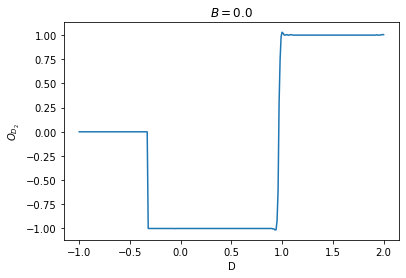

In [75]:
plt.plot(D_list, detector_list) 
plt.xlabel('D')
plt.ylabel(r'$O_{D_2}$')
plt.title(r'$B=0.0$')
plt.show()

In [166]:
detector_list_space_inv = [detect_SPT_spatial_inv(psi.copy(), Op='inversion') for psi in psi_list]


Not Symmetric under the Spatial Inversion. Eta =  [0.54586081-4.36540452e-16j]
Not Symmetric under the Spatial Inversion. Eta =  [0.54974579+7.10830049e-17j]
Not Symmetric under the Spatial Inversion. Eta =  [0.55391847-8.28127172e-17j]
Not Symmetric under the Spatial Inversion. Eta =  [0.55837265+6.24500451e-17j]
Not Symmetric under the Spatial Inversion. Eta =  [0.56233288+2.54614716e-16j]
Not Symmetric under the Spatial Inversion. Eta =  [0.56709065+3.97183913e-16j]
Not Symmetric under the Spatial Inversion. Eta =  [0.5713704-1.04837268e-17j]
Not Symmetric under the Spatial Inversion. Eta =  [0.57578343+3.20761213e-16j]
Not Symmetric under the Spatial Inversion. Eta =  [0.58001537+2.95174041e-16j]
Not Symmetric under the Spatial Inversion. Eta =  [0.58493748-3.25382624e-16j]
Not Symmetric under the Spatial Inversion. Eta =  [0.58940292-1.52335593e-16j]
Not Symmetric under the Spatial Inversion. Eta =  [0.59399005-2.48936207e-16j]
Not Symmetric under the Spatial Inversion. Eta =  [0.

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/py

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/py

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/py

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/py

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/py

/home/jerry/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(-1.1, 1.1)

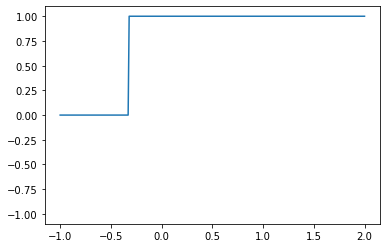

In [167]:
plt.plot(D_list, detector_list_space_inv)
plt.ylim(bottom=-1.1, top=1.1)

# Generate the data `B=0.3`

In [58]:
psi_list_B_3 = []
result_list_B_3 = []

In [59]:
J = 1.0
B = 0.3
D_list = linspace(-1.0, 2.0, 301)

In [60]:
chi = 128
chi_list = [4, 8, 16, 32, 64, 128]

# preparation part: we prepare the initial iMPS from the point (J, B, D) = (1, 0.3, -1)
initial_psi = None
D = -1.0
for chi in chi_list:
    result = run_atomic(J=J, B=B, D=D, chi=chi, initial_psi=initial_psi)
    psi = result['psi']
    initial_psi = psi.copy()
    
# real simulation part: here we start to sweep from D=-1 to D=2
for D in D_list:
    result = run_atomic(J=J, B=B, D=D, chi=chi, initial_psi=initial_psi)
    psi = result['psi']
    psi_list_B_3.append(psi.copy())
    result_list_B_3.append(result.copy())
    initial_psi = psi.copy()

Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.3 for config Spin1HaldaneModel
Reading 'D'=-1.0 for config Spin1HaldaneModel


==============================START==============================
Chi =  4 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Updating environment
.....
sweep 10, age = 200
Energy = -2.2211081656963572, S = nan, norm_err = 4.5e-14
Current memory usage 765.9 MB, time elapsed: 0.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.4588e-04, max_E_trunc = 1.0549e-03
MPS bond dimensions: [4, 4]
Updating environment
.....
sweep 20, age = 320
Energy = -2.2211081656963927, S = nan, norm_err = 4.2e-14
Current memory usage 765.9 MB, time elapsed: 1.7 s
Delta E = -3.5527e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.4588e-04, max_E_trunc = 1.0549e-03
MPS bond dimensions: [4, 4]
Convergence criterium reached with enabled mixer.
disable mixer and continue
Updating environment
.....
sweep 30, age = 440
Energy = -2.2211081656965348, S = 0.2210233180028727, norm_err = 4.4e-14
Current memory usage 765.9 MB, time elapsed: 2.1 s
Delta E = -1.4211e-14, Delta S = nan (per sweep)
max_trunc_err = 1.7294e-04, max_E_trunc = 1.0549e-03
MPS bond dimensions: [4, 4]
Updating environment
.....
sweep 40, age = 5

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['P_tol'] for config lanczos_params

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.2222773264496780, S = nan, norm_err = 9.6e-14
Current memory usage 765.9 MB, time elapsed: 1.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.7694e-07, max_E_trunc = 3.1686e-06
MPS bond dimensions: [8, 8]
Updating environment
.....
sweep 20, age = 320
Energy = -2.2222773233320368, S = nan, norm_err = 2.4e-14
Current memory usage 765.9 MB, time elapsed: 2.7 s
Delta E = 3.1176e-10, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.6873e-07, max_E_trunc = 3.1632e-06
MPS bond dimensions: [8, 8]
Convergence criterium reached with enabled mixer.
disable mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Updating environment
.....
sweep 10, age = 200
Energy = -2.2222807102583175, S = nan, norm_err = 1.9e-14
Current memory usage 765.9 MB, time elapsed: 1.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1719e-08, max_E_trunc = 4.8908e-08
MPS bond dimensions: [16, 16]
Updating environment
.....
sweep 20, age = 320
Energy = -2.2222807102626803, S = nan, norm_err = 6.3e-15
Current memory usage 765.9 MB, time elapsed: 2.9 s
Delta E = -4.3627e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1623e-08, max_E_trunc = 4.8797e-08
MPS bond dimensions: [16, 16]
Convergence criterium reached with enabled mixer.
disable mixer and continue
Updating environment
.....
sweep 30, age = 440
Energy = -2.2222807102629218, S = 0.2307215900908700, norm_err = 6.3e-15
Current memory usage 765.9 MB, time elapsed: 3.5 s
Delta E = -2.4158e-14, Delta S = nan (per sweep)
max_trunc_err = 5.8113e-09, max_E_trunc = 4.8800e-08
MPS bond dimensions: [16, 16]
Updating environment
.....
sweep 40, a

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Updating environment
.....
sweep 10, age = 200
Energy = -2.2222807597696743, S = nan, norm_err = 1.6e-15
Current memory usage 765.9 MB, time elapsed: 1.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.9105e-12, max_E_trunc = 4.6271e-11
MPS bond dimensions: [32, 32]
Updating environment
.....
sweep 20, age = 320
Energy = -2.2222807597697170, S = nan, norm_err = 3.1e-15
Current memory usage 765.9 MB, time elapsed: 3.1 s
Delta E = -4.2633e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.8464e-12, max_E_trunc = 4.6725e-11
MPS bond dimensions: [32, 32]
Convergence criterium reached with enabled mixer.
disable mixer and continue
Updating environment
.....
sweep 30, age = 440
Energy = -2.2222807597693901, S = 0.2307245996881656, norm_err = 1.4e-15
Current memory usage 765.9 MB, time elapsed: 3.9 s
Delta E = 3.2685e-14, Delta S = nan (per sweep)
max_trunc_err = 4.9233e-12, max_E_trunc = 4.5702e-11
MPS bond dimensions: [32, 32]
Updating environment
.....
sweep 40, ag

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Updating environment
.....
sweep 10, age = 200
Energy = -2.2222807598153196, S = nan, norm_err = 2.0e-15
Current memory usage 765.9 MB, time elapsed: 2.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4011e-14, max_E_trunc = 9.0949e-13
MPS bond dimensions: [64, 64]
Updating environment
.....
sweep 20, age = 320
Energy = -2.2222807598154759, S = nan, norm_err = 1.9e-15
Current memory usage 765.9 MB, time elapsed: 5.4 s
Delta E = -1.5632e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4073e-14, max_E_trunc = 1.3642e-12
MPS bond dimensions: [64, 64]
Convergence criterium reached with enabled mixer.
disable mixer and continue
Updating environment
.....
sweep 30, age = 440
Energy = -2.2222807598149927, S = 0.2307246051430282, norm_err = 7.7e-16
Current memory usage 765.9 MB, time elapsed: 7.0 s
Delta E = 4.8317e-14, Delta S = nan (per sweep)
max_trunc_err = 6.8583e-15, max_E_trunc = 1.1369e-12
MPS bond dimensions: [64, 64]
Updating environment
.....
sweep 40, ag

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.2222807598155185, S = nan, norm_err = 3.9e-15
Current memory usage 767.5 MB, time elapsed: 9.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.6291e-18, max_E_trunc = 9.0949e-13
MPS bond dimensions: [81, 79]
Updating environment
.....
sweep 20, age = 320
Energy = -2.2222807598158170, S = nan, norm_err = 3.6e-15
Current memory usage 770.1 MB, time elapsed: 23.6 s
Delta E = -2.9843e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.5652e-18, max_E_trunc = 1.3642e-12
MPS bond dimensions: [81, 79]
Convergence criterium reached with enabled mixer.
dis

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.2222807598153977, S = nan, norm_err = 3.4e-15
Current memory usage 770.1 MB, time elapsed: 9.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.0696e-18, max_E_trunc = 3.4106e-13
MPS bond dimensions: [82, 82]
Updating environment
.....
sweep 20, age = 320
Energy = -2.2222807598153054, S = nan, norm_err = 3.5e-15
Current memory usage 770.1 MB, time elapsed: 23.3 s
Delta E = 9.2371e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.4102e-18, max_E_trunc = 4.5475e-13
MPS bond dimensions: [82, 82]
Convergence criterium reached with enabled mixer.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.2132274262063660, S = nan, norm_err = 2.9e-15
Current memory usage 770.1 MB, time elapsed: 9.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.6404e-18, max_E_trunc = -1.1369e-13
MPS bond dimensions: [80, 81]
Updating environment
.....
sweep 20, age = 320
Energy = -2.2132274262064300, S = nan, norm_err = 4.3e-15
Current memory usage 770.1 MB, time elapsed: 22.8 s
Delta E = -6.3949e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.7947e-18, max_E_trunc = 1.1369e-12
MPS bond dimensions: [83, 80]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.2041825440740084, S = nan, norm_err = 3.1e-15
Current memory usage 770.1 MB, time elapsed: 9.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.0285e-18, max_E_trunc = 1.3642e-12
MPS bond dimensions: [83, 83]
Updating environment
.....
sweep 20, age = 320
Energy = -2.2041825440742144, S = nan, norm_err = 2.6e-15
Current memory usage 770.1 MB, time elapsed: 23.0 s
Delta E = -2.0606e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.4968e-18, max_E_trunc = -2.2737e-13
MPS bond dimensions: [80, 83]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.1951462341196404, S = nan, norm_err = 2.7e-15
Current memory usage 770.1 MB, time elapsed: 9.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.1473e-18, max_E_trunc = 3.9790e-13
MPS bond dimensions: [82, 84]
Updating environment
.....
sweep 20, age = 320
Energy = -2.1951462341196901, S = nan, norm_err = 3.2e-15
Current memory usage 770.2 MB, time elapsed: 22.6 s
Delta E = -4.9738e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.8400e-18, max_E_trunc = 6.8212e-13
MPS bond dimensions: [84, 87]
Convergence criterium reached with enabled mixer.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.1861186195507258, S = nan, norm_err = 3.4e-15
Current memory usage 772.2 MB, time elapsed: 9.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.7960e-18, max_E_trunc = 3.9790e-13
MPS bond dimensions: [80, 86]
Updating environment
.....
sweep 20, age = 320
Energy = -2.1861186195508253, S = nan, norm_err = 3.4e-15
Current memory usage 774.6 MB, time elapsed: 22.5 s
Delta E = -9.9476e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.4444e-18, max_E_trunc = -3.4106e-13
MPS bond dimensions: [84, 85]
Convergence criterium reached with enabled mixer

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.1770998261511991, S = nan, norm_err = 3.8e-15
Current memory usage 774.6 MB, time elapsed: 9.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.9224e-18, max_E_trunc = 3.4106e-13
MPS bond dimensions: [83, 85]
Updating environment
.....
sweep 20, age = 320
Energy = -2.1770998261515473, S = nan, norm_err = 4.3e-15
Current memory usage 774.6 MB, time elapsed: 22.7 s
Delta E = -3.4817e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.9967e-18, max_E_trunc = -1.1369e-13
MPS bond dimensions: [83, 83]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.1680899823576993, S = nan, norm_err = 4.5e-15
Current memory usage 774.6 MB, time elapsed: 9.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.3550e-18, max_E_trunc = 1.1369e-13
MPS bond dimensions: [84, 87]
Updating environment
.....
sweep 20, age = 320
Energy = -2.1680899823577278, S = nan, norm_err = 3.0e-15
Current memory usage 774.6 MB, time elapsed: 22.7 s
Delta E = -2.8422e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1433e-17, max_E_trunc = 0.0000e+00
MPS bond dimensions: [88, 87]
Convergence criterium reached with enabled mixer

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.1590892193356410, S = nan, norm_err = 3.7e-15
Current memory usage 774.6 MB, time elapsed: 9.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.8085e-18, max_E_trunc = 1.7053e-13
MPS bond dimensions: [84, 88]
Updating environment
.....
sweep 20, age = 320
Energy = -2.1590892193356410, S = nan, norm_err = 3.4e-15
Current memory usage 774.6 MB, time elapsed: 22.6 s
Delta E = 0.0000e+00, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3437e-17, max_E_trunc = 1.1369e-13
MPS bond dimensions: [89, 87]
Convergence criterium reached with enabled mixer.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.1500976710599531, S = nan, norm_err = 3.0e-15
Current memory usage 774.6 MB, time elapsed: 9.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2239e-17, max_E_trunc = 3.9790e-13
MPS bond dimensions: [86, 88]
Updating environment
.....
sweep 20, age = 320
Energy = -2.1500976710599105, S = nan, norm_err = 4.2e-15
Current memory usage 774.6 MB, time elapsed: 22.9 s
Delta E = 4.2633e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3599e-17, max_E_trunc = 4.5475e-13
MPS bond dimensions: [85, 88]
Convergence criterium reached with enabled mixer.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.1411154743991787, S = nan, norm_err = 4.0e-15
Current memory usage 774.6 MB, time elapsed: 9.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3283e-17, max_E_trunc = 2.2737e-13
MPS bond dimensions: [87, 89]
Updating environment
.....
sweep 20, age = 320
Energy = -2.1411154743989869, S = nan, norm_err = 2.2e-15
Current memory usage 774.6 MB, time elapsed: 23.2 s
Delta E = 1.9185e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5542e-17, max_E_trunc = -5.6843e-13
MPS bond dimensions: [90, 87]
Convergence criterium reached with enabled mixer

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.1321427692029147, S = nan, norm_err = 4.5e-15
Current memory usage 774.6 MB, time elapsed: 9.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3577e-17, max_E_trunc = 5.1159e-13
MPS bond dimensions: [89, 89]
Updating environment
.....
sweep 20, age = 320
Energy = -2.1321427692027726, S = nan, norm_err = 2.0e-15
Current memory usage 774.6 MB, time elapsed: 23.1 s
Delta E = 1.4211e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9078e-17, max_E_trunc = 2.3874e-12
MPS bond dimensions: [87, 88]
Convergence criterium reached with enabled mixer.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.1231796983903592, S = nan, norm_err = 3.5e-15
Current memory usage 774.6 MB, time elapsed: 9.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.6055e-17, max_E_trunc = 0.0000e+00
MPS bond dimensions: [89, 89]
Updating environment
.....
sweep 20, age = 320
Energy = -2.1231796983902598, S = nan, norm_err = 2.7e-15
Current memory usage 774.6 MB, time elapsed: 23.0 s
Delta E = 9.9476e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.0201e-17, max_E_trunc = 0.0000e+00
MPS bond dimensions: [87, 92]
Convergence criterium reached with enabled mixer.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.1142264080465125, S = nan, norm_err = 3.0e-15
Current memory usage 775.2 MB, time elapsed: 9.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.1052e-17, max_E_trunc = 3.9790e-13
MPS bond dimensions: [88, 89]
Updating environment
.....
sweep 20, age = 320
Energy = -2.1142264080465480, S = nan, norm_err = 2.9e-15
Current memory usage 775.5 MB, time elapsed: 22.3 s
Delta E = -3.5527e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.3410e-17, max_E_trunc = -1.1369e-13
MPS bond dimensions: [90, 90]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.1052830475185047, S = nan, norm_err = 3.9e-15
Current memory usage 777.9 MB, time elapsed: 9.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.1810e-17, max_E_trunc = -1.1369e-13
MPS bond dimensions: [90, 91]
Updating environment
.....
sweep 20, age = 320
Energy = -2.1052830475186255, S = nan, norm_err = 3.1e-15
Current memory usage 777.9 MB, time elapsed: 22.4 s
Delta E = -1.2079e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.6010e-17, max_E_trunc = 1.1369e-12
MPS bond dimensions: [89, 90]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.0963497695184046, S = nan, norm_err = 2.6e-15
Current memory usage 779.8 MB, time elapsed: 9.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.4822e-17, max_E_trunc = 2.8422e-13
MPS bond dimensions: [90, 91]
Updating environment
.....
sweep 20, age = 320
Energy = -2.0963497695184117, S = nan, norm_err = 2.5e-15
Current memory usage 780.2 MB, time elapsed: 22.7 s
Delta E = -7.1054e-16, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.9339e-17, max_E_trunc = 7.9581e-13
MPS bond dimensions: [90, 90]
Convergence criterium reached with enabled mixer

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.0874267302290264, S = nan, norm_err = 4.0e-15
Current memory usage 782.1 MB, time elapsed: 9.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.7504e-17, max_E_trunc = 5.1159e-13
MPS bond dimensions: [95, 94]
Updating environment
.....
sweep 20, age = 320
Energy = -2.0874267302291258, S = nan, norm_err = 2.6e-15
Current memory usage 782.6 MB, time elapsed: 22.2 s
Delta E = -9.9476e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.2856e-17, max_E_trunc = 2.2737e-13
MPS bond dimensions: [92, 93]
Convergence criterium reached with enabled mixer

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.0785140894151866, S = nan, norm_err = 2.7e-15
Current memory usage 782.6 MB, time elapsed: 9.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.1934e-17, max_E_trunc = 6.8212e-13
MPS bond dimensions: [91, 95]
Updating environment
.....
sweep 20, age = 320
Energy = -2.0785140894151795, S = nan, norm_err = 3.5e-15
Current memory usage 784.9 MB, time elapsed: 22.4 s
Delta E = 7.1054e-16, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.0339e-17, max_E_trunc = 0.0000e+00
MPS bond dimensions: [91, 92]
Convergence criterium reached with enabled mixer.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.0696120105380373, S = nan, norm_err = 4.3e-15
Current memory usage 786.9 MB, time elapsed: 10.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.7215e-17, max_E_trunc = 2.2737e-13
MPS bond dimensions: [94, 93]
Updating environment
.....
sweep 20, age = 320
Energy = -2.0696120105379805, S = nan, norm_err = 3.7e-15
Current memory usage 786.9 MB, time elapsed: 22.3 s
Delta E = 5.6843e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.2764e-17, max_E_trunc = -5.6843e-13
MPS bond dimensions: [94, 94]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.0607206608762141, S = nan, norm_err = 5.4e-15
Current memory usage 787.1 MB, time elapsed: 9.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.0596e-17, max_E_trunc = 0.0000e+00
MPS bond dimensions: [95, 94]
Updating environment
.....
sweep 20, age = 320
Energy = -2.0607206608757735, S = nan, norm_err = 3.1e-15
Current memory usage 787.8 MB, time elapsed: 22.3 s
Delta E = 4.4054e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.5180e-17, max_E_trunc = 2.2737e-13
MPS bond dimensions: [94, 95]
Convergence criterium reached with enabled mixer.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.0518402116515588, S = nan, norm_err = 3.9e-15
Current memory usage 798.0 MB, time elapsed: 10.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.7393e-17, max_E_trunc = 2.2737e-13
MPS bond dimensions: [95, 96]
Updating environment
.....
sweep 20, age = 320
Energy = -2.0518402116514665, S = nan, norm_err = 2.3e-15
Current memory usage 798.0 MB, time elapsed: 22.4 s
Delta E = 9.2371e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.1259e-17, max_E_trunc = 2.2737e-13
MPS bond dimensions: [94, 93]
Convergence criterium reached with enabled mixer

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.0429708381598886, S = nan, norm_err = 3.2e-15
Current memory usage 798.0 MB, time elapsed: 10.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.5440e-17, max_E_trunc = 1.1369e-13
MPS bond dimensions: [95, 95]
Updating environment
.....
sweep 20, age = 320
Energy = -2.0429708381600165, S = nan, norm_err = 2.6e-15
Current memory usage 798.0 MB, time elapsed: 22.6 s
Delta E = -1.2790e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.9457e-17, max_E_trunc = 6.8212e-13
MPS bond dimensions: [98, 93]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.0341127199089826, S = nan, norm_err = 4.5e-15
Current memory usage 798.0 MB, time elapsed: 11.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.4086e-17, max_E_trunc = 4.5475e-13
MPS bond dimensions: [96, 95]
Updating environment
.....
sweep 20, age = 320
Energy = -2.0341127199087481, S = nan, norm_err = 4.3e-15
Current memory usage 798.0 MB, time elapsed: 24.0 s
Delta E = 2.3448e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.2352e-17, max_E_trunc = 4.5475e-13
MPS bond dimensions: [99, 97]
Convergence criterium reached with enabled mixer

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.0252660407595187, S = nan, norm_err = 4.7e-15
Current memory usage 798.0 MB, time elapsed: 10.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.9306e-17, max_E_trunc = 6.8212e-13
MPS bond dimensions: [97, 98]
Updating environment
.....
sweep 20, age = 320
Energy = -2.0252660407597318, S = nan, norm_err = 3.0e-15
Current memory usage 798.0 MB, time elapsed: 23.2 s
Delta E = -2.1316e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.7320e-17, max_E_trunc = 4.5475e-13
MPS bond dimensions: [98, 98]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.0164309890773566, S = nan, norm_err = 4.4e-15
Current memory usage 800.4 MB, time elapsed: 10.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.8120e-17, max_E_trunc = 6.2528e-13
MPS bond dimensions: [95, 99]
Updating environment
.....
sweep 20, age = 320
Energy = -2.0164309890775343, S = nan, norm_err = 4.0e-15
Current memory usage 800.4 MB, time elapsed: 23.6 s
Delta E = -1.7764e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.1659e-17, max_E_trunc = 1.0232e-12
MPS bond dimensions: [98, 99]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -2.0076077578898435, S = nan, norm_err = 6.7e-15
Current memory usage 802.9 MB, time elapsed: 10.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.2022e-17, max_E_trunc = 3.9790e-13
MPS bond dimensions: [99, 100]
Updating environment
.....
sweep 20, age = 320
Energy = -2.0076077578896161, S = nan, norm_err = 3.9e-15
Current memory usage 802.9 MB, time elapsed: 23.9 s
Delta E = 2.2737e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.9344e-17, max_E_trunc = 1.1369e-13
MPS bond dimensions: [100, 100]
Convergence criterium reached with enabled 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.9987965450476111, S = nan, norm_err = 7.6e-15
Current memory usage 805.1 MB, time elapsed: 10.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0382e-16, max_E_trunc = 5.1159e-13
MPS bond dimensions: [102, 100]
Updating environment
.....
sweep 20, age = 320
Energy = -1.9987965450476537, S = nan, norm_err = 3.7e-15
Current memory usage 805.1 MB, time elapsed: 24.4 s
Delta E = -4.2633e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2352e-16, max_E_trunc = 4.5475e-13
MPS bond dimensions: [99, 100]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.9899975533995189, S = nan, norm_err = 1.3e-14
Current memory usage 807.1 MB, time elapsed: 11.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2575e-16, max_E_trunc = 7.3896e-13
MPS bond dimensions: [103, 101]
Updating environment
.....
sweep 20, age = 320
Energy = -1.9899975533995047, S = nan, norm_err = 3.2e-15
Current memory usage 807.1 MB, time elapsed: 24.9 s
Delta E = 1.4211e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3778e-16, max_E_trunc = 5.6843e-13
MPS bond dimensions: [104, 101]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.......
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.9812109909706876, S = nan, norm_err = 3.4e-14
Current memory usage 807.4 MB, time elapsed: 11.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4198e-16, max_E_trunc = 2.2737e-13
MPS bond dimensions: [103, 102]
Updating environment
.....
sweep 20, age = 320
Energy = -1.9812109909705669, S = nan, norm_err = 2.7e-15
Current memory usage 807.4 MB, time elapsed: 25.8 s
Delta E = 1.2079e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5087e-16, max_E_trunc = 3.4106e-13
MPS bond dimensions: [100, 101]
Convergence criterium reached with enabled 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.9724370711521431, S = nan, norm_err = 4.8e-14
Current memory usage 809.6 MB, time elapsed: 11.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.6301e-16, max_E_trunc = 2.2737e-13
MPS bond dimensions: [106, 101]
Updating environment
.....
sweep 20, age = 320
Energy = -1.9724370711522425, S = nan, norm_err = 4.3e-15
Current memory usage 809.6 MB, time elapsed: 26.1 s
Delta E = -9.9476e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.6442e-16, max_E_trunc = 4.5475e-13
MPS bond dimensions: [104, 103]
Convergence criterium reached with enable

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.9636760128982900, S = nan, norm_err = 6.2e-14
Current memory usage 814.0 MB, time elapsed: 11.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7805e-16, max_E_trunc = 3.4106e-13
MPS bond dimensions: [105, 102]
Updating environment
.....
sweep 20, age = 320
Energy = -1.9636760128988158, S = nan, norm_err = 4.1e-15
Current memory usage 814.0 MB, time elapsed: 26.2 s
Delta E = -5.2580e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9567e-16, max_E_trunc = 1.4779e-12
MPS bond dimensions: [104, 103]
Convergence criterium reached with enable

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.9549280409370127, S = nan, norm_err = 8.3e-14
Current memory usage 816.0 MB, time elapsed: 12.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9705e-16, max_E_trunc = 1.1369e-13
MPS bond dimensions: [104, 106]
Updating environment
.....
sweep 20, age = 320
Energy = -1.9549280409370198, S = nan, norm_err = 2.7e-15
Current memory usage 816.2 MB, time elapsed: 26.3 s
Delta E = -7.1054e-16, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.1922e-16, max_E_trunc = 2.2737e-13
MPS bond dimensions: [107, 104]
Convergence criterium reached with enable

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.9461933859851825, S = nan, norm_err = 9.8e-14
Current memory usage 818.6 MB, time elapsed: 12.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.3211e-16, max_E_trunc = 5.6843e-14
MPS bond dimensions: [105, 106]
Updating environment
.....
sweep 20, age = 320
Energy = -1.9461933859850831, S = nan, norm_err = 2.9e-15
Current memory usage 818.8 MB, time elapsed: 26.4 s
Delta E = 9.9476e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.7482e-16, max_E_trunc = 7.9581e-13
MPS bond dimensions: [106, 105]
Convergence criterium reached with enabled

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.9374722849807142, S = nan, norm_err = 1.3e-13
Current memory usage 822.7 MB, time elapsed: 12.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.6749e-16, max_E_trunc = 7.3896e-13
MPS bond dimensions: [106, 107]
Updating environment
.....
sweep 20, age = 320
Energy = -1.9374722849812258, S = nan, norm_err = 3.5e-15
Current memory usage 822.7 MB, time elapsed: 27.6 s
Delta E = -5.1159e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.8830e-16, max_E_trunc = 7.9581e-13
MPS bond dimensions: [107, 106]
Convergence criterium reached with enable

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.9287649813244769, S = nan, norm_err = 9.1e-14
Current memory usage 825.9 MB, time elapsed: 12.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.9580e-16, max_E_trunc = 1.0800e-12
MPS bond dimensions: [107, 110]
Updating environment
.....
sweep 20, age = 320
Energy = -1.9287649813245054, S = nan, norm_err = 3.4e-15
Current memory usage 825.9 MB, time elapsed: 26.6 s
Delta E = -2.8422e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.3897e-16, max_E_trunc = 2.3874e-12
MPS bond dimensions: [109, 109]
Convergence criterium reached with enable

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.9200717251332620, S = nan, norm_err = 1.2e-13
Current memory usage 830.9 MB, time elapsed: 12.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.8507e-16, max_E_trunc = 1.7053e-13
MPS bond dimensions: [109, 108]
Updating environment
.....
sweep 20, age = 320
Energy = -1.9200717251333401, S = nan, norm_err = 2.6e-15
Current memory usage 830.9 MB, time elapsed: 26.7 s
Delta E = -7.8160e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.7421e-16, max_E_trunc = 0.0000e+00
MPS bond dimensions: [111, 109]
Convergence criterium reached with enable

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.9113927735097249, S = nan, norm_err = 1.9e-13
Current memory usage 833.7 MB, time elapsed: 13.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.2333e-16, max_E_trunc = 5.6843e-14
MPS bond dimensions: [110, 113]
Updating environment
.....
sweep 20, age = 320
Energy = -1.9113927735097462, S = nan, norm_err = 2.8e-15
Current memory usage 833.7 MB, time elapsed: 27.5 s
Delta E = -2.1316e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.5049e-16, max_E_trunc = -1.1369e-13
MPS bond dimensions: [111, 113]
Convergence criterium reached with enabl

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.9027283908247838, S = nan, norm_err = 2.9e-13
Current memory usage 844.2 MB, time elapsed: 12.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.0487e-16, max_E_trunc = 6.8212e-13
MPS bond dimensions: [112, 113]
Updating environment
.....
sweep 20, age = 320
Energy = -1.9027283908245920, S = nan, norm_err = 4.0e-15
Current memory usage 844.2 MB, time elapsed: 27.0 s
Delta E = 1.9185e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.0545e-16, max_E_trunc = -1.1369e-13
MPS bond dimensions: [112, 113]
Convergence criterium reached with enable

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.8940788490147185, S = nan, norm_err = 3.6e-13
Current memory usage 844.2 MB, time elapsed: 12.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.7921e-16, max_E_trunc = 1.1369e-13
MPS bond dimensions: [114, 116]
Updating environment
.....
sweep 20, age = 320
Energy = -1.8940788490149885, S = nan, norm_err = 5.1e-15
Current memory usage 844.2 MB, time elapsed: 26.6 s
Delta E = -2.7001e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.9685e-16, max_E_trunc = 2.2737e-13
MPS bond dimensions: [113, 114]
Convergence criterium reached with enable

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.8854444278993583, S = nan, norm_err = 4.7e-13
Current memory usage 845.1 MB, time elapsed: 13.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.2091e-16, max_E_trunc = 5.6843e-14
MPS bond dimensions: [116, 116]
Updating environment
.....
sweep 20, age = 320
Energy = -1.8854444278990456, S = nan, norm_err = 2.6e-15
Current memory usage 845.1 MB, time elapsed: 26.9 s
Delta E = 3.1264e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.2084e-16, max_E_trunc = 5.6843e-13
MPS bond dimensions: [116, 113]
Convergence criterium reached with enabled

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.8768254155113766, S = nan, norm_err = 8.6e-14
Current memory usage 851.9 MB, time elapsed: 13.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.6529e-16, max_E_trunc = 5.6843e-14
MPS bond dimensions: [116, 115]
Updating environment
.....
sweep 20, age = 320
Energy = -1.8768254155115187, S = nan, norm_err = 3.7e-15
Current memory usage 851.9 MB, time elapsed: 26.5 s
Delta E = -1.4211e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.2796e-16, max_E_trunc = -1.1369e-13
MPS bond dimensions: [118, 116]
Convergence criterium reached with enabl

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.8682221084528550, S = nan, norm_err = 1.1e-13
Current memory usage 856.2 MB, time elapsed: 13.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.3442e-16, max_E_trunc = 5.1159e-13
MPS bond dimensions: [117, 116]
Updating environment
.....
sweep 20, age = 320
Energy = -1.8682221084527271, S = nan, norm_err = 4.3e-15
Current memory usage 856.2 MB, time elapsed: 26.6 s
Delta E = 1.2790e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.2397e-16, max_E_trunc = -4.5475e-13
MPS bond dimensions: [115, 117]
Convergence criterium reached with enable

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.8596348122654831, S = nan, norm_err = 1.4e-13
Current memory usage 859.4 MB, time elapsed: 13.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0228e-15, max_E_trunc = 1.1937e-12
MPS bond dimensions: [121, 118]
Updating environment
.....
sweep 20, age = 320
Energy = -1.8596348122659236, S = nan, norm_err = 3.7e-15
Current memory usage 859.4 MB, time elapsed: 27.2 s
Delta E = -4.4054e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0745e-15, max_E_trunc = 1.1369e-12
MPS bond dimensions: [121, 119]
Convergence criterium reached with enable

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.8510638418283918, S = nan, norm_err = 1.9e-13
Current memory usage 864.2 MB, time elapsed: 13.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2853e-15, max_E_trunc = -1.1369e-13
MPS bond dimensions: [122, 121]
Updating environment
.....
sweep 20, age = 320
Energy = -1.8510638418282639, S = nan, norm_err = 5.0e-15
Current memory usage 864.2 MB, time elapsed: 27.2 s
Delta E = 1.2790e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3297e-15, max_E_trunc = 1.5916e-12
MPS bond dimensions: [123, 121]
Convergence criterium reached with enabl

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.8425095217753338, S = nan, norm_err = 1.9e-12
Current memory usage 870.1 MB, time elapsed: 13.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3970e-15, max_E_trunc = 3.4106e-13
MPS bond dimensions: [121, 124]
Updating environment
.....
sweep 20, age = 320
Energy = -1.8425095217752130, S = nan, norm_err = 3.1e-15
Current memory usage 870.1 MB, time elapsed: 27.7 s
Delta E = 1.2079e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5305e-15, max_E_trunc = 1.5916e-12
MPS bond dimensions: [126, 123]
Convergence criterium reached with enable

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.8339721869427450, S = nan, norm_err = 2.8e-12
Current memory usage 875.2 MB, time elapsed: 14.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7296e-15, max_E_trunc = 3.4106e-13
MPS bond dimensions: [124, 124]
Updating environment
.....
sweep 20, age = 320
Energy = -1.8339721869426029, S = nan, norm_err = 3.5e-15
Current memory usage 875.2 MB, time elapsed: 28.1 s
Delta E = 1.4211e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.8156e-15, max_E_trunc = -2.8422e-13
MPS bond dimensions: [126, 125]
Convergence criterium reached with enabl

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.8254521828431578, S = nan, norm_err = 3.9e-12
Current memory usage 884.0 MB, time elapsed: 14.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9705e-15, max_E_trunc = 1.7053e-13
MPS bond dimensions: [126, 126]
Updating environment
.....
sweep 20, age = 320
Energy = -1.8254521828433354, S = nan, norm_err = 5.3e-15
Current memory usage 884.0 MB, time elapsed: 28.2 s
Delta E = -1.7764e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.0925e-15, max_E_trunc = 1.7053e-13
MPS bond dimensions: [126, 125]
Convergence criterium reached with enabl

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.8169498661702406, S = nan, norm_err = 5.7e-12
Current memory usage 884.9 MB, time elapsed: 14.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.3577e-15, max_E_trunc = 2.8422e-13
MPS bond dimensions: [128, 127]
Updating environment
.....
sweep 20, age = 320
Energy = -1.8169498661704608, S = nan, norm_err = 6.0e-15
Current memory usage 884.9 MB, time elapsed: 28.2 s
Delta E = -2.2027e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.4675e-15, max_E_trunc = 2.2737e-13
MPS bond dimensions: [127, 128]
Convergence criterium reached with enabl

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.8084656053341348, S = nan, norm_err = 7.6e-12
Current memory usage 893.7 MB, time elapsed: 14.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.8268e-15, max_E_trunc = 4.5475e-13
MPS bond dimensions: [126, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.8084656053344759, S = nan, norm_err = 1.2e-14
Current memory usage 893.7 MB, time elapsed: 28.5 s
Delta E = -3.4106e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.7728e-15, max_E_trunc = 2.8422e-13
MPS bond dimensions: [128, 127]
Convergence criterium reached with enabl

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.7999997810384798, S = nan, norm_err = 9.6e-12
Current memory usage 896.9 MB, time elapsed: 14.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.4277e-15, max_E_trunc = 2.2737e-13
MPS bond dimensions: [127, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.7999997810387640, S = nan, norm_err = 1.5e-14
Current memory usage 896.9 MB, time elapsed: 28.4 s
Delta E = -2.8422e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.4563e-15, max_E_trunc = 5.6843e-14
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabl

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.7915527868919696, S = nan, norm_err = 8.8e-13
Current memory usage 901.3 MB, time elapsed: 14.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.9776e-15, max_E_trunc = 6.2528e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.7915527868920123, S = nan, norm_err = 3.5e-14
Current memory usage 901.3 MB, time elapsed: 28.6 s
Delta E = -4.2633e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.3262e-15, max_E_trunc = 6.8212e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabl

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Before the canonicalization:
Bond dim =  [120, 121]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.999999999999998+2.211772431870429e-17j)
After the canonicalization:
Bond dim =  [120, 121]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.3 for config Spin1HaldaneModel
Reading 'D'=-0.5 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Before the canonicalization:
Bond dim =  [121, 119]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.999999999999998-1.3042412151496744e-16j)
After the canonicalization:
Bond dim =  [121, 119]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.3 for config Spin1HaldaneModel
Reading 'D'=-0.49 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Readi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Before the canonicalization:
Bond dim =  [122, 122]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999964+2.261575355278246e-16j)
After the canonicalization:
Bond dim =  [122, 122]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.3 for config Spin1HaldaneModel
Reading 'D'=-0.48 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Readi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Before the canonicalization:
Bond dim =  [125, 123]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000049-6.297617965035206e-16j)
After the canonicalization:
Bond dim =  [125, 123]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.3 for config Spin1HaldaneModel
Reading 'D'=-0.47 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Readi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Before the canonicalization:
Bond dim =  [127, 127]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000049-1.734723475976807e-17j)
After the canonicalization:
Bond dim =  [127, 127]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.3 for config Spin1HaldaneModel
Reading 'D'=-0.46 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Readi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.7412900991369327, S = nan, norm_err = 6.6e-11
Current memory usage 934.4 MB, time elapsed: 15.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2856e-14, max_E_trunc = 1.0800e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.7412900991367053, S = nan, norm_err = 1.3e-13
Current memory usage 934.4 MB, time elapsed: 29.7 s
Delta E = 2.2737e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3041e-14, max_E_trunc = 9.0949e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.7329871718547167, S = nan, norm_err = 7.5e-11
Current memory usage 939.2 MB, time elapsed: 16.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5509e-14, max_E_trunc = 6.8212e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.7329871718547594, S = nan, norm_err = 1.8e-13
Current memory usage 939.2 MB, time elapsed: 30.7 s
Delta E = -4.2633e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5912e-14, max_E_trunc = 6.2528e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.7247067781398542, S = nan, norm_err = 3.2e-11
Current memory usage 943.0 MB, time elapsed: 16.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9589e-14, max_E_trunc = 6.8212e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.7247067781399608, S = nan, norm_err = 3.2e-14
Current memory usage 943.0 MB, time elapsed: 31.4 s
Delta E = -1.0658e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9500e-14, max_E_trunc = 1.7053e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.7164494640930457, S = nan, norm_err = 3.6e-10
Current memory usage 947.7 MB, time elapsed: 17.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.5127e-14, max_E_trunc = -5.6843e-14
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.7164494640931736, S = nan, norm_err = 3.2e-13
Current memory usage 948.3 MB, time elapsed: 32.2 s
Delta E = -1.2790e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.4478e-14, max_E_trunc = 1.0232e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.7082157981287409, S = nan, norm_err = 1.2e-10
Current memory usage 952.3 MB, time elapsed: 17.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.0331e-14, max_E_trunc = 8.5265e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.7082157981285775, S = nan, norm_err = 1.1e-12
Current memory usage 952.3 MB, time elapsed: 32.2 s
Delta E = 1.6342e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.9455e-14, max_E_trunc = 5.6843e-14
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.7000063724168442, S = nan, norm_err = 1.2e-10
Current memory usage 956.9 MB, time elapsed: 16.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.5414e-14, max_E_trunc = 2.8422e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.7000063724169365, S = nan, norm_err = 7.7e-12
Current memory usage 956.9 MB, time elapsed: 30.3 s
Delta E = -9.2371e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.7421e-14, max_E_trunc = 5.6843e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.6918218044730011, S = nan, norm_err = 3.4e-10
Current memory usage 961.1 MB, time elapsed: 16.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.4918e-14, max_E_trunc = 3.9790e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.6918218044728093, S = nan, norm_err = 1.6e-11
Current memory usage 961.1 MB, time elapsed: 30.4 s
Delta E = 1.9185e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.6352e-14, max_E_trunc = 9.0949e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.6836627389124743, S = nan, norm_err = 5.8e-10
Current memory usage 967.9 MB, time elapsed: 16.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.6547e-14, max_E_trunc = 6.8212e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.6836627389124459, S = nan, norm_err = 1.3e-11
Current memory usage 967.9 MB, time elapsed: 30.6 s
Delta E = 2.8422e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.8922e-14, max_E_trunc = 7.9581e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.6755298493980888, S = nan, norm_err = 9.8e-10
Current memory usage 974.5 MB, time elapsed: 17.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.1712e-14, max_E_trunc = 6.2528e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.6755298493980888, S = nan, norm_err = 6.0e-12
Current memory usage 974.5 MB, time elapsed: 31.2 s
Delta E = 0.0000e+00, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.5257e-14, max_E_trunc = 1.1937e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.6674238408153741, S = nan, norm_err = 1.8e-09
Current memory usage 979.3 MB, time elapsed: 17.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.4152e-14, max_E_trunc = 5.6843e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.6674238408154167, S = nan, norm_err = 1.1e-11
Current memory usage 979.3 MB, time elapsed: 31.5 s
Delta E = -4.2633e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.7560e-14, max_E_trunc = 1.1369e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.6593454517155592, S = nan, norm_err = 3.4e-09
Current memory usage 983.7 MB, time elapsed: 18.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2183e-13, max_E_trunc = 1.0516e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.6593454517155095, S = nan, norm_err = 8.4e-12
Current memory usage 983.7 MB, time elapsed: 32.7 s
Delta E = 4.9738e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2544e-13, max_E_trunc = 2.0464e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mixe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.6512954570845224, S = nan, norm_err = 6.7e-09
Current memory usage 988.2 MB, time elapsed: 18.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5807e-13, max_E_trunc = 1.0232e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.6512954570847853, S = nan, norm_err = 1.2e-11
Current memory usage 988.2 MB, time elapsed: 32.9 s
Delta E = -2.6290e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.6346e-13, max_E_trunc = 9.0949e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.6432746715047415, S = nan, norm_err = 2.1e-08
Current memory usage 992.8 MB, time elapsed: 20.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.0858e-13, max_E_trunc = 1.1653e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.6432746715052531, S = nan, norm_err = 1.8e-11
Current memory usage 992.8 MB, time elapsed: 35.6 s
Delta E = -5.1159e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.1661e-13, max_E_trunc = 1.3074e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.6352839528051462, S = nan, norm_err = 3.0e-08
Current memory usage 997.1 MB, time elapsed: 19.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.6941e-13, max_E_trunc = 1.3074e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.6352839528051604, S = nan, norm_err = 1.8e-11
Current memory usage 997.1 MB, time elapsed: 34.2 s
Delta E = -1.4211e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.8654e-13, max_E_trunc = 2.2737e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.6273242063221858, S = nan, norm_err = 7.0e-08
Current memory usage 1003.8 MB, time elapsed: 21.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.5402e-13, max_E_trunc = 2.0464e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.6273242063225553, S = nan, norm_err = 2.8e-11
Current memory usage 1003.8 MB, time elapsed: 36.1 s
Delta E = -3.6948e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.8288e-13, max_E_trunc = 1.8190e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.6193963899518096, S = nan, norm_err = 1.2e-07
Current memory usage 1008.5 MB, time elapsed: 21.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.6399e-13, max_E_trunc = 2.1600e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.6193963899523141, S = nan, norm_err = 1.9e-10
Current memory usage 1008.5 MB, time elapsed: 35.8 s
Delta E = -5.0449e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.1759e-13, max_E_trunc = 3.0695e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.6115015202262128, S = nan, norm_err = 2.3e-07
Current memory usage 1012.9 MB, time elapsed: 22.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.1923e-13, max_E_trunc = 2.3590e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.6115015202278755, S = nan, norm_err = 2.5e-10
Current memory usage 1012.9 MB, time elapsed: 36.9 s
Delta E = -1.6627e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.1435e-13, max_E_trunc = 3.4106e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.6036406797735552, S = nan, norm_err = 4.7e-07
Current memory usage 1017.2 MB, time elapsed: 23.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.2271e-13, max_E_trunc = 2.7285e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.6036406797787208, S = nan, norm_err = 9.9e-10
Current memory usage 1017.2 MB, time elapsed: 38.1 s
Delta E = -5.1656e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0084e-12, max_E_trunc = 4.4906e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.5958150266786433, S = nan, norm_err = 9.7e-07
Current memory usage 1021.6 MB, time elapsed: 24.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0966e-12, max_E_trunc = 4.0927e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.5958150266975863, S = nan, norm_err = 2.8e-09
Current memory usage 1021.6 MB, time elapsed: 39.2 s
Delta E = -1.8943e-12, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4484e-12, max_E_trunc = 5.4570e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.5880258065474635, S = nan, norm_err = 2.0e-06
Current memory usage 1026.5 MB, time elapsed: 26.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4729e-12, max_E_trunc = 5.9117e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.5880258066137714, S = nan, norm_err = 4.4e-08
Current memory usage 1026.5 MB, time elapsed: 47.5 s
Delta E = -6.6308e-12, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.1354e-12, max_E_trunc = 7.6170e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.5802743685190421, S = nan, norm_err = 4.2e-06
Current memory usage 1030.8 MB, time elapsed: 28.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.0042e-12, max_E_trunc = 7.5318e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.5802743687732033, S = nan, norm_err = 8.1e-08
Current memory usage 1030.8 MB, time elapsed: 49.5 s
Delta E = -2.5416e-11, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.1797e-12, max_E_trunc = 1.1710e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.5725621873185389, S = nan, norm_err = 9.0e-06
Current memory usage 1035.2 MB, time elapsed: 28.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.7423e-12, max_E_trunc = 9.8623e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.5725621882668648, S = nan, norm_err = 4.0e-08
Current memory usage 1035.2 MB, time elapsed: 44.0 s
Delta E = -9.4833e-11, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.8328e-12, max_E_trunc = 1.7110e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.5648908946373865, S = nan, norm_err = 1.9e-05
Current memory usage 1040.0 MB, time elapsed: 28.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.7335e-12, max_E_trunc = 1.3756e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.5648908982520027, S = nan, norm_err = 3.7e-07
Current memory usage 1040.0 MB, time elapsed: 50.8 s
Delta E = -3.6146e-10, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.9289e-12, max_E_trunc = 2.8820e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.5572623255648210, S = nan, norm_err = 4.0e-05
Current memory usage 1044.1 MB, time elapsed: 28.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.0726e-12, max_E_trunc = 1.7849e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.5572623395459573, S = nan, norm_err = 8.3e-07
Current memory usage 1044.1 MB, time elapsed: 51.2 s
Delta E = -1.3981e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3239e-11, max_E_trunc = 4.7351e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.5496785884106998, S = nan, norm_err = 8.6e-05
Current memory usage 1049.1 MB, time elapsed: 28.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.9466e-12, max_E_trunc = 2.5324e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.5496786428119336, S = nan, norm_err = 2.5e-06
Current memory usage 1049.1 MB, time elapsed: 51.1 s
Delta E = -5.4401e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.3348e-11, max_E_trunc = 8.7482e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.5421421674174951, S = nan, norm_err = 1.8e-04
Current memory usage 1053.6 MB, time elapsed: 28.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.5878e-12, max_E_trunc = 3.4106e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.5421423798311764, S = nan, norm_err = 1.6e-05
Current memory usage 1053.6 MB, time elapsed: 51.5 s
Delta E = -2.1241e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.2150e-11, max_E_trunc = 1.5984e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.5346560548075345, S = nan, norm_err = 3.7e-04
Current memory usage 1057.5 MB, time elapsed: 28.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3126e-11, max_E_trunc = 4.7692e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.5346568769477287, S = nan, norm_err = 7.3e-05
Current memory usage 1057.5 MB, time elapsed: 52.3 s
Delta E = -8.2214e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.4410e-11, max_E_trunc = 2.8132e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.5272238442743742, S = nan, norm_err = 7.4e-04
Current memory usage 1062.6 MB, time elapsed: 28.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7789e-11, max_E_trunc = 6.2983e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.5272268890654388, S = nan, norm_err = 3.3e-04
Current memory usage 1062.6 MB, time elapsed: 53.4 s
Delta E = -3.0448e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2869e-10, max_E_trunc = 4.9289e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.5198517219090846, S = nan, norm_err = 1.4e-03
Current memory usage 1067.1 MB, time elapsed: 28.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.6711e-11, max_E_trunc = 1.3915e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.5198597331407200, S = nan, norm_err = 1.1e-03
Current memory usage 1067.1 MB, time elapsed: 55.8 s
Delta E = -8.0112e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.3290e-10, max_E_trunc = 8.7027e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 8.96e-05
Call psi.canonical_form()
DMRG finished after 160 sweeps.
total size = 2200, maximum chi = 128
Before the canonicalization:
Bond dim =  [128, 128]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000038+2.3913342507706917e-16j)
After the canonicalization:
Bond dim =  [128, 128]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.3 for config Spin1HaldaneModel
Reading 'D'=-0.16 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subcon

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.5125691410112054, S = nan, norm_err = 2.3e-04
Current memory usage 1071.6 MB, time elapsed: 28.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.3558e-10, max_E_trunc = 1.6041e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.5125692443559231, S = nan, norm_err = 1.5e-04
Current memory usage 1071.6 MB, time elapsed: 52.0 s
Delta E = -1.0334e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.9085e-10, max_E_trunc = 3.1498e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.64e-05
Call psi.canonical_form()
DMRG finished after 40 sweeps.
total size = 760, maximum chi = 128
Before the canonicalization:
Bond dim =  [128, 128]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999911-7.813900114244602e-17j)
After the canonicalization:
Bond dim =  [128, 128]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.3 for config Spin1HaldaneModel
Reading 'D'=-0.15 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.5053258351910657, S = nan, norm_err = 7.5e-05
Current memory usage 1071.6 MB, time elapsed: 28.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.4373e-10, max_E_trunc = 9.3050e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.5053258866668529, S = nan, norm_err = 1.0e-05
Current memory usage 1071.6 MB, time elapsed: 51.1 s
Delta E = -5.1476e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.8974e-10, max_E_trunc = 1.7804e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.4981311162982465, S = nan, norm_err = 3.9e-05
Current memory usage 1081.0 MB, time elapsed: 28.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7535e-10, max_E_trunc = 6.6672e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.4981311339143843, S = nan, norm_err = 8.6e-07
Current memory usage 1081.0 MB, time elapsed: 44.3 s
Delta E = -1.7616e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.1574e-10, max_E_trunc = 1.1658e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.4909818533619159, S = nan, norm_err = 1.9e-05
Current memory usage 1086.7 MB, time elapsed: 28.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3674e-10, max_E_trunc = 5.2157e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.4909818585914465, S = nan, norm_err = 1.4e-06
Current memory usage 1086.7 MB, time elapsed: 51.5 s
Delta E = -5.2295e-10, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.2632e-10, max_E_trunc = 8.3901e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.4838756997903459, S = nan, norm_err = 8.9e-06
Current memory usage 1090.2 MB, time elapsed: 29.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0677e-10, max_E_trunc = 3.9807e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.4838757012805388, S = nan, norm_err = 4.4e-07
Current memory usage 1090.2 MB, time elapsed: 51.7 s
Delta E = -1.4902e-10, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.6245e-10, max_E_trunc = 6.0805e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.4768107728340212, S = nan, norm_err = 4.2e-06
Current memory usage 1094.5 MB, time elapsed: 28.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.4269e-11, max_E_trunc = 3.0298e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.4768107732524385, S = nan, norm_err = 2.2e-07
Current memory usage 1094.5 MB, time elapsed: 50.8 s
Delta E = -4.1842e-11, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1840e-10, max_E_trunc = 4.4304e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.4697855038069747, S = nan, norm_err = 1.9e-06
Current memory usage 1099.2 MB, time elapsed: 28.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.7660e-11, max_E_trunc = 2.3766e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.4697855039410115, S = nan, norm_err = 2.4e-09
Current memory usage 1099.2 MB, time elapsed: 43.5 s
Delta E = -1.3404e-11, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.6818e-11, max_E_trunc = 3.1497e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.4627985529757268, S = nan, norm_err = 9.1e-07
Current memory usage 1103.5 MB, time elapsed: 28.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.4254e-11, max_E_trunc = 1.8881e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.4627985530176204, S = nan, norm_err = 2.5e-09
Current memory usage 1103.5 MB, time elapsed: 43.5 s
Delta E = -4.1894e-12, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.2489e-11, max_E_trunc = 2.1703e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.4558487553580193, S = nan, norm_err = 4.2e-07
Current memory usage 1108.2 MB, time elapsed: 28.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.5491e-11, max_E_trunc = 1.5706e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.4558487553704680, S = nan, norm_err = 1.3e-09
Current memory usage 1108.2 MB, time elapsed: 43.3 s
Delta E = -1.2449e-12, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.9201e-11, max_E_trunc = 1.6968e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.4489350838140638, S = nan, norm_err = 2.0e-07
Current memory usage 1112.3 MB, time elapsed: 28.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.9460e-11, max_E_trunc = 1.3506e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.4489350838175383, S = nan, norm_err = 5.2e-10
Current memory usage 1112.3 MB, time elapsed: 43.4 s
Delta E = -3.4746e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.1228e-11, max_E_trunc = 1.4171e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.4420566228305489, S = nan, norm_err = 8.8e-08
Current memory usage 1116.9 MB, time elapsed: 27.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.4466e-11, max_E_trunc = 1.1892e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.4420566228317213, S = nan, norm_err = 2.3e-10
Current memory usage 1116.9 MB, time elapsed: 41.6 s
Delta E = -1.1724e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.5464e-11, max_E_trunc = 1.2255e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.4352125492213688, S = nan, norm_err = 3.8e-08
Current memory usage 1121.8 MB, time elapsed: 26.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.9629e-11, max_E_trunc = 1.0215e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.4352125492219869, S = nan, norm_err = 1.4e-10
Current memory usage 1121.8 MB, time elapsed: 40.9 s
Delta E = -6.1817e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.0125e-11, max_E_trunc = 1.0510e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.4284021174662342, S = nan, norm_err = 1.8e-08
Current memory usage 1126.2 MB, time elapsed: 26.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.5349e-11, max_E_trunc = 8.7539e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.4284021174664758, S = nan, norm_err = 1.1e-10
Current memory usage 1126.2 MB, time elapsed: 40.0 s
Delta E = -2.4158e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.5596e-11, max_E_trunc = 8.9585e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.4216246483039257, S = nan, norm_err = 1.5e-08
Current memory usage 1129.7 MB, time elapsed: 25.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.1700e-11, max_E_trunc = 7.5403e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.4216246483041104, S = nan, norm_err = 7.4e-11
Current memory usage 1129.7 MB, time elapsed: 39.5 s
Delta E = -1.8474e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.1816e-11, max_E_trunc = 7.6568e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.4148795196660586, S = nan, norm_err = 2.0e-08
Current memory usage 1135.0 MB, time elapsed: 25.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7985e-11, max_E_trunc = 6.5825e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.4148795196660160, S = nan, norm_err = 3.5e-11
Current memory usage 1135.0 MB, time elapsed: 39.0 s
Delta E = 4.2633e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.8056e-11, max_E_trunc = 6.5711e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.4081661593435157, S = nan, norm_err = 2.6e-08
Current memory usage 1139.5 MB, time elapsed: 23.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2296e-11, max_E_trunc = 4.7379e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.4081661593436223, S = nan, norm_err = 6.4e-12
Current memory usage 1139.5 MB, time elapsed: 37.6 s
Delta E = -1.0658e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2304e-11, max_E_trunc = 4.8544e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.4014840389435221, S = nan, norm_err = 3.3e-08
Current memory usage 1143.4 MB, time elapsed: 23.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.6549e-12, max_E_trunc = 2.7057e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.4014840389435221, S = nan, norm_err = 4.9e-12
Current memory usage 1143.4 MB, time elapsed: 37.8 s
Delta E = 0.0000e+00, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.5962e-12, max_E_trunc = 2.6830e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.3948326688461705, S = nan, norm_err = 2.2e-07
Current memory usage 1148.7 MB, time elapsed: 23.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1455e-11, max_E_trunc = 4.4821e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.3948326688465897, S = nan, norm_err = 4.0e-10
Current memory usage 1148.7 MB, time elapsed: 37.8 s
Delta E = -4.1922e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1540e-11, max_E_trunc = 4.5020e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.3882115941243995, S = nan, norm_err = 6.6e-08
Current memory usage 1152.7 MB, time elapsed: 24.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5991e-11, max_E_trunc = 6.0027e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.3882115941243285, S = nan, norm_err = 3.0e-12
Current memory usage 1152.7 MB, time elapsed: 38.1 s
Delta E = 7.1054e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.6020e-11, max_E_trunc = 6.0481e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.3816203908310527, S = nan, norm_err = 7.6e-08
Current memory usage 1156.3 MB, time elapsed: 23.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7950e-11, max_E_trunc = 6.4460e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.3816203908310456, S = nan, norm_err = 2.6e-12
Current memory usage 1156.3 MB, time elapsed: 37.7 s
Delta E = 7.1054e-16, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7943e-11, max_E_trunc = 6.4801e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.3750586629523838, S = nan, norm_err = 8.7e-08
Current memory usage 1162.1 MB, time elapsed: 23.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9188e-11, max_E_trunc = 6.8553e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.3750586629524690, S = nan, norm_err = 9.1e-12
Current memory usage 1162.1 MB, time elapsed: 37.9 s
Delta E = -8.5265e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9172e-11, max_E_trunc = 6.8951e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.3685260397883141, S = nan, norm_err = 1.0e-07
Current memory usage 1166.9 MB, time elapsed: 24.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.0237e-11, max_E_trunc = 7.2504e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.3685260397884420, S = nan, norm_err = 2.1e-11
Current memory usage 1166.9 MB, time elapsed: 38.2 s
Delta E = -1.2790e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.0217e-11, max_E_trunc = 7.2760e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.3620221736397014, S = nan, norm_err = 1.1e-07
Current memory usage 1171.4 MB, time elapsed: 24.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.1231e-11, max_E_trunc = 7.6625e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.3620221736400850, S = nan, norm_err = 3.8e-11
Current memory usage 1171.4 MB, time elapsed: 38.0 s
Delta E = -3.8369e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.1213e-11, max_E_trunc = 7.6682e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.3555467377960895, S = nan, norm_err = 1.3e-07
Current memory usage 1176.0 MB, time elapsed: 24.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.2239e-11, max_E_trunc = 8.0291e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.3555467377962742, S = nan, norm_err = 5.4e-11
Current memory usage 1176.0 MB, time elapsed: 38.2 s
Delta E = -1.8474e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.2231e-11, max_E_trunc = 8.0320e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.3490994247652210, S = nan, norm_err = 1.5e-07
Current memory usage 1180.3 MB, time elapsed: 24.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.3278e-11, max_E_trunc = 8.4384e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.3490994247651571, S = nan, norm_err = 7.0e-11
Current memory usage 1180.3 MB, time elapsed: 38.2 s
Delta E = 6.3949e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.3299e-11, max_E_trunc = 8.4810e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.3426799447088982, S = nan, norm_err = 1.7e-07
Current memory usage 1184.6 MB, time elapsed: 24.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.4343e-11, max_E_trunc = 8.8562e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.3426799447091042, S = nan, norm_err = 1.1e-10
Current memory usage 1184.6 MB, time elapsed: 38.7 s
Delta E = -2.0606e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.4397e-11, max_E_trunc = 8.8676e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.3362880240552215, S = nan, norm_err = 1.9e-07
Current memory usage 1188.9 MB, time elapsed: 25.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.5413e-11, max_E_trunc = 9.2797e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.3362880240554063, S = nan, norm_err = 1.4e-10
Current memory usage 1188.9 MB, time elapsed: 38.9 s
Delta E = -1.8474e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.5507e-11, max_E_trunc = 9.2371e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.3299234042604553, S = nan, norm_err = 2.1e-07
Current memory usage 1193.2 MB, time elapsed: 25.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.6482e-11, max_E_trunc = 9.6634e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.3299234042606685, S = nan, norm_err = 2.0e-10
Current memory usage 1193.2 MB, time elapsed: 39.4 s
Delta E = -2.1316e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.6640e-11, max_E_trunc = 9.7884e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.3235858407019592, S = nan, norm_err = 2.4e-07
Current memory usage 1197.8 MB, time elapsed: 25.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.7562e-11, max_E_trunc = 1.0169e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.3235858407020942, S = nan, norm_err = 2.3e-10
Current memory usage 1197.8 MB, time elapsed: 39.3 s
Delta E = -1.3500e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.7831e-11, max_E_trunc = 1.0226e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.3172751016848387, S = nan, norm_err = 2.6e-07
Current memory usage 1202.6 MB, time elapsed: 25.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.8697e-11, max_E_trunc = 1.0638e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.3172751016849560, S = nan, norm_err = 3.3e-10
Current memory usage 1202.6 MB, time elapsed: 39.9 s
Delta E = -1.1724e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.9122e-11, max_E_trunc = 1.0840e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.3109909675467009, S = nan, norm_err = 2.9e-07
Current memory usage 1207.1 MB, time elapsed: 26.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.9920e-11, max_E_trunc = 1.1201e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.3109909675467080, S = nan, norm_err = 4.0e-10
Current memory usage 1207.1 MB, time elapsed: 40.0 s
Delta E = -7.1054e-16, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.0556e-11, max_E_trunc = 1.1431e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.3047332298485372, S = nan, norm_err = 3.2e-07
Current memory usage 1211.7 MB, time elapsed: 26.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.1272e-11, max_E_trunc = 1.1758e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.3047332298483241, S = nan, norm_err = 4.9e-10
Current memory usage 1211.7 MB, time elapsed: 40.2 s
Delta E = 2.1316e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.2200e-11, max_E_trunc = 1.2091e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.2985016906421691, S = nan, norm_err = 3.6e-07
Current memory usage 1216.3 MB, time elapsed: 26.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.2818e-11, max_E_trunc = 1.2369e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.2985016906419418, S = nan, norm_err = 6.2e-10
Current memory usage 1216.3 MB, time elapsed: 40.8 s
Delta E = 2.2737e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.4120e-11, max_E_trunc = 1.2915e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.2922961618068598, S = nan, norm_err = 4.0e-07
Current memory usage 1220.6 MB, time elapsed: 27.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.4615e-11, max_E_trunc = 1.3034e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.2922961618062985, S = nan, norm_err = 6.8e-10
Current memory usage 1220.6 MB, time elapsed: 40.9 s
Delta E = 5.6133e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.6340e-11, max_E_trunc = 1.3773e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.2861164644418679, S = nan, norm_err = 4.3e-07
Current memory usage 1225.1 MB, time elapsed: 27.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.6668e-11, max_E_trunc = 1.3858e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.2861164644410508, S = nan, norm_err = 1.0e-09
Current memory usage 1225.1 MB, time elapsed: 41.2 s
Delta E = 8.1712e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.8837e-11, max_E_trunc = 1.4722e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.2799624283177948, S = nan, norm_err = 4.8e-07
Current memory usage 1229.4 MB, time elapsed: 27.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.8970e-11, max_E_trunc = 1.4825e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.2799624283171980, S = nan, norm_err = 3.0e-09
Current memory usage 1229.4 MB, time elapsed: 42.0 s
Delta E = 5.9686e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.1518e-11, max_E_trunc = 1.5865e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.2738338913711651, S = nan, norm_err = 5.2e-07
Current memory usage 1234.0 MB, time elapsed: 27.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.1057e-11, max_E_trunc = 1.5726e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.2738338913721208, S = nan, norm_err = 9.0e-09
Current memory usage 1234.0 MB, time elapsed: 43.7 s
Delta E = -9.5568e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.4283e-11, max_E_trunc = 1.6894e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.2677306992458170, S = nan, norm_err = 5.7e-07
Current memory usage 1238.4 MB, time elapsed: 27.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.3092e-11, max_E_trunc = 1.6519e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.2677306992476929, S = nan, norm_err = 5.8e-10
Current memory usage 1238.4 MB, time elapsed: 42.0 s
Delta E = -1.8758e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.6513e-11, max_E_trunc = 1.7792e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.2616527048644528, S = nan, norm_err = 6.3e-07
Current memory usage 1243.1 MB, time elapsed: 27.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.5463e-11, max_E_trunc = 1.7363e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.2616527048670889, S = nan, norm_err = 7.5e-10
Current memory usage 1243.1 MB, time elapsed: 42.4 s
Delta E = -2.6361e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.9257e-11, max_E_trunc = 1.8747e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.2555997680432185, S = nan, norm_err = 6.8e-07
Current memory usage 1247.7 MB, time elapsed: 27.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.8115e-11, max_E_trunc = 1.8301e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.2555997680470838, S = nan, norm_err = 9.2e-10
Current memory usage 1247.7 MB, time elapsed: 42.3 s
Delta E = -3.8654e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.2399e-11, max_E_trunc = 1.9844e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.2495717551387351, S = nan, norm_err = 7.5e-07
Current memory usage 1251.9 MB, time elapsed: 28.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.1060e-11, max_E_trunc = 1.9313e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.2495717551445082, S = nan, norm_err = 1.1e-09
Current memory usage 1251.9 MB, time elapsed: 42.5 s
Delta E = -5.7732e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.5894e-11, max_E_trunc = 2.1009e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.2435685387173159, S = nan, norm_err = 8.2e-07
Current memory usage 1256.7 MB, time elapsed: 27.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.4311e-11, max_E_trunc = 2.0481e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.2435685387254978, S = nan, norm_err = 1.3e-09
Current memory usage 1256.7 MB, time elapsed: 42.6 s
Delta E = -8.1819e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.9779e-11, max_E_trunc = 2.2459e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.2375899972545596, S = nan, norm_err = 9.0e-07
Current memory usage 1260.8 MB, time elapsed: 28.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.7886e-11, max_E_trunc = 2.1811e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.2375899972661060, S = nan, norm_err = 1.6e-09
Current memory usage 1260.8 MB, time elapsed: 43.1 s
Delta E = -1.1546e-12, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.4090e-11, max_E_trunc = 2.4022e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.2316360148580436, S = nan, norm_err = 1.0e-06
Current memory usage 1265.9 MB, time elapsed: 28.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.1806e-11, max_E_trunc = 2.3238e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.2316360148744963, S = nan, norm_err = 2.0e-09
Current memory usage 1265.9 MB, time elapsed: 43.2 s
Delta E = -1.6453e-12, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.8877e-11, max_E_trunc = 2.5750e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.2257064810107430, S = nan, norm_err = 1.1e-06
Current memory usage 1270.4 MB, time elapsed: 28.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.6087e-11, max_E_trunc = 2.4815e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.2257064810347487, S = nan, norm_err = 2.3e-09
Current memory usage 1270.4 MB, time elapsed: 43.0 s
Delta E = -2.4006e-12, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.4186e-11, max_E_trunc = 2.7808e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.2198012903368323, S = nan, norm_err = 1.2e-06
Current memory usage 1274.7 MB, time elapsed: 28.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.0690e-11, max_E_trunc = 2.6589e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.2198012903714641, S = nan, norm_err = 2.8e-09
Current memory usage 1274.7 MB, time elapsed: 43.0 s
Delta E = -3.4632e-12, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.0040e-11, max_E_trunc = 3.0008e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.2139203423856983, S = nan, norm_err = 1.4e-06
Current memory usage 1279.2 MB, time elapsed: 28.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.5519e-11, max_E_trunc = 2.8351e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.2139203424361540, S = nan, norm_err = 3.4e-09
Current memory usage 1279.2 MB, time elapsed: 43.3 s
Delta E = -5.0456e-12, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.6511e-11, max_E_trunc = 3.2293e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.2080635414317484, S = nan, norm_err = 1.6e-06
Current memory usage 1283.9 MB, time elapsed: 28.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.0751e-11, max_E_trunc = 3.0286e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.2080635415046572, S = nan, norm_err = 4.3e-09
Current memory usage 1283.9 MB, time elapsed: 43.1 s
Delta E = -7.2909e-12, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.3778e-11, max_E_trunc = 3.4885e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.2022307962916940, S = nan, norm_err = 1.9e-06
Current memory usage 1288.0 MB, time elapsed: 28.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.6580e-11, max_E_trunc = 3.2387e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.2022307963969325, S = nan, norm_err = 5.5e-09
Current memory usage 1288.0 MB, time elapsed: 43.3 s
Delta E = -1.0524e-11, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0205e-10, max_E_trunc = 3.7738e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.1964220201590052, S = nan, norm_err = 2.2e-06
Current memory usage 1292.4 MB, time elapsed: 28.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.3108e-11, max_E_trunc = 3.4751e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.1964220203112461, S = nan, norm_err = 7.2e-09
Current memory usage 1292.4 MB, time elapsed: 43.2 s
Delta E = -1.5224e-11, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1152e-10, max_E_trunc = 4.1211e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.1906371304510941, S = nan, norm_err = 2.6e-06
Current memory usage 1296.9 MB, time elapsed: 28.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0040e-10, max_E_trunc = 3.7360e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.1906371306708436, S = nan, norm_err = 9.7e-09
Current memory usage 1296.9 MB, time elapsed: 43.3 s
Delta E = -2.1975e-11, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2238e-10, max_E_trunc = 4.5009e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.1848760486709438, S = nan, norm_err = 3.0e-06
Current memory usage 1301.7 MB, time elapsed: 28.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0850e-10, max_E_trunc = 4.0339e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.1848760489884924, S = nan, norm_err = 1.3e-08
Current memory usage 1301.7 MB, time elapsed: 43.3 s
Delta E = -3.1755e-11, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3483e-10, max_E_trunc = 4.9482e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.1791387002819746, S = nan, norm_err = 3.6e-06
Current memory usage 1305.8 MB, time elapsed: 28.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1742e-10, max_E_trunc = 4.3633e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.1791387007398200, S = nan, norm_err = 1.8e-08
Current memory usage 1305.8 MB, time elapsed: 43.3 s
Delta E = -4.5785e-11, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4912e-10, max_E_trunc = 5.4575e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.1734250145964928, S = nan, norm_err = 4.4e-06
Current memory usage 1310.4 MB, time elapsed: 28.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2722e-10, max_E_trunc = 4.7106e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.1734250152560577, S = nan, norm_err = 2.6e-08
Current memory usage 1310.4 MB, time elapsed: 43.4 s
Delta E = -6.5956e-11, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.6550e-10, max_E_trunc = 6.0493e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.1677349246779123, S = nan, norm_err = 5.3e-06
Current memory usage 1314.9 MB, time elapsed: 28.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3801e-10, max_E_trunc = 5.1023e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.1677349256239538, S = nan, norm_err = 3.7e-08
Current memory usage 1314.9 MB, time elapsed: 43.4 s
Delta E = -9.4604e-11, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.8422e-10, max_E_trunc = 6.7104e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.1620683672527150, S = nan, norm_err = 6.4e-06
Current memory usage 1319.4 MB, time elapsed: 28.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4990e-10, max_E_trunc = 5.5218e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.1620683686048068, S = nan, norm_err = 5.3e-08
Current memory usage 1319.4 MB, time elapsed: 43.5 s
Delta E = -1.3521e-10, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.0558e-10, max_E_trunc = 7.4857e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.1564252826370591, S = nan, norm_err = 7.8e-06
Current memory usage 1324.2 MB, time elapsed: 28.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.6301e-10, max_E_trunc = 5.9791e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.1564252845633121, S = nan, norm_err = 7.6e-08
Current memory usage 1324.2 MB, time elapsed: 43.4 s
Delta E = -1.9263e-10, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.2990e-10, max_E_trunc = 8.3566e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.1508056146779744, S = nan, norm_err = 9.4e-06
Current memory usage 1328.5 MB, time elapsed: 28.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7742e-10, max_E_trunc = 6.4816e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.1508056174129990, S = nan, norm_err = 1.1e-07
Current memory usage 1328.5 MB, time elapsed: 43.6 s
Delta E = -2.7350e-10, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.5766e-10, max_E_trunc = 9.3291e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.1452093107075072, S = nan, norm_err = 1.1e-05
Current memory usage 1333.4 MB, time elapsed: 28.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9315e-10, max_E_trunc = 7.0352e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.1452093145682412, S = nan, norm_err = 1.6e-07
Current memory usage 1333.4 MB, time elapsed: 43.2 s
Delta E = -3.8607e-10, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.8899e-10, max_E_trunc = 1.0438e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.1396363215066465, S = nan, norm_err = 1.4e-05
Current memory usage 1337.4 MB, time elapsed: 28.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.1033e-10, max_E_trunc = 7.6682e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.1396363269267127, S = nan, norm_err = 2.2e-07
Current memory usage 1337.4 MB, time elapsed: 43.4 s
Delta E = -5.4201e-10, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.2434e-10, max_E_trunc = 1.1723e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.1340866012790158, S = nan, norm_err = 1.7e-05
Current memory usage 1342.3 MB, time elapsed: 28.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.2926e-10, max_E_trunc = 8.3716e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.1340866087321331, S = nan, norm_err = 1.3e-06
Current memory usage 1342.3 MB, time elapsed: 48.6 s
Delta E = -7.4531e-10, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.6870e-10, max_E_trunc = 1.3313e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.1285601076498573, S = nan, norm_err = 2.0e-05
Current memory usage 1346.5 MB, time elapsed: 28.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.5019e-10, max_E_trunc = 9.1487e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.1285601181985925, S = nan, norm_err = 1.1e-06
Current memory usage 1346.5 MB, time elapsed: 49.1 s
Delta E = -1.0549e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.1372e-10, max_E_trunc = 1.4869e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.1230568016849496, S = nan, norm_err = 2.5e-05
Current memory usage 1351.3 MB, time elapsed: 28.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.7345e-10, max_E_trunc = 1.0009e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.1230568164017782, S = nan, norm_err = 1.3e-06
Current memory usage 1351.3 MB, time elapsed: 49.1 s
Delta E = -1.4717e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.7137e-10, max_E_trunc = 1.6837e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.1175766479279616, S = nan, norm_err = 3.0e-05
Current memory usage 1355.6 MB, time elapsed: 28.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.9940e-10, max_E_trunc = 1.0957e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.1175766684519814, S = nan, norm_err = 9.7e-07
Current memory usage 1355.6 MB, time elapsed: 43.9 s
Delta E = -2.0524e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.1786e-10, max_E_trunc = 1.8645e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.1121196144642163, S = nan, norm_err = 3.6e-05
Current memory usage 1360.1 MB, time elapsed: 28.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.2848e-10, max_E_trunc = 1.2022e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.1121196428727131, S = nan, norm_err = 1.4e-06
Current memory usage 1360.1 MB, time elapsed: 43.7 s
Delta E = -2.8408e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.8732e-10, max_E_trunc = 2.1125e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.1066856730077888, S = nan, norm_err = 4.3e-05
Current memory usage 1364.8 MB, time elapsed: 28.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.6110e-10, max_E_trunc = 1.3206e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.1066857121675042, S = nan, norm_err = 2.1e-06
Current memory usage 1364.8 MB, time elapsed: 46.9 s
Delta E = -3.9160e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.7001e-10, max_E_trunc = 2.4062e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.1012747990304987, S = nan, norm_err = 5.2e-05
Current memory usage 1369.1 MB, time elapsed: 28.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.9717e-10, max_E_trunc = 1.4508e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.1012748527555942, S = nan, norm_err = 2.8e-06
Current memory usage 1369.1 MB, time elapsed: 44.1 s
Delta E = -5.3725e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.6673e-10, max_E_trunc = 2.7493e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.0958869719056032, S = nan, norm_err = 6.2e-05
Current memory usage 1373.4 MB, time elapsed: 28.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.3585e-10, max_E_trunc = 1.5909e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.0958870452810814, S = nan, norm_err = 3.8e-06
Current memory usage 1373.4 MB, time elapsed: 49.1 s
Delta E = -7.3375e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.8500e-10, max_E_trunc = 3.1634e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.0905221752283616, S = nan, norm_err = 7.3e-05
Current memory usage 1378.4 MB, time elapsed: 28.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.8086e-10, max_E_trunc = 1.7542e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.0905222748674746, S = nan, norm_err = 5.9e-06
Current memory usage 1378.4 MB, time elapsed: 46.0 s
Delta E = -9.9639e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0221e-09, max_E_trunc = 3.6495e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.0851803971009559, S = nan, norm_err = 8.7e-05
Current memory usage 1382.7 MB, time elapsed: 28.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.3374e-10, max_E_trunc = 1.9442e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.0851805315544496, S = nan, norm_err = 7.3e-06
Current memory usage 1382.7 MB, time elapsed: 49.5 s
Delta E = -1.3445e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1947e-09, max_E_trunc = 4.2536e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.0798616308267377, S = nan, norm_err = 1.0e-04
Current memory usage 1387.0 MB, time elapsed: 28.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.9594e-10, max_E_trunc = 2.1655e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.0798618108500406, S = nan, norm_err = 1.2e-05
Current memory usage 1387.0 MB, time elapsed: 44.6 s
Delta E = -1.8002e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3926e-09, max_E_trunc = 4.9528e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.0745658750874583, S = nan, norm_err = 1.2e-04
Current memory usage 1391.5 MB, time elapsed: 28.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.6950e-10, max_E_trunc = 2.4270e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.0745661140845826, S = nan, norm_err = 1.6e-05
Current memory usage 1391.5 MB, time elapsed: 50.7 s
Delta E = -2.3900e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.6694e-09, max_E_trunc = 5.8998e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.0692931357035853, S = nan, norm_err = 1.4e-04
Current memory usage 1396.0 MB, time elapsed: 28.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.5772e-10, max_E_trunc = 2.7397e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.0692934495765059, S = nan, norm_err = 2.1e-05
Current memory usage 1396.0 MB, time elapsed: 50.8 s
Delta E = -3.1387e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9124e-09, max_E_trunc = 6.7432e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.0640434271885582, S = nan, norm_err = 1.6e-04
Current memory usage 1400.7 MB, time elapsed: 28.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.6546e-10, max_E_trunc = 3.1212e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.0640438330160080, S = nan, norm_err = 4.2e-05
Current memory usage 1400.7 MB, time elapsed: 51.2 s
Delta E = -4.0583e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.2436e-09, max_E_trunc = 7.8765e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.0588167769839281, S = nan, norm_err = 1.8e-04
Current memory usage 1404.7 MB, time elapsed: 29.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0008e-09, max_E_trunc = 3.6013e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.0588172927583912, S = nan, norm_err = 5.9e-05
Current memory usage 1404.7 MB, time elapsed: 51.5 s
Delta E = -5.1577e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.6459e-09, max_E_trunc = 9.2337e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.0536132195693853, S = nan, norm_err = 2.0e-04
Current memory usage 1409.6 MB, time elapsed: 28.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1477e-09, max_E_trunc = 4.1514e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.0536138683928655, S = nan, norm_err = 7.5e-05
Current memory usage 1409.6 MB, time elapsed: 51.6 s
Delta E = -6.4882e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.1267e-09, max_E_trunc = 1.0812e-08
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.0484328368110987, S = nan, norm_err = 2.2e-04
Current memory usage 1414.0 MB, time elapsed: 28.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3544e-09, max_E_trunc = 4.8724e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.0484336103151577, S = nan, norm_err = 1.1e-04
Current memory usage 1414.0 MB, time elapsed: 51.4 s
Delta E = -7.7350e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.7446e-09, max_E_trunc = 1.2715e-08
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.0432757206255125, S = nan, norm_err = 2.2e-04
Current memory usage 1418.3 MB, time elapsed: 28.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.6237e-09, max_E_trunc = 5.7902e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.0432766040332950, S = nan, norm_err = 1.3e-04
Current memory usage 1418.8 MB, time elapsed: 51.3 s
Delta E = -8.8341e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.5511e-09, max_E_trunc = 1.5358e-08
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.0381420445794767, S = nan, norm_err = 2.0e-04
Current memory usage 1419.2 MB, time elapsed: 28.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.0202e-09, max_E_trunc = 7.1171e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.0381429682949204, S = nan, norm_err = 1.5e-04
Current memory usage 1419.2 MB, time elapsed: 51.8 s
Delta E = -9.2372e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.7138e-09, max_E_trunc = 1.9323e-08
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.0330320536245665, S = nan, norm_err = 1.1e-04
Current memory usage 1431.3 MB, time elapsed: 28.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.6961e-09, max_E_trunc = 9.3996e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.0330329253229067, S = nan, norm_err = 2.1e-04
Current memory usage 1431.3 MB, time elapsed: 51.6 s
Delta E = -8.7170e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.7639e-09, max_E_trunc = 2.6240e-08
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG finished after 130 sweeps.
total size = 1840, maximum chi = 128
Before the canonicalization:
Bond dim =  [128, 128]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999938+2.6291902682773483e-18j)
After the canonicalization:
Bond dim =  [128, 128]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.3 for config Spin1HaldaneModel
Reading 'D'=0.64 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.0279459150056134, S = nan, norm_err = 3.1e-04
Current memory usage 1432.8 MB, time elapsed: 28.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.3524e-09, max_E_trunc = 1.5029e-08
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.0279470228674228, S = nan, norm_err = 1.5e-04
Current memory usage 1432.8 MB, time elapsed: 52.1 s
Delta E = -1.1079e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2864e-08, max_E_trunc = 4.3802e-08
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

norm_tol=1.00e-05 not reached, norm_err=4.43e-04
Updating environment
.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 4.12e-04
Call psi.canonical_form()
DMRG finished after 200 sweeps.
total size = 2680, maximum chi = 128
Before the canonicalization:
Bond dim =  [128, 128]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999953-9.194034422677078e-17j)
After the canonicalization:
Bond dim =  [128, 128]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.3 for config Spin1HaldaneModel
Reading 'D'=0.65 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.0228805271405363, S = nan, norm_err = 8.5e-04
Current memory usage 1432.8 MB, time elapsed: 28.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.0017e-11, max_E_trunc = 2.2814e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.0228861775758986, S = nan, norm_err = 3.9e-04
Current memory usage 1432.8 MB, time elapsed: 52.4 s
Delta E = -5.6504e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.3268e-10, max_E_trunc = 1.5199e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.0178448910084832, S = nan, norm_err = 7.3e-04
Current memory usage 1442.9 MB, time elapsed: 28.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.2303e-11, max_E_trunc = 2.3684e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.0178491190071952, S = nan, norm_err = 2.9e-04
Current memory usage 1442.9 MB, time elapsed: 52.1 s
Delta E = -4.2280e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.0664e-10, max_E_trunc = 1.4354e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.0128316525688668, S = nan, norm_err = 6.4e-04
Current memory usage 1447.4 MB, time elapsed: 28.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.1929e-11, max_E_trunc = 2.3618e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.0128348933265698, S = nan, norm_err = 2.1e-04
Current memory usage 1447.4 MB, time elapsed: 51.5 s
Delta E = -3.2408e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.7819e-10, max_E_trunc = 1.3427e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.0078408472112130, S = nan, norm_err = 5.6e-04
Current memory usage 1451.8 MB, time elapsed: 28.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.1300e-11, max_E_trunc = 2.3425e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.0078433354999703, S = nan, norm_err = 1.6e-04
Current memory usage 1451.8 MB, time elapsed: 51.9 s
Delta E = -2.4883e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.5064e-10, max_E_trunc = 1.2467e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.0028723722633757, S = nan, norm_err = 4.8e-04
Current memory usage 1456.9 MB, time elapsed: 28.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.0602e-11, max_E_trunc = 2.3240e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -1.0028742856465556, S = nan, norm_err = 1.2e-04
Current memory usage 1456.9 MB, time elapsed: 51.7 s
Delta E = -1.9134e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.2609e-10, max_E_trunc = 1.1623e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.9979261229622480, S = nan, norm_err = 4.2e-04
Current memory usage 1460.6 MB, time elapsed: 28.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.9925e-11, max_E_trunc = 2.2965e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.9979275967394159, S = nan, norm_err = 8.9e-05
Current memory usage 1460.6 MB, time elapsed: 51.4 s
Delta E = -1.4738e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.0349e-10, max_E_trunc = 1.0828e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.9930019977188564, S = nan, norm_err = 3.7e-04
Current memory usage 1465.6 MB, time elapsed: 28.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.9066e-11, max_E_trunc = 2.2689e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.9930031360578937, S = nan, norm_err = 6.3e-05
Current memory usage 1465.6 MB, time elapsed: 51.1 s
Delta E = -1.1383e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.8388e-10, max_E_trunc = 1.0165e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.9880999020902479, S = nan, norm_err = 3.2e-04
Current memory usage 1469.7 MB, time elapsed: 28.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.8165e-11, max_E_trunc = 2.2359e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.9881007839153781, S = nan, norm_err = 4.8e-05
Current memory usage 1469.7 MB, time elapsed: 51.1 s
Delta E = -8.8183e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.6603e-10, max_E_trunc = 9.5793e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.9832197463078565, S = nan, norm_err = 2.8e-04
Current memory usage 1474.3 MB, time elapsed: 28.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.7174e-11, max_E_trunc = 2.2047e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.9832204321784772, S = nan, norm_err = 3.6e-05
Current memory usage 1474.3 MB, time elapsed: 50.7 s
Delta E = -6.8587e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.5112e-10, max_E_trunc = 9.0643e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.9783614478217757, S = nan, norm_err = 2.5e-04
Current memory usage 1478.6 MB, time elapsed: 28.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.6141e-11, max_E_trunc = 2.1655e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.9783619832865469, S = nan, norm_err = 2.9e-05
Current memory usage 1478.6 MB, time elapsed: 51.7 s
Delta E = -5.3546e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.3752e-10, max_E_trunc = 8.6152e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.9735249295272226, S = nan, norm_err = 2.2e-04
Current memory usage 1483.3 MB, time elapsed: 28.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.5164e-11, max_E_trunc = 2.1339e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.9735253493968656, S = nan, norm_err = 2.0e-05
Current memory usage 1483.4 MB, time elapsed: 50.8 s
Delta E = -4.1987e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.2491e-10, max_E_trunc = 8.1900e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.9687101207888382, S = nan, norm_err = 1.9e-04
Current memory usage 1487.5 MB, time elapsed: 28.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.4262e-11, max_E_trunc = 2.1052e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.9687104518491481, S = nan, norm_err = 1.5e-05
Current memory usage 1487.5 MB, time elapsed: 47.6 s
Delta E = -3.3106e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.1235e-10, max_E_trunc = 7.7563e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.9639169567384656, S = nan, norm_err = 1.7e-04
Current memory usage 1492.1 MB, time elapsed: 28.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.3420e-11, max_E_trunc = 2.0739e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.9639172191583469, S = nan, norm_err = 1.1e-05
Current memory usage 1492.1 MB, time elapsed: 49.9 s
Delta E = -2.6242e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.0307e-10, max_E_trunc = 7.4419e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.9591453784651236, S = nan, norm_err = 1.5e-04
Current memory usage 1496.7 MB, time elapsed: 28.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.2635e-11, max_E_trunc = 2.0478e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.9591455877840573, S = nan, norm_err = 8.1e-06
Current memory usage 1496.7 MB, time elapsed: 51.6 s
Delta E = -2.0932e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9323e-10, max_E_trunc = 7.0935e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.9543953326464347, S = nan, norm_err = 1.4e-04
Current memory usage 1501.4 MB, time elapsed: 28.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.1887e-11, max_E_trunc = 2.0228e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.9543955007536056, S = nan, norm_err = 5.7e-06
Current memory usage 1501.4 MB, time elapsed: 51.2 s
Delta E = -1.6811e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.8409e-10, max_E_trunc = 6.7706e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.9496667714177889, S = nan, norm_err = 1.2e-04
Current memory usage 1505.6 MB, time elapsed: 28.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.1130e-11, max_E_trunc = 1.9861e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.9496669076888082, S = nan, norm_err = 4.9e-06
Current memory usage 1505.6 MB, time elapsed: 45.8 s
Delta E = -1.3627e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7481e-10, max_E_trunc = 6.4409e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.9449596527617459, S = nan, norm_err = 1.1e-04
Current memory usage 1509.9 MB, time elapsed: 28.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.0320e-11, max_E_trunc = 1.9617e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.9449597639771383, S = nan, norm_err = 4.3e-06
Current memory usage 1509.9 MB, time elapsed: 45.5 s
Delta E = -1.1122e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.6838e-10, max_E_trunc = 6.2016e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.9402739393538724, S = nan, norm_err = 1.0e-04
Current memory usage 1515.0 MB, time elapsed: 29.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.9580e-11, max_E_trunc = 1.9347e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.9402740309644599, S = nan, norm_err = 3.4e-06
Current memory usage 1515.0 MB, time elapsed: 45.5 s
Delta E = -9.1611e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.6250e-10, max_E_trunc = 6.0504e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.9356095992454101, S = nan, norm_err = 9.1e-05
Current memory usage 1519.3 MB, time elapsed: 28.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.8920e-11, max_E_trunc = 1.9105e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.9356096755362699, S = nan, norm_err = 2.7e-06
Current memory usage 1519.3 MB, time elapsed: 45.2 s
Delta E = -7.6291e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5715e-10, max_E_trunc = 5.8617e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.9309666056308963, S = nan, norm_err = 8.4e-05
Current memory usage 1524.1 MB, time elapsed: 28.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.8348e-11, max_E_trunc = 1.9008e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.9309666699503225, S = nan, norm_err = 2.2e-06
Current memory usage 1524.1 MB, time elapsed: 46.3 s
Delta E = -6.4319e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5225e-10, max_E_trunc = 5.6929e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.9263449367436039, S = nan, norm_err = 7.8e-05
Current memory usage 1528.4 MB, time elapsed: 28.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.7862e-11, max_E_trunc = 1.8844e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.9263449917529059, S = nan, norm_err = 1.9e-06
Current memory usage 1528.4 MB, time elapsed: 45.7 s
Delta E = -5.5009e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4829e-10, max_E_trunc = 5.5627e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.9217445758485283, S = nan, norm_err = 7.4e-05
Current memory usage 1532.5 MB, time elapsed: 29.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.7456e-11, max_E_trunc = 1.8682e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.9217446236818034, S = nan, norm_err = 1.6e-06
Current memory usage 1532.5 MB, time elapsed: 45.4 s
Delta E = -4.7833e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4519e-10, max_E_trunc = 5.4538e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.9171655112284753, S = nan, norm_err = 7.0e-05
Current memory usage 1537.3 MB, time elapsed: 28.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.7141e-11, max_E_trunc = 1.8650e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.9171655536346037, S = nan, norm_err = 1.4e-06
Current memory usage 1537.3 MB, time elapsed: 44.9 s
Delta E = -4.2406e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4274e-10, max_E_trunc = 5.3763e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.9126077361889706, S = nan, norm_err = 6.7e-05
Current memory usage 1542.0 MB, time elapsed: 28.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.6920e-11, max_E_trunc = 1.8403e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.9126077746532673, S = nan, norm_err = 1.3e-06
Current memory usage 1542.0 MB, time elapsed: 45.0 s
Delta E = -3.8464e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4070e-10, max_E_trunc = 5.2924e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.9080712491701313, S = nan, norm_err = 6.5e-05
Current memory usage 1546.2 MB, time elapsed: 28.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.6513e-11, max_E_trunc = 1.8255e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.9080712849505232, S = nan, norm_err = 1.1e-06
Current memory usage 1546.2 MB, time elapsed: 44.6 s
Delta E = -3.5780e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3950e-10, max_E_trunc = 5.2495e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.9035560536532579, S = nan, norm_err = 6.4e-05
Current memory usage 1550.8 MB, time elapsed: 28.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.6203e-11, max_E_trunc = 1.8105e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.9035560879708555, S = nan, norm_err = 1.1e-06
Current memory usage 1550.8 MB, time elapsed: 45.2 s
Delta E = -3.4318e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3939e-10, max_E_trunc = 5.2458e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8990621580216320, S = nan, norm_err = 6.4e-05
Current memory usage 1555.4 MB, time elapsed: 28.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.5743e-11, max_E_trunc = 1.7965e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8990621924875057, S = nan, norm_err = 1.1e-06
Current memory usage 1555.4 MB, time elapsed: 45.4 s
Delta E = -3.4466e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4002e-10, max_E_trunc = 5.2461e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8945895843779823, S = nan, norm_err = 5.7e-05
Current memory usage 1559.9 MB, time elapsed: 29.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.9529e-11, max_E_trunc = 1.9543e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8945896127235429, S = nan, norm_err = 8.7e-07
Current memory usage 1559.9 MB, time elapsed: 45.4 s
Delta E = -2.8346e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4040e-10, max_E_trunc = 5.2714e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8901383404452936, S = nan, norm_err = 5.6e-05
Current memory usage 1564.6 MB, time elapsed: 28.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.0543e-11, max_E_trunc = 1.9909e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8901383685312254, S = nan, norm_err = 8.7e-07
Current memory usage 1564.6 MB, time elapsed: 45.0 s
Delta E = -2.8086e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4122e-10, max_E_trunc = 5.3006e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8857084555245009, S = nan, norm_err = 5.9e-05
Current memory usage 1568.5 MB, time elapsed: 28.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.0983e-11, max_E_trunc = 2.0060e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8857084856042690, S = nan, norm_err = 9.7e-07
Current memory usage 1568.5 MB, time elapsed: 45.2 s
Delta E = -3.0080e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4307e-10, max_E_trunc = 5.3731e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8812999622148361, S = nan, norm_err = 6.2e-05
Current memory usage 1573.3 MB, time elapsed: 29.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.1235e-11, max_E_trunc = 2.0194e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8812999957444561, S = nan, norm_err = 1.1e-06
Current memory usage 1573.3 MB, time elapsed: 46.0 s
Delta E = -3.3530e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4605e-10, max_E_trunc = 5.5090e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8769128985460881, S = nan, norm_err = 6.6e-05
Current memory usage 1577.7 MB, time elapsed: 28.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.1539e-11, max_E_trunc = 2.0376e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8769129371879671, S = nan, norm_err = 1.4e-06
Current memory usage 1577.7 MB, time elapsed: 45.2 s
Delta E = -3.8642e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4863e-10, max_E_trunc = 5.5962e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8725473091057552, S = nan, norm_err = 7.2e-05
Current memory usage 1582.3 MB, time elapsed: 28.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.1910e-11, max_E_trunc = 2.0560e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8725473549797726, S = nan, norm_err = 1.7e-06
Current memory usage 1582.3 MB, time elapsed: 44.8 s
Delta E = -4.5874e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5326e-10, max_E_trunc = 5.7804e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8682032455539712, S = nan, norm_err = 7.9e-05
Current memory usage 1586.4 MB, time elapsed: 28.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.2358e-11, max_E_trunc = 2.0759e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8682033014665436, S = nan, norm_err = 2.3e-06
Current memory usage 1586.4 MB, time elapsed: 45.2 s
Delta E = -5.5913e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5712e-10, max_E_trunc = 5.9504e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8638807671226232, S = nan, norm_err = 8.9e-05
Current memory usage 1591.0 MB, time elapsed: 28.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.2891e-11, max_E_trunc = 2.1055e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8638808368635011, S = nan, norm_err = 2.9e-06
Current memory usage 1591.0 MB, time elapsed: 46.2 s
Delta E = -6.9741e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.6206e-10, max_E_trunc = 6.1399e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8595799411893594, S = nan, norm_err = 1.0e-04
Current memory usage 1595.8 MB, time elapsed: 28.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.3516e-11, max_E_trunc = 2.1396e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8595800299262351, S = nan, norm_err = 4.1e-06
Current memory usage 1595.8 MB, time elapsed: 45.1 s
Delta E = -8.8737e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.6878e-10, max_E_trunc = 6.3994e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8553008439408032, S = nan, norm_err = 1.1e-04
Current memory usage 1600.0 MB, time elapsed: 28.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.4248e-11, max_E_trunc = 2.1754e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8553009588261773, S = nan, norm_err = 5.6e-06
Current memory usage 1600.0 MB, time elapsed: 45.1 s
Delta E = -1.1489e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7657e-10, max_E_trunc = 6.7169e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8510435611291740, S = nan, norm_err = 1.3e-04
Current memory usage 1604.4 MB, time elapsed: 28.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.5116e-11, max_E_trunc = 2.2104e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8510437121839445, S = nan, norm_err = 7.8e-06
Current memory usage 1604.4 MB, time elapsed: 45.5 s
Delta E = -1.5105e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.8611e-10, max_E_trunc = 7.0767e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8468081890333430, S = nan, norm_err = 1.5e-04
Current memory usage 1608.9 MB, time elapsed: 28.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.6141e-11, max_E_trunc = 2.2555e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8468083903242487, S = nan, norm_err = 9.5e-06
Current memory usage 1608.9 MB, time elapsed: 51.3 s
Delta E = -2.0129e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9883e-10, max_E_trunc = 7.5548e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8425948355069153, S = nan, norm_err = 1.8e-04
Current memory usage 1613.7 MB, time elapsed: 28.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.7330e-11, max_E_trunc = 2.3081e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8425951069595214, S = nan, norm_err = 1.7e-05
Current memory usage 1613.7 MB, time elapsed: 51.7 s
Delta E = -2.7145e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.1167e-10, max_E_trunc = 8.0513e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8384036211169885, S = nan, norm_err = 2.1e-04
Current memory usage 1618.1 MB, time elapsed: 28.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.8276e-11, max_E_trunc = 2.3300e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8384039912608898, S = nan, norm_err = 2.4e-05
Current memory usage 1618.2 MB, time elapsed: 51.7 s
Delta E = -3.7014e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.2692e-10, max_E_trunc = 8.6365e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8342346811723012, S = nan, norm_err = 2.5e-04
Current memory usage 1622.7 MB, time elapsed: 28.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.9556e-11, max_E_trunc = 2.3772e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8342351904585712, S = nan, norm_err = 3.2e-05
Current memory usage 1622.9 MB, time elapsed: 50.4 s
Delta E = -5.0929e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.4443e-10, max_E_trunc = 9.2925e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8300881668297535, S = nan, norm_err = 3.0e-04
Current memory usage 1626.9 MB, time elapsed: 29.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.1059e-11, max_E_trunc = 2.4431e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8300888729695259, S = nan, norm_err = 5.1e-05
Current memory usage 1626.9 MB, time elapsed: 52.1 s
Delta E = -7.0614e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.6276e-10, max_E_trunc = 1.0017e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8259642476603659, S = nan, norm_err = 3.6e-04
Current memory usage 1631.7 MB, time elapsed: 28.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.2820e-11, max_E_trunc = 2.5119e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8259652328168556, S = nan, norm_err = 7.4e-05
Current memory usage 1631.7 MB, time elapsed: 51.7 s
Delta E = -9.8516e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.8423e-10, max_E_trunc = 1.0840e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8218631148928104, S = nan, norm_err = 4.3e-04
Current memory usage 1636.3 MB, time elapsed: 28.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.4921e-11, max_E_trunc = 2.5992e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8218644955056362, S = nan, norm_err = 1.0e-04
Current memory usage 1636.3 MB, time elapsed: 51.3 s
Delta E = -1.3806e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.0796e-10, max_E_trunc = 1.1747e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8177849849074477, S = nan, norm_err = 5.1e-04
Current memory usage 1640.8 MB, time elapsed: 28.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.7469e-11, max_E_trunc = 2.7100e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8177869244609504, S = nan, norm_err = 1.6e-04
Current memory usage 1640.8 MB, time elapsed: 51.5 s
Delta E = -1.9396e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.3453e-10, max_E_trunc = 1.2794e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8137301137439437, S = nan, norm_err = 6.2e-04
Current memory usage 1645.4 MB, time elapsed: 28.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.0805e-11, max_E_trunc = 2.8496e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8137328269446016, S = nan, norm_err = 2.4e-04
Current memory usage 1645.6 MB, time elapsed: 51.9 s
Delta E = -2.7132e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.6576e-10, max_E_trunc = 1.4007e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8096988053825669, S = nan, norm_err = 7.4e-04
Current memory usage 1646.5 MB, time elapsed: 28.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.5362e-11, max_E_trunc = 3.0354e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8097025702617699, S = nan, norm_err = 3.5e-04
Current memory usage 1646.5 MB, time elapsed: 52.5 s
Delta E = -3.7649e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.0231e-10, max_E_trunc = 1.5403e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8056915075532700, S = nan, norm_err = 8.9e-04
Current memory usage 1658.1 MB, time elapsed: 28.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.2733e-11, max_E_trunc = 3.3364e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8056965940876069, S = nan, norm_err = 5.1e-04
Current memory usage 1658.1 MB, time elapsed: 52.4 s
Delta E = -5.0865e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.4949e-10, max_E_trunc = 1.7201e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

The norm is:  1.0
The overlap is:  (0.999999999999996+2.9857619819015504e-16j)
After the canonicalization:
Bond dim =  [128, 128]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.3 for config Spin1HaldaneModel
Reading 'D'=1.14 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
.......

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.8017050891400430, S = nan, norm_err = 1.2e-03
Current memory usage 1659.6 MB, time elapsed: 28.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.4974e-11, max_E_trunc = 2.2483e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.8017147484522518, S = nan, norm_err = 7.8e-04
Current memory usage 1659.6 MB, time elapsed: 52.7 s
Delta E = -9.6593e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.1671e-10, max_E_trunc = 1.6001e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

norm_tol=1.00e-05 not reached, norm_err=4.27e-04
Updating environment
.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 3.46e-04
Call psi.canonical_form()
DMRG finished after 200 sweeps.
total size = 2680, maximum chi = 128
Before the canonicalization:
Bond dim =  [128, 128]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999962+7.28643717451936e-17j)
After the canonicalization:
Bond dim =  [128, 128]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.3 for config Spin1HaldaneModel
Reading 'D'=1.15 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7977642586908900, S = nan, norm_err = 3.5e-04
Current memory usage 1664.6 MB, time elapsed: 28.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.3890e-10, max_E_trunc = 2.0961e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7977661267993383, S = nan, norm_err = 4.8e-04
Current memory usage 1664.6 MB, time elapsed: 53.0 s
Delta E = -1.8681e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.0791e-09, max_E_trunc = 7.7639e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 9.60e-05
Call psi.canonical_form()
DMRG finished after 150 sweeps.
total size = 2080, maximum chi = 128
Before the canonicalization:
Bond dim =  [128, 128]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999978+2.4553337658940494e-16j)
After the canonicalization:
Bond dim =  [128, 128]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.3 for config Spin1HaldaneModel
Reading 'D'=1.16 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconf

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7938381436716710, S = nan, norm_err = 4.2e-04
Current memory usage 1664.6 MB, time elapsed: 28.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.7425e-10, max_E_trunc = 2.2459e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7938403620874759, S = nan, norm_err = 2.0e-04
Current memory usage 1664.6 MB, time elapsed: 51.7 s
Delta E = -2.2184e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.2621e-09, max_E_trunc = 8.4532e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 3.19e-05
Call psi.canonical_form()
DMRG finished after 60 sweeps.
total size = 1000, maximum chi = 128
Before the canonicalization:
Bond dim =  [128, 128]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000011+9.103743357477729e-17j)
After the canonicalization:
Bond dim =  [128, 128]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.3 for config Spin1HaldaneModel
Reading 'D'=1.17 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7899359193537769, S = nan, norm_err = 3.5e-04
Current memory usage 1679.7 MB, time elapsed: 28.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.9058e-10, max_E_trunc = 1.9307e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7899374805211856, S = nan, norm_err = 1.2e-04
Current memory usage 1679.7 MB, time elapsed: 51.7 s
Delta E = -1.5612e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.8310e-09, max_E_trunc = 6.8662e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG finished after 50 sweeps.
total size = 880, maximum chi = 128
Before the canonicalization:
Bond dim =  [128, 128]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999969+1.3955185443369818e-16j)
After the canonicalization:
Bond dim =  [128, 128]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.3 for config Spin1HaldaneModel
Reading 'D'=1.18 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7860575249623807, S = nan, norm_err = 2.9e-04
Current memory usage 1679.7 MB, time elapsed: 28.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.2081e-10, max_E_trunc = 1.6651e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7860585916583851, S = nan, norm_err = 6.8e-05
Current memory usage 1679.7 MB, time elapsed: 51.3 s
Delta E = -1.0667e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4729e-09, max_E_trunc = 5.5285e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7822028233308984, S = nan, norm_err = 2.3e-04
Current memory usage 1689.6 MB, time elapsed: 28.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.6195e-10, max_E_trunc = 1.4393e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7822035432181238, S = nan, norm_err = 4.3e-05
Current memory usage 1689.6 MB, time elapsed: 51.2 s
Delta E = -7.1989e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1818e-09, max_E_trunc = 4.4631e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7783717020663303, S = nan, norm_err = 1.9e-04
Current memory usage 1693.9 MB, time elapsed: 28.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.1181e-10, max_E_trunc = 1.2450e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7783721840642599, S = nan, norm_err = 2.3e-05
Current memory usage 1693.9 MB, time elapsed: 50.5 s
Delta E = -4.8200e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.5284e-10, max_E_trunc = 3.6069e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7745640519031696, S = nan, norm_err = 1.5e-04
Current memory usage 1698.6 MB, time elapsed: 28.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.6870e-10, max_E_trunc = 1.0775e-09
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7745643716864592, S = nan, norm_err = 1.6e-05
Current memory usage 1698.6 MB, time elapsed: 44.8 s
Delta E = -3.1978e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.5730e-10, max_E_trunc = 2.8925e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7707797679674755, S = nan, norm_err = 1.2e-04
Current memory usage 1703.2 MB, time elapsed: 28.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.3143e-10, max_E_trunc = 9.2899e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7707799785942271, S = nan, norm_err = 9.9e-06
Current memory usage 1703.2 MB, time elapsed: 44.2 s
Delta E = -2.1063e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.0570e-10, max_E_trunc = 2.3290e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7670187490819842, S = nan, norm_err = 9.3e-05
Current memory usage 1707.5 MB, time elapsed: 28.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9928e-10, max_E_trunc = 8.0368e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7670188869560306, S = nan, norm_err = 5.8e-06
Current memory usage 1707.5 MB, time elapsed: 46.1 s
Delta E = -1.3787e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.9038e-10, max_E_trunc = 1.8981e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7632808971272667, S = nan, norm_err = 7.3e-05
Current memory usage 1711.9 MB, time elapsed: 28.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7155e-10, max_E_trunc = 6.9507e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7632809868696100, S = nan, norm_err = 3.6e-06
Current memory usage 1711.9 MB, time elapsed: 44.5 s
Delta E = -8.9742e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.9638e-10, max_E_trunc = 1.5439e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7595661163503138, S = nan, norm_err = 5.8e-05
Current memory usage 1716.7 MB, time elapsed: 28.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4763e-10, max_E_trunc = 6.0135e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7595661744635578, S = nan, norm_err = 2.2e-06
Current memory usage 1716.7 MB, time elapsed: 44.3 s
Delta E = -5.8113e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.2119e-10, max_E_trunc = 1.2585e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7558743129429288, S = nan, norm_err = 4.5e-05
Current memory usage 1720.6 MB, time elapsed: 28.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2699e-10, max_E_trunc = 5.1931e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7558743503879271, S = nan, norm_err = 1.4e-06
Current memory usage 1720.6 MB, time elapsed: 43.5 s
Delta E = -3.7445e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.6078e-10, max_E_trunc = 1.0283e-09
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7522053946400504, S = nan, norm_err = 3.5e-05
Current memory usage 1725.6 MB, time elapsed: 28.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0927e-10, max_E_trunc = 4.4906e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7522054186400737, S = nan, norm_err = 9.0e-07
Current memory usage 1725.6 MB, time elapsed: 43.7 s
Delta E = -2.4000e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.1226e-10, max_E_trunc = 8.4196e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7485592703473785, S = nan, norm_err = 2.7e-05
Current memory usage 1727.5 MB, time elapsed: 28.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.4009e-11, max_E_trunc = 3.8882e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7485592856544940, S = nan, norm_err = 5.7e-07
Current memory usage 1727.5 MB, time elapsed: 43.7 s
Delta E = -1.5307e-09, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7316e-10, max_E_trunc = 6.9079e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7449358498591643, S = nan, norm_err = 2.1e-05
Current memory usage 1731.6 MB, time elapsed: 28.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.0526e-11, max_E_trunc = 3.3434e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7449358595880149, S = nan, norm_err = 3.3e-07
Current memory usage 1731.6 MB, time elapsed: 45.3 s
Delta E = -9.7289e-10, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4161e-10, max_E_trunc = 5.6872e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7413350436057016, S = nan, norm_err = 1.7e-05
Current memory usage 1736.1 MB, time elapsed: 28.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.8930e-11, max_E_trunc = 2.8804e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7413350497641140, S = nan, norm_err = 2.2e-07
Current memory usage 1736.1 MB, time elapsed: 45.5 s
Delta E = -6.1584e-10, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1609e-10, max_E_trunc = 4.6904e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7377567623507062, S = nan, norm_err = 1.3e-05
Current memory usage 1740.7 MB, time elapsed: 28.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.8972e-11, max_E_trunc = 2.4781e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7377567662344688, S = nan, norm_err = 1.7e-07
Current memory usage 1740.7 MB, time elapsed: 43.4 s
Delta E = -3.8838e-10, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.5235e-11, max_E_trunc = 3.8753e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7342009169895505, S = nan, norm_err = 1.0e-05
Current memory usage 1745.4 MB, time elapsed: 28.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.0435e-11, max_E_trunc = 2.1295e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7342009194298171, S = nan, norm_err = 1.2e-07
Current memory usage 1745.4 MB, time elapsed: 44.0 s
Delta E = -2.4403e-10, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.8359e-11, max_E_trunc = 3.2094e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7306674183580135, S = nan, norm_err = 8.0e-06
Current memory usage 1749.7 MB, time elapsed: 28.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.3118e-11, max_E_trunc = 1.8295e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7306674198857834, S = nan, norm_err = 8.8e-08
Current memory usage 1749.7 MB, time elapsed: 43.6 s
Delta E = -1.5278e-10, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.4610e-11, max_E_trunc = 2.6617e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7271561770693609, S = nan, norm_err = 6.3e-06
Current memory usage 1754.1 MB, time elapsed: 28.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.6855e-11, max_E_trunc = 1.5727e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7271561780227316, S = nan, norm_err = 6.6e-08
Current memory usage 1754.1 MB, time elapsed: 43.4 s
Delta E = -9.5337e-11, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.3383e-11, max_E_trunc = 2.2214e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7236671033777284, S = nan, norm_err = 5.0e-06
Current memory usage 1758.7 MB, time elapsed: 29.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.1497e-11, max_E_trunc = 1.3490e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7236671039709073, S = nan, norm_err = 5.1e-08
Current memory usage 1758.7 MB, time elapsed: 44.0 s
Delta E = -5.9318e-11, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.4197e-11, max_E_trunc = 1.8471e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7202001070622863, S = nan, norm_err = 4.0e-06
Current memory usage 1763.1 MB, time elapsed: 28.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.6913e-11, max_E_trunc = 1.1617e-10
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7202001074304647, S = nan, norm_err = 3.9e-08
Current memory usage 1763.1 MB, time elapsed: 43.9 s
Delta E = -3.6818e-11, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.6665e-11, max_E_trunc = 1.5439e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7167550973344348, S = nan, norm_err = 3.2e-06
Current memory usage 1768.0 MB, time elapsed: 28.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.2996e-11, max_E_trunc = 9.9448e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7167550975632970, S = nan, norm_err = 3.1e-08
Current memory usage 1768.0 MB, time elapsed: 43.6 s
Delta E = -2.2886e-11, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.0437e-11, max_E_trunc = 1.2810e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7133319827627886, S = nan, norm_err = 2.6e-06
Current memory usage 1772.3 MB, time elapsed: 28.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9599e-11, max_E_trunc = 8.4782e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7133319829022717, S = nan, norm_err = 2.4e-08
Current memory usage 1772.3 MB, time elapsed: 44.1 s
Delta E = -1.3948e-11, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.5325e-11, max_E_trunc = 1.0732e-10
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7099306712051501, S = nan, norm_err = 2.1e-06
Current memory usage 1776.9 MB, time elapsed: 28.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.6739e-11, max_E_trunc = 7.2632e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7099306712908593, S = nan, norm_err = 1.9e-08
Current memory usage 1776.9 MB, time elapsed: 42.9 s
Delta E = -8.5709e-12, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.1114e-11, max_E_trunc = 9.0296e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7065510697742994, S = nan, norm_err = 1.7e-06
Current memory usage 1781.1 MB, time elapsed: 27.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4291e-11, max_E_trunc = 6.2613e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7065510698267552, S = nan, norm_err = 1.5e-08
Current memory usage 1781.1 MB, time elapsed: 42.5 s
Delta E = -5.2456e-12, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7638e-11, max_E_trunc = 7.5545e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.7031930847947869, S = nan, norm_err = 1.4e-06
Current memory usage 1785.5 MB, time elapsed: 27.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2201e-11, max_E_trunc = 5.3589e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.7031930848267471, S = nan, norm_err = 1.2e-08
Current memory usage 1785.5 MB, time elapsed: 41.9 s
Delta E = -3.1960e-12, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4764e-11, max_E_trunc = 6.4034e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6998566217807181, S = nan, norm_err = 1.2e-06
Current memory usage 1790.3 MB, time elapsed: 26.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0420e-11, max_E_trunc = 4.6072e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6998566217998494, S = nan, norm_err = 9.9e-09
Current memory usage 1790.3 MB, time elapsed: 41.1 s
Delta E = -1.9131e-12, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2381e-11, max_E_trunc = 5.3973e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6965415854165755, S = nan, norm_err = 1.0e-06
Current memory usage 1794.8 MB, time elapsed: 26.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.8978e-12, max_E_trunc = 3.9449e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6965415854285801, S = nan, norm_err = 8.0e-09
Current memory usage 1794.8 MB, time elapsed: 40.7 s
Delta E = -1.2005e-12, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0404e-11, max_E_trunc = 4.5731e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6932478795547610, S = nan, norm_err = 8.6e-07
Current memory usage 1799.3 MB, time elapsed: 25.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.6046e-12, max_E_trunc = 3.3495e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6932478795619410, S = nan, norm_err = 6.7e-09
Current memory usage 1799.3 MB, time elapsed: 40.0 s
Delta E = -7.1800e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.7657e-12, max_E_trunc = 3.8881e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6899754072065392, S = nan, norm_err = 7.3e-07
Current memory usage 1803.8 MB, time elapsed: 25.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.4998e-12, max_E_trunc = 2.9033e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6899754072103725, S = nan, norm_err = 5.3e-09
Current memory usage 1803.8 MB, time elapsed: 39.6 s
Delta E = -3.8334e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.4360e-12, max_E_trunc = 3.2770e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6867240705472248, S = nan, norm_err = 6.2e-07
Current memory usage 1807.2 MB, time elapsed: 24.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.5540e-12, max_E_trunc = 2.5054e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6867240705497366, S = nan, norm_err = 4.4e-09
Current memory usage 1807.2 MB, time elapsed: 39.0 s
Delta E = -2.5118e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.2815e-12, max_E_trunc = 2.8251e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6834937709259634, S = nan, norm_err = 5.3e-07
Current memory usage 1811.9 MB, time elapsed: 23.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.7524e-12, max_E_trunc = 2.1714e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6834937709275337, S = nan, norm_err = 3.8e-09
Current memory usage 1811.9 MB, time elapsed: 38.2 s
Delta E = -1.5703e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.3070e-12, max_E_trunc = 2.4102e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6802844088738809, S = nan, norm_err = 4.5e-07
Current memory usage 1816.6 MB, time elapsed: 23.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.0698e-12, max_E_trunc = 1.8588e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6802844088747371, S = nan, norm_err = 3.1e-09
Current memory usage 1816.6 MB, time elapsed: 38.2 s
Delta E = -8.5620e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.4897e-12, max_E_trunc = 2.0549e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6770958841200212, S = nan, norm_err = 3.9e-07
Current memory usage 1819.4 MB, time elapsed: 23.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.4900e-12, max_E_trunc = 1.5660e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6770958841203338, S = nan, norm_err = 1.1e-09
Current memory usage 1819.4 MB, time elapsed: 37.6 s
Delta E = -3.1264e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.8019e-12, max_E_trunc = 1.7309e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6739280956078701, S = nan, norm_err = 3.3e-07
Current memory usage 1824.2 MB, time elapsed: 22.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.9877e-12, max_E_trunc = 1.3642e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6739280956081721, S = nan, norm_err = 2.1e-09
Current memory usage 1824.2 MB, time elapsed: 37.1 s
Delta E = -3.0198e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.2247e-12, max_E_trunc = 1.4751e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6707809415171067, S = nan, norm_err = 2.9e-07
Current memory usage 1828.4 MB, time elapsed: 21.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.5598e-12, max_E_trunc = 1.1880e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6707809415173607, S = nan, norm_err = 1.7e-09
Current memory usage 1828.4 MB, time elapsed: 36.4 s
Delta E = -2.5402e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.7377e-12, max_E_trunc = 1.3017e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6676543192826259, S = nan, norm_err = 2.5e-07
Current memory usage 1833.0 MB, time elapsed: 21.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.1878e-12, max_E_trunc = 1.0189e-11
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6676543192827538, S = nan, norm_err = 3.3e-10
Current memory usage 1833.0 MB, time elapsed: 36.0 s
Delta E = -1.2790e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.3275e-12, max_E_trunc = 1.0942e-11
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6645481256192092, S = nan, norm_err = 2.1e-07
Current memory usage 1837.3 MB, time elapsed: 21.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.8760e-12, max_E_trunc = 8.8534e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6645481256193833, S = nan, norm_err = 6.1e-10
Current memory usage 1837.3 MB, time elapsed: 35.5 s
Delta E = -1.7408e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9807e-12, max_E_trunc = 9.4076e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6614622565458887, S = nan, norm_err = 1.8e-07
Current memory usage 1842.5 MB, time elapsed: 20.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.6161e-12, max_E_trunc = 7.5744e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6614622565459989, S = nan, norm_err = 2.4e-10
Current memory usage 1842.5 MB, time elapsed: 35.2 s
Delta E = -1.1013e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.6886e-12, max_E_trunc = 8.0149e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6583966074118095, S = nan, norm_err = 1.6e-07
Current memory usage 1846.5 MB, time elapsed: 20.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3896e-12, max_E_trunc = 6.6933e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6583966074118663, S = nan, norm_err = 6.1e-10
Current memory usage 1846.5 MB, time elapsed: 34.4 s
Delta E = -5.6843e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4414e-12, max_E_trunc = 6.9349e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6553510729224392, S = nan, norm_err = 1.3e-07
Current memory usage 1851.0 MB, time elapsed: 20.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1920e-12, max_E_trunc = 5.9401e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6553510729223539, S = nan, norm_err = 4.7e-10
Current memory usage 1851.0 MB, time elapsed: 33.8 s
Delta E = 8.5265e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2444e-12, max_E_trunc = 5.9686e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6523255471668179, S = nan, norm_err = 1.2e-07
Current memory usage 1855.8 MB, time elapsed: 19.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0224e-12, max_E_trunc = 4.9454e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6523255471668143, S = nan, norm_err = 3.3e-10
Current memory usage 1855.8 MB, time elapsed: 33.4 s
Delta E = 3.5527e-16, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0640e-12, max_E_trunc = 5.0875e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6493199236461251, S = nan, norm_err = 9.9e-08
Current memory usage 1860.0 MB, time elapsed: 19.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.7779e-13, max_E_trunc = 4.1638e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6493199236460292, S = nan, norm_err = 2.4e-10
Current memory usage 1860.0 MB, time elapsed: 33.5 s
Delta E = 9.5923e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.1025e-13, max_E_trunc = 4.6612e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6463340953007997, S = nan, norm_err = 8.4e-08
Current memory usage 1862.5 MB, time elapsed: 18.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.5357e-13, max_E_trunc = 3.7943e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6463340953007588, S = nan, norm_err = 2.3e-10
Current memory usage 1862.5 MB, time elapsed: 32.7 s
Delta E = 4.0856e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.7881e-13, max_E_trunc = 4.1211e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6433679545401532, S = nan, norm_err = 7.2e-08
Current memory usage 1867.0 MB, time elapsed: 18.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.4781e-13, max_E_trunc = 3.2543e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6433679545402278, S = nan, norm_err = 2.1e-10
Current memory usage 1867.0 MB, time elapsed: 32.8 s
Delta E = -7.4607e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.6669e-13, max_E_trunc = 3.3253e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6404213932704028, S = nan, norm_err = 6.2e-08
Current memory usage 1871.5 MB, time elapsed: 18.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.5265e-13, max_E_trunc = 2.6290e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6404213932704188, S = nan, norm_err = 1.9e-10
Current memory usage 1871.5 MB, time elapsed: 32.3 s
Delta E = -1.5987e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.7144e-13, max_E_trunc = 2.5295e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6374943029236615, S = nan, norm_err = 5.3e-08
Current memory usage 1873.7 MB, time elapsed: 18.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.7368e-13, max_E_trunc = 2.5153e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6374943029236633, S = nan, norm_err = 7.9e-11
Current memory usage 1873.7 MB, time elapsed: 32.1 s
Delta E = -1.7764e-16, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.9042e-13, max_E_trunc = 2.7569e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6345865744866472, S = nan, norm_err = 4.5e-08
Current memory usage 1880.5 MB, time elapsed: 18.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.0744e-13, max_E_trunc = 1.9611e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6345865744867076, S = nan, norm_err = 5.7e-11
Current memory usage 1880.5 MB, time elapsed: 31.9 s
Delta E = -6.0396e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.2032e-13, max_E_trunc = 2.3022e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6316980985296485, S = nan, norm_err = 3.8e-08
Current memory usage 1882.9 MB, time elapsed: 17.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.5151e-13, max_E_trunc = 1.8474e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6316980985297249, S = nan, norm_err = 1.1e-10
Current memory usage 1882.9 MB, time elapsed: 31.4 s
Delta E = -7.6383e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.6104e-13, max_E_trunc = 1.9895e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6288287652347080, S = nan, norm_err = 3.3e-08
Current memory usage 1886.9 MB, time elapsed: 17.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.0231e-13, max_E_trunc = 1.5774e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6288287652347080, S = nan, norm_err = 1.1e-11
Current memory usage 1886.9 MB, time elapsed: 31.4 s
Delta E = 0.0000e+00, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.1009e-13, max_E_trunc = 1.5348e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6259784644245165, S = nan, norm_err = 2.8e-08
Current memory usage 1891.6 MB, time elapsed: 17.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.6134e-13, max_E_trunc = 1.2790e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6259784644245094, S = nan, norm_err = 8.7e-11
Current memory usage 1891.6 MB, time elapsed: 31.0 s
Delta E = 7.1054e-16, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.6656e-13, max_E_trunc = 1.7621e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6231470855898706, S = nan, norm_err = 2.4e-08
Current memory usage 1895.8 MB, time elapsed: 17.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.2518e-13, max_E_trunc = 1.3074e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6231470855898493, S = nan, norm_err = 5.6e-12
Current memory usage 1895.8 MB, time elapsed: 30.8 s
Delta E = 2.1316e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.2961e-13, max_E_trunc = 1.5916e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6203345179186410, S = nan, norm_err = 2.1e-08
Current memory usage 1900.6 MB, time elapsed: 16.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9508e-13, max_E_trunc = 1.0942e-12
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6203345179186428, S = nan, norm_err = 2.9e-11
Current memory usage 1900.6 MB, time elapsed: 31.0 s
Delta E = -1.7764e-16, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9822e-13, max_E_trunc = 1.1937e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6175406503222725, S = nan, norm_err = 1.7e-08
Current memory usage 1905.2 MB, time elapsed: 16.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.6822e-13, max_E_trunc = 9.6634e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6175406503222831, S = nan, norm_err = 3.3e-11
Current memory usage 1905.2 MB, time elapsed: 30.7 s
Delta E = -1.0658e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7050e-13, max_E_trunc = 1.2506e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6147653714634451, S = nan, norm_err = 1.5e-08
Current memory usage 1909.8 MB, time elapsed: 16.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4547e-13, max_E_trunc = 8.8107e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6147653714634203, S = nan, norm_err = 3.1e-11
Current memory usage 1909.8 MB, time elapsed: 30.4 s
Delta E = 2.4869e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4738e-13, max_E_trunc = 1.1084e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6120085697832387, S = nan, norm_err = 1.3e-08
Current memory usage 1914.3 MB, time elapsed: 16.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2624e-13, max_E_trunc = 6.6791e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6120085697831392, S = nan, norm_err = 1.4e-11
Current memory usage 1914.3 MB, time elapsed: 30.5 s
Delta E = 9.9476e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2761e-13, max_E_trunc = 1.0516e-12
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6092701335269730, S = nan, norm_err = 1.1e-08
Current memory usage 1918.5 MB, time elapsed: 16.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0920e-13, max_E_trunc = 4.9738e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6092701335270299, S = nan, norm_err = 2.2e-11
Current memory usage 1918.5 MB, time elapsed: 30.0 s
Delta E = -5.6843e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1009e-13, max_E_trunc = 6.8212e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6065499507710790, S = nan, norm_err = 9.1e-09
Current memory usage 1923.1 MB, time elapsed: 16.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.4595e-14, max_E_trunc = 5.9686e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6065499507711181, S = nan, norm_err = 3.3e-11
Current memory usage 1923.1 MB, time elapsed: 29.9 s
Delta E = -3.9080e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.5341e-14, max_E_trunc = 7.1054e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6038479094476497, S = nan, norm_err = 7.8e-09
Current memory usage 1927.9 MB, time elapsed: 15.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.2079e-14, max_E_trunc = 6.1107e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6038479094477083, S = nan, norm_err = 1.6e-11
Current memory usage 1927.9 MB, time elapsed: 29.5 s
Delta E = -5.8620e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.2766e-14, max_E_trunc = 9.3792e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.6011638973706095, S = nan, norm_err = 6.5e-09
Current memory usage 1932.3 MB, time elapsed: 15.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.8337e-14, max_E_trunc = 4.9738e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.6011638973705757, S = nan, norm_err = 1.3e-11
Current memory usage 1932.3 MB, time elapsed: 29.2 s
Delta E = 3.3751e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.2605e-14, max_E_trunc = 3.9790e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.5984978022597041, S = nan, norm_err = 5.5e-09
Current memory usage 1936.7 MB, time elapsed: 15.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.9219e-14, max_E_trunc = 4.2633e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.5984978022597360, S = nan, norm_err = 2.8e-11
Current memory usage 1936.7 MB, time elapsed: 29.6 s
Delta E = -3.1974e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.2630e-14, max_E_trunc = 2.2737e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.5958495117652536, S = nan, norm_err = 4.7e-09
Current memory usage 1941.4 MB, time elapsed: 15.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.0746e-14, max_E_trunc = 4.9738e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.5958495117652909, S = nan, norm_err = 2.2e-11
Current memory usage 1941.4 MB, time elapsed: 29.1 s
Delta E = -3.7303e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.4744e-14, max_E_trunc = 7.1054e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.5932189134914729, S = nan, norm_err = 4.0e-09
Current memory usage 1946.0 MB, time elapsed: 15.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.3952e-14, max_E_trunc = 4.2633e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.5932189134914481, S = nan, norm_err = 1.7e-11
Current memory usage 1946.0 MB, time elapsed: 28.9 s
Delta E = 2.4869e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.7208e-14, max_E_trunc = 4.5475e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.5906058950197597, S = nan, norm_err = 3.5e-09
Current memory usage 1950.2 MB, time elapsed: 15.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.9444e-14, max_E_trunc = 5.1159e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.5906058950199302, S = nan, norm_err = 1.1e-11
Current memory usage 1950.2 MB, time elapsed: 29.2 s
Delta E = -1.7053e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.2099e-14, max_E_trunc = 3.6948e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.5880103439320266, S = nan, norm_err = 2.8e-09
Current memory usage 1952.8 MB, time elapsed: 14.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.3582e-14, max_E_trunc = 3.4106e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.5880103439321296, S = nan, norm_err = 2.8e-12
Current memory usage 1952.8 MB, time elapsed: 28.8 s
Delta E = -1.0303e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.6101e-14, max_E_trunc = 7.1054e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.5854321478322220, S = nan, norm_err = 2.5e-09
Current memory usage 1956.8 MB, time elapsed: 14.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.9488e-14, max_E_trunc = 3.4106e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.5854321478322149, S = nan, norm_err = 1.4e-11
Current memory usage 1956.8 MB, time elapsed: 28.7 s
Delta E = 7.1054e-16, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.2275e-14, max_E_trunc = 5.1159e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.5828711943684919, S = nan, norm_err = 2.1e-09
Current memory usage 1959.6 MB, time elapsed: 15.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.6112e-14, max_E_trunc = 2.7001e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.5828711943684439, S = nan, norm_err = 1.8e-11
Current memory usage 1959.6 MB, time elapsed: 28.9 s
Delta E = 4.7962e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.7483e-14, max_E_trunc = 1.4211e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.5803273712540147, S = nan, norm_err = 1.8e-09
Current memory usage 1966.3 MB, time elapsed: 14.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.2638e-14, max_E_trunc = 1.2790e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.5803273712541070, S = nan, norm_err = 1.8e-11
Current memory usage 1966.3 MB, time elapsed: 28.7 s
Delta E = -9.2371e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.4208e-14, max_E_trunc = 4.8317e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.5778005662885590, S = nan, norm_err = 1.4e-09
Current memory usage 1970.7 MB, time elapsed: 14.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9714e-14, max_E_trunc = 2.8422e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.5778005662886052, S = nan, norm_err = 6.8e-12
Current memory usage 1970.7 MB, time elapsed: 28.4 s
Delta E = -4.6185e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.1049e-14, max_E_trunc = 2.8422e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.5752906673781730, S = nan, norm_err = 1.3e-09
Current memory usage 1972.9 MB, time elapsed: 14.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7106e-14, max_E_trunc = -2.8422e-14
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.5752906673781446, S = nan, norm_err = 1.1e-11
Current memory usage 1972.9 MB, time elapsed: 28.3 s
Delta E = 2.8422e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.8130e-14, max_E_trunc = 3.4106e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


....
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.5727975625546158, S = nan, norm_err = 1.0e-09
Current memory usage 1977.3 MB, time elapsed: 14.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5029e-14, max_E_trunc = 2.7001e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.5727975625545838, S = nan, norm_err = 1.2e-11
Current memory usage 1977.3 MB, time elapsed: 28.7 s
Delta E = 3.1974e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5830e-14, max_E_trunc = 3.9790e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.5703211399953236, S = nan, norm_err = 9.0e-10
Current memory usage 1985.6 MB, time elapsed: 14.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3062e-14, max_E_trunc = 2.2737e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.5703211399952934, S = nan, norm_err = 7.0e-12
Current memory usage 1985.6 MB, time elapsed: 28.9 s
Delta E = 3.0198e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4273e-14, max_E_trunc = 2.5580e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


...
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.5678612880418132, S = nan, norm_err = 7.5e-10
Current memory usage 1990.1 MB, time elapsed: 14.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1808e-14, max_E_trunc = 1.4211e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.5678612880418648, S = nan, norm_err = 7.3e-12
Current memory usage 1990.1 MB, time elapsed: 28.5 s
Delta E = -5.1514e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2464e-14, max_E_trunc = 5.4001e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled m

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Before the canonicalization:
Bond dim =  [128, 124]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000024+5.5849273290418e-16j)
After the canonicalization:
Bond dim =  [128, 124]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.3 for config Spin1HaldaneModel
Reading 'D'=1.89 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Before the canonicalization:
Bond dim =  [126, 125]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.999999999999996-2.526653741230954e-16j)
After the canonicalization:
Bond dim =  [126, 125]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.3 for config Spin1HaldaneModel
Reading 'D'=1.9 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
........

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.5629908502468215, S = nan, norm_err = 5.7e-10
Current memory usage 1990.1 MB, time elapsed: 14.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.8474e-15, max_E_trunc = 2.9843e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.5629908502467913, S = nan, norm_err = 2.6e-12
Current memory usage 1990.1 MB, time elapsed: 28.7 s
Delta E = 3.0198e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.4395e-15, max_E_trunc = 8.5265e-14
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Before the canonicalization:
Bond dim =  [125, 125]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000002+1.2704208815863714e-16j)
After the canonicalization:
Bond dim =  [125, 125]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.3 for config Spin1HaldaneModel
Reading 'D'=1.91 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
........

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.5605800420703151, S = nan, norm_err = 4.9e-10
Current memory usage 1993.5 MB, time elapsed: 14.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.5641e-15, max_E_trunc = 2.4158e-13
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.5605800420703133, S = nan, norm_err = 5.3e-12
Current memory usage 1993.5 MB, time elapsed: 28.4 s
Delta E = 1.7764e-16, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.5370e-15, max_E_trunc = 1.9895e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mix

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Before the canonicalization:
Bond dim =  [123, 121]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000009+6.538897132265651e-17j)
After the canonicalization:
Bond dim =  [123, 121]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.3 for config Spin1HaldaneModel
Reading 'D'=1.92 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
........

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -0.5581853598634918, S = nan, norm_err = 3.9e-10
Current memory usage 2000.4 MB, time elapsed: 14.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.4652e-15, max_E_trunc = 4.2633e-14
MPS bond dimensions: [128, 128]
Updating environment
.....
sweep 20, age = 320
Energy = -0.5581853598635398, S = nan, norm_err = 1.0e-11
Current memory usage 2000.4 MB, time elapsed: 28.2 s
Delta E = -4.7962e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.9942e-15, max_E_trunc = 4.2633e-13
MPS bond dimensions: [128, 128]
Convergence criterium reached with enabled mi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Before the canonicalization:
Bond dim =  [122, 119]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000016+5.551115123125783e-17j)
After the canonicalization:
Bond dim =  [122, 119]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.3 for config Spin1HaldaneModel
Reading 'D'=1.93 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Readin

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Before the canonicalization:
Bond dim =  [119, 117]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000033+3.4274611282864163e-16j)
After the canonicalization:
Bond dim =  [119, 117]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.3 for config Spin1HaldaneModel
Reading 'D'=1.94 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Readi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Before the canonicalization:
Bond dim =  [116, 117]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999994+7.179418334413478e-17j)
After the canonicalization:
Bond dim =  [116, 117]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.3 for config Spin1HaldaneModel
Reading 'D'=1.95 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Readin

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Before the canonicalization:
Bond dim =  [117, 115]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999982+1.2448847042944173e-16j)
After the canonicalization:
Bond dim =  [117, 115]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.3 for config Spin1HaldaneModel
Reading 'D'=1.96 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Readi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Before the canonicalization:
Bond dim =  [115, 114]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000089-4.5443529233027185e-17j)
After the canonicalization:
Bond dim =  [115, 114]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.3 for config Spin1HaldaneModel
Reading 'D'=1.97 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Readi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Before the canonicalization:
Bond dim =  [114, 111]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999978-1.186645550505015e-16j)
After the canonicalization:
Bond dim =  [114, 111]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.3 for config Spin1HaldaneModel
Reading 'D'=1.98 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Readin

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Before the canonicalization:
Bond dim =  [111, 110]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000044-3.0789979112076483e-16j)
After the canonicalization:
Bond dim =  [111, 110]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.3 for config Spin1HaldaneModel
Reading 'D'=1.99 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Readi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Before the canonicalization:
Bond dim =  [108, 110]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000033-1.8937372287217578e-16j)
After the canonicalization:
Bond dim =  [108, 110]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'bc_MPS'='infinite' for config Spin1HaldaneModel
Reading 'conserve'=None for config Spin1HaldaneModel
Reading 'L'=2 for config Spin1HaldaneModel
Reading 'J'=1.0 for config Spin1HaldaneModel
Reading 'B'=0.3 for config Spin1HaldaneModel
Reading 'D'=2.0 for config Spin1HaldaneModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Readin

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2334: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2355: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config Spin1HaldaneModel

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


In [61]:
detector_list_B_3 = [detect_SPT_D2(psi.copy()) for psi in psi_list_B_3]

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/py

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/py

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/py

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'
/home/jerry/anaconda3/lib/py

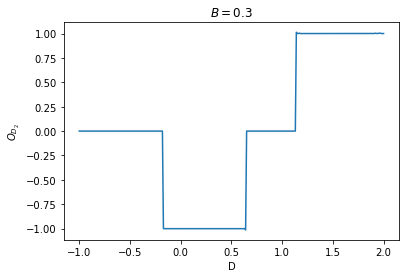

In [77]:
plt.plot(D_list, detector_list_B_3) 
plt.xlabel('D')
plt.ylabel(r'$O_{D_2}$')
plt.title(r'$B=0.3$')
plt.show()

# Store data

In [64]:
import pickle
pickle.dump( psi_list_B_3, open( "Haldane_J_1_B_3_waves.pkl", "wb" ) )
pickle.dump( result_list_B_3, open( "Haldane_J_1_B_3_results.pkl", "wb" ) )

In [194]:
psi = psi_list[22].copy()

In [195]:
B = psi.get_B(0)

In [196]:
SL = psi.get_SL(0)
SR = psi.get_SR(0)
len(SL)

95

In [197]:
B_array = B.to_ndarray()
B_array = np.swapaxes(B_array, 0, 1) # The tensor extracted from `psi` will be of the order (SL, p, SR) so we need to swap
print(B_array.shape)
psi_single = MPS.from_Bflat([SpinSite(S=1, conserve=None)], [B_array], bc='infinite', SVs=[SL, SR])

(3, 95, 93)


ValueError: shape of B incompatible with len of singular values

In [177]:
detect_SPT_spatial_inv(psi_single, Op='inversion')

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: inner(): `axes` currently defaults to 'range', will change to 'labels'


(0.9999999999999998+0j)

In [136]:
len(psi_list)

301